# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

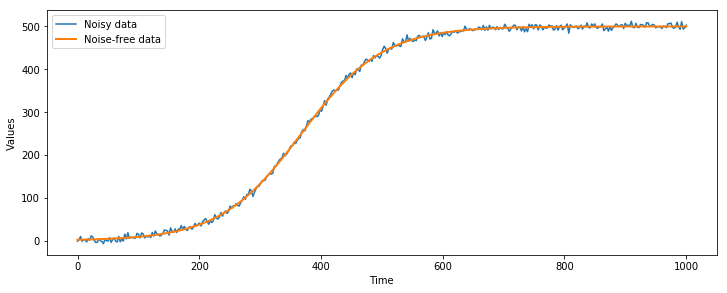

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

-1246.6023654393703
[1.50792432e-02 4.97604915e+02]
-1219.493500108242


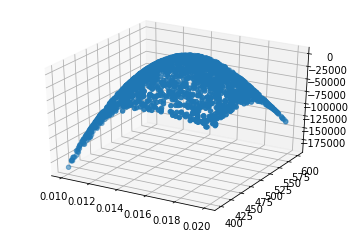

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(4000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

#print(max(likelihoods))
#idx = list(likelihoods).index(max(likelihoods))
#print(input_parameters[idx])
#print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [21]:
emu([0.015, 500])

array([[-1788.2521]], dtype=float32)

In [22]:
log_likelihood([0.015, 500])

-1219.493500108242

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


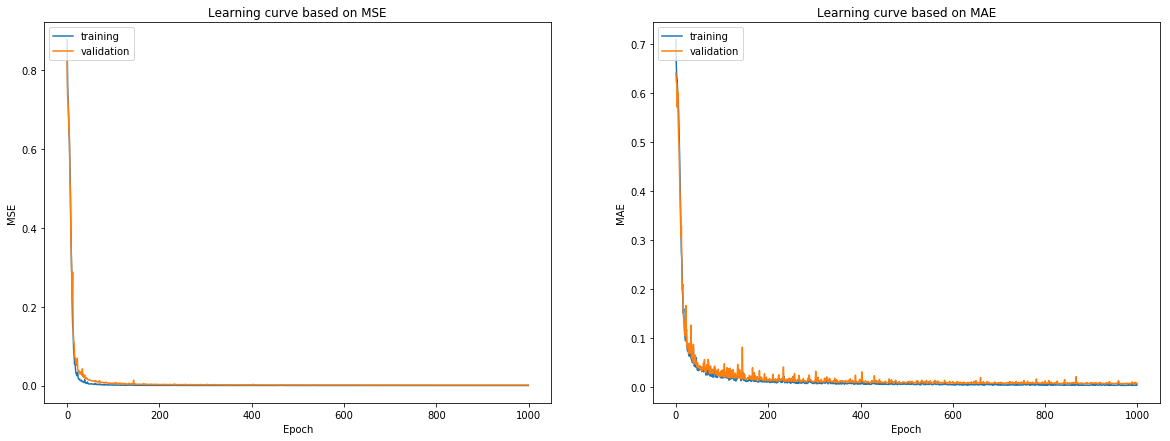

In [23]:
# summarize history for loss
print(hist.history.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))                 
ax1.title.set_text('Learning curve based on MSE')
ax2.title.set_text('Learning curve based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

plt.show()

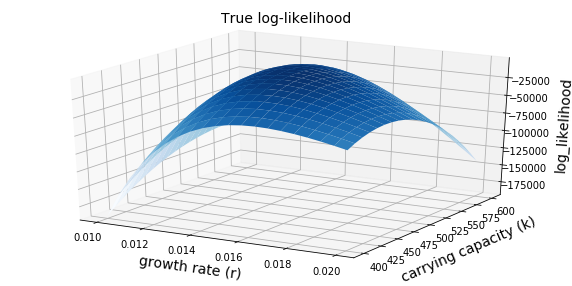

In [24]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

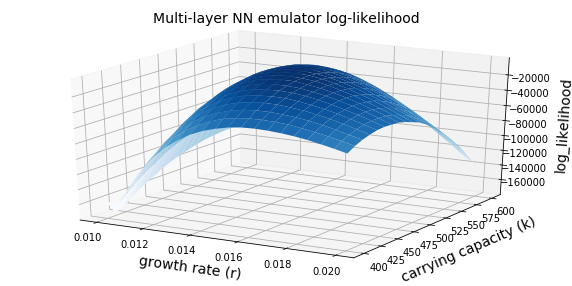

In [25]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

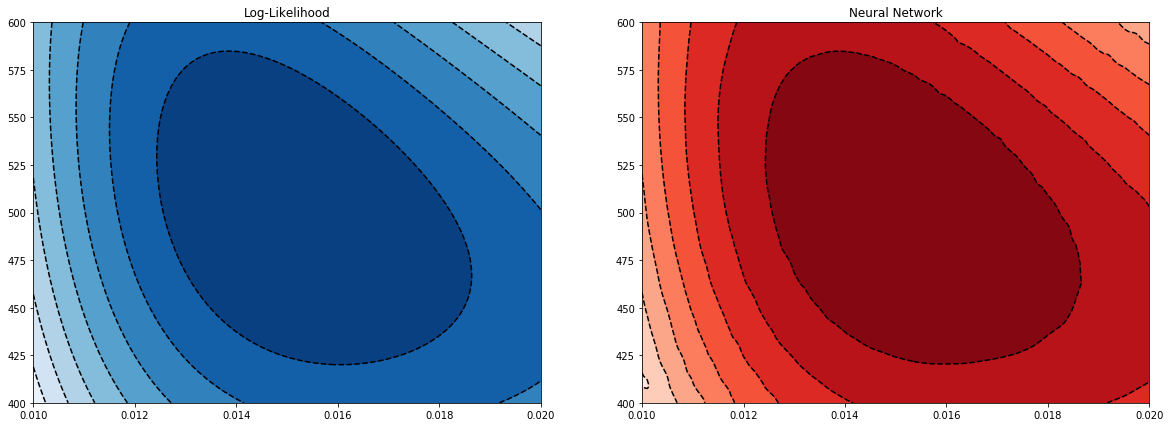

In [26]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

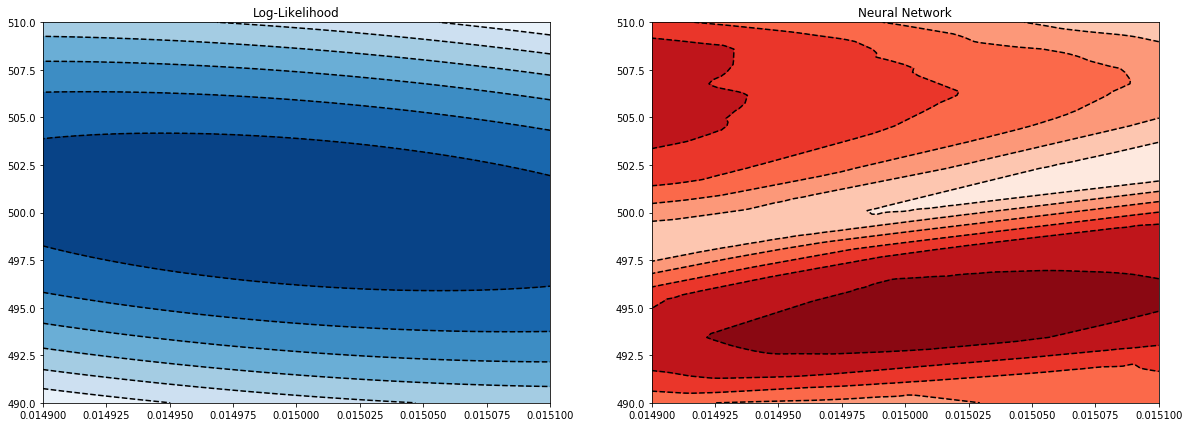

In [45]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0149, 490], [0.0151, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

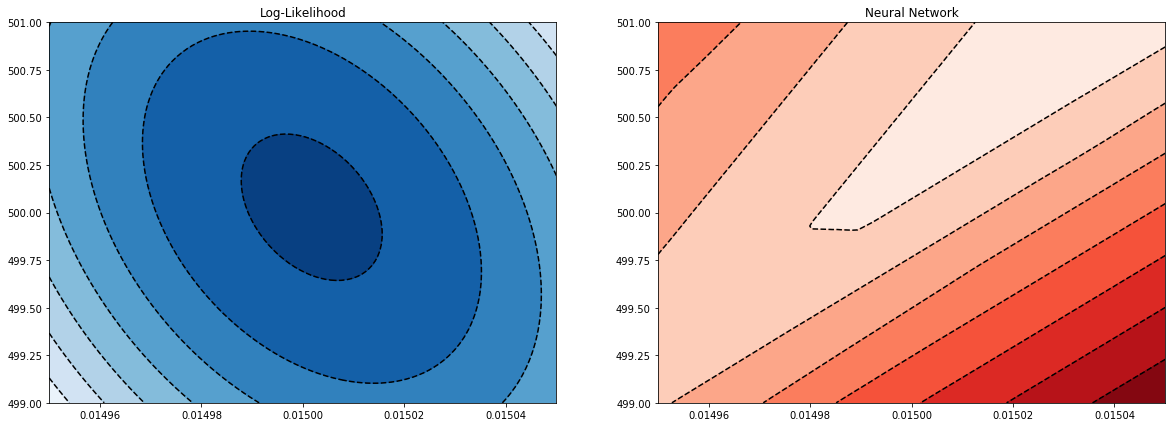

In [46]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.01495, 499], [0.01505, 501], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

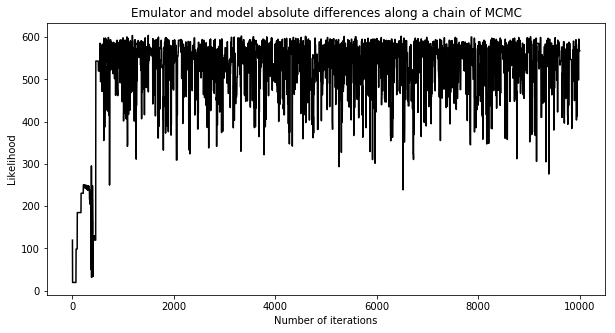

568.1537662181563

In [28]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [29]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

Running...
[2.61313994e-02 4.51200874e+02]
-inf


[1.03726350e-02 5.24151473e+02]
-101430.7755431027


[1.20631839e-02 5.76971291e+02]
-39225.32499302605
accepted


[1.86928958e-02 4.51358242e+02]
-26640.343759441654


[1.81125628e-02 5.23861306e+02]
-32545.686090391708


[7.11537023e-03 5.77182553e+02]
-inf


[5.27870859e-03 4.53100387e+02]
-inf


[6.90033028e-03 5.21519519e+02]
-inf


[6.38364621e-03 5.77746599e+02]
-inf


[2.53092146e-02 4.46509745e+02]
-inf


[2.99974167e-02 5.20901789e+02]
-inf


[1.28524991e-02 5.78333192e+02]
-27230.973764170234
accepted


[-1.25492505e-02  4.49079932e+02]
-inf


[1.70878697e-02 5.24255199e+02]
-19248.701304194477


[3.37534076e-02 5.75074519e+02]
-inf


[2.36656326e-02 4.46694141e+02]
-inf


[1.91294912e-02 5.25519837e+02]
-49050.58796008541


[1.16271635e-02 5.80212302e+02]
-50434.02734399557


[9.64495986e-03 4.49400143e+02]
-inf


[-4.96201866e-03  5.23457502e+02]
-inf


[3.20187226e-02 5.78999432e+02]
-inf


[6.22224037e-03 4.52099434e+02]


[2.39119905e-02 4.46425873e+02]
-inf


[3.33922294e-02 5.26214159e+02]
-inf


[8.13548196e-03 5.78037230e+02]
-inf


[5.59003312e-03 4.51083424e+02]
-inf


[2.93863361e-02 5.25865444e+02]
-inf


[2.73718107e-02 5.84604790e+02]
-inf


[1.34258184e-02 4.47926528e+02]
-26915.589358890607


[1.28909990e-02 5.23399974e+02]
-16493.57533380819


[-1.17468663e-02  5.77265941e+02]
-inf


[1.70619829e-02 4.46658459e+02]
-15480.30550759691


[4.08557538e-03 5.32663387e+02]
-inf


[3.34022476e-02 5.80443580e+02]
-inf


[2.38803536e-02 4.46739398e+02]
-inf


[9.18935015e-03 5.22089438e+02]
-inf


[-3.66957254e-03  5.79754076e+02]
-inf


[1.54591261e-02 4.48367832e+02]
-11094.238553691113


[2.40476094e-02 5.25609101e+02]
-inf


[2.43267244e-02 5.80470296e+02]
-inf


[2.79775777e-02 4.51108045e+02]
-inf


[2.51755043e-02 5.26203523e+02]
-inf


[4.50823279e-03 5.76730180e+02]
-inf


[1.39184582e-02 4.49294138e+02]
-19637.163714447106


[4.94479789e-03 5.21594887e+02]
-inf


[1.9980843e-02 5.8484525e+

[3.10494118e-02 5.82874333e+02]
-inf


[2.24323962e-02 4.49708733e+02]
-inf


[1.94309828e-02 5.16459665e+02]
-48665.096003183644


[1.19118127e-02 5.84099576e+02]
-44463.958925564846


[-4.00917144e-04  4.49472948e+02]
-inf


[1.15050793e-02 5.18843775e+02]
-51675.21793567449


[1.90524257e-02 5.80687561e+02]
-95131.12459756352


[4.48856951e-03 4.50440711e+02]
-inf


[1.82898563e-02 5.18658233e+02]
-32610.58397990725


[-7.22476694e-04  5.80103527e+02]
-inf


[3.23974041e-03 4.50849061e+02]
-inf


[1.82004222e-02 5.14448908e+02]
-29534.310050247946


[1.33866316e-02 5.78260459e+02]
-22959.16194632299
accepted


[1.35824581e-02 4.53787999e+02]
-21741.668439179462


[2.52769953e-02 5.17792282e+02]
-inf


[3.20227520e-02 5.77625787e+02]
-inf


[3.54526263e-03 4.52763392e+02]
-inf


[1.17071646e-02 5.15493087e+02]
-45358.885101568936


[1.76945742e-02 5.79893060e+02]
-66239.80451522782


[1.01827444e-02 4.49924534e+02]
-142337.6479684901


[1.32794411e-02 5.17401015e+02]
-10970.080309522

[1.41069213e-02 5.78166918e+02]
-21623.476842871638


[1.57162586e-02 4.50542140e+02]
-10163.423321322658
accepted


[1.48297236e-02 5.16181148e+02]
-2137.007472562519


[1.38523440e-02 5.78236276e+02]
-21582.367273522068


[1.57121806e-02 4.50445769e+02]
-10197.246665954917


[1.51251325e-02 5.16073136e+02]
-2486.4859451896464


[1.36673023e-02 5.78202837e+02]
-21866.954881040645


[1.58414773e-02 4.50672179e+02]
-10192.403353035952


[1.48864696e-02 5.16197697e+02]
-2165.6848573001507


[1.40310616e-02 5.78272378e+02]
-21597.65800988721


[1.57976398e-02 4.50572595e+02]
-10192.878124610363


[1.48126594e-02 5.16083910e+02]
-2122.0655688872916
accepted


[1.40734110e-02 5.78252594e+02]
-21626.6412226467


[1.58837887e-02 4.50625276e+02]
-10251.110991135547


[1.47655771e-02 5.16112816e+02]
-2125.0963635117505


[1.40667114e-02 5.78232981e+02]
-21609.31477240957


[1.56980592e-02 4.50558624e+02]
-10152.743981355652
accepted


[1.47903123e-02 5.16137613e+02]
-2126.150537027081


[1.3797

[1.44116667e-02 4.65710806e+02]
-8691.133712080464


[1.47326889e-02 5.14197873e+02]
-1944.1539398782866
accepted


[1.45427318e-02 5.74069029e+02]
-20684.50413001724


[1.51689345e-02 4.58792427e+02]
-7769.385858512069
accepted


[1.47496974e-02 5.14221233e+02]
-1938.0146563088076
accepted


[1.42044795e-02 5.76163974e+02]
-20743.204672375363


[1.49443989e-02 4.61622264e+02]
-7440.338473560345
accepted


[1.47375920e-02 5.13843171e+02]
-1909.4895679898507
accepted


[1.42393672e-02 5.76030313e+02]
-20745.33206390663


[1.50832181e-02 4.58035806e+02]
-8221.218571001362


[1.47390871e-02 5.13518596e+02]
-1880.178605464558
accepted


[1.45204529e-02 5.74222945e+02]
-20674.564395616966


[1.50899693e-02 4.63390409e+02]
-6503.94607282107
accepted


[1.47040309e-02 5.12485361e+02]
-1822.155570017073
accepted


[1.46704908e-02 5.73238295e+02]
-20827.145718302


[1.56164062e-02 4.55126971e+02]
-8555.457813175013


[1.47433131e-02 5.12786338e+02]
-1816.3737612250554
accepted


[1.42732914e-02

-1237.3938935986887


[1.64886023e-02 5.13960655e+02]
-9795.431039788897


[1.51801055e-02 4.96815827e+02]
-1312.8122893560185


[1.50239227e-02 4.95960166e+02]
-1281.8336357708881


[1.64513609e-02 5.21686749e+02]
-11626.59729034993


[1.50812890e-02 5.03345345e+02]
-1306.7505355828355


[1.50619852e-02 4.97714599e+02]
-1241.8070315767466


[1.59617525e-02 5.29862954e+02]
-10053.618289405094


[1.51713405e-02 5.04461241e+02]
-1451.9314266673484


[1.48979972e-02 4.96585384e+02]
-1331.7259425503507


[1.75095899e-02 4.74633963e+02]
-14047.102641826945


[1.51227874e-02 4.85557411e+02]
-1981.3839658403697


[1.50752637e-02 5.00407912e+02]
-1239.8613652182503


[1.71279431e-02 4.90057043e+02]
-11305.784491445816


[1.51303190e-02 5.04137178e+02]
-1384.3872497879458


[1.49413982e-02 5.01730199e+02]
-1234.9120784253769


[1.69725605e-02 5.02404166e+02]
-11638.048986277257


[1.51334097e-02 4.91407552e+02]
-1485.0699580569906


[1.48423932e-02 5.01353549e+02]
-1290.5176060785875


[1.56785



[1.50377610e-02 4.99404201e+02]
-1223.9427754363062
accepted


[1.50300638e-02 5.01025309e+02]
-1229.0772247127127


[1.51014390e-02 5.06830456e+02]
-1496.8086636811527


[1.50846489e-02 4.97996424e+02]
-1244.4375537858423


[1.50195933e-02 5.00682887e+02]
-1223.886406333716


[1.52675400e-02 4.74825749e+02]
-3513.9985424837487


[1.50315227e-02 5.01237768e+02]
-1231.9018275328206


[1.50520686e-02 4.99031765e+02]
-1227.9572016515465


[1.46019023e-02 5.03738527e+02]
-1673.6284251354043


[1.51956057e-02 4.96664331e+02]
-1327.9075709696665


[1.49861902e-02 4.99246517e+02]
-1224.4187255552467


[1.63517612e-02 5.03108288e+02]
-6598.367243912959


[1.51074917e-02 4.99634039e+02]
-1251.95898139003


[1.50439257e-02 4.99577288e+02]
-1224.9684755363269


[1.53385691e-02 5.21737668e+02]
-4124.8138856714895


[1.50670490e-02 4.99925113e+02]
-1232.9106342404043


[1.50184138e-02 5.01474828e+02]
-1231.583655497969


[1.52366076e-02 4.88992898e+02]
-1676.788330676661


[1.50036428e-02 4.95757


[1.50008877e-02 4.98976910e+02]
-1224.7502617215998


[1.50366375e-02 4.99730261e+02]
-1223.468041696237
accepted


[1.50076853e-02 4.99937037e+02]
-1220.2697113268553
accepted


[1.50341461e-02 4.99116367e+02]
-1224.3925115995164


[1.50652743e-02 4.93240152e+02]
-1385.704029892165


[1.49912700e-02 5.01523952e+02]
-1228.3408516925217


[1.49940729e-02 5.00391960e+02]
-1220.663665556852
accepted


[1.51863479e-02 5.04762995e+02]
-1489.747758122981


[1.50097839e-02 4.99336937e+02]
-1221.8598028331276


[1.49879489e-02 5.00863532e+02]
-1222.6585016231325
accepted


[1.52199018e-02 5.06152846e+02]
-1631.6167795475396


[1.5018635e-02 4.9953081e+02]
-1221.374771404318


[1.5000307e-02 5.0064213e+02]
-1221.6431853620768
accepted


[1.48658876e-02 5.01157851e+02]
-1271.1651821002395


[1.50042067e-02 5.00340547e+02]
-1220.652331014753


[1.50110491e-02 5.01304733e+02]
-1228.0789214385672


[1.50748640e-02 4.98909584e+02]
-1235.1143257908057


[1.50311736e-02 5.00277901e+02]
-1223.73768460


[1.49935767e-02 4.99339686e+02]
-1222.7730147652194


[1.49991280e-02 5.00783742e+02]
-1222.3587504420307
accepted


[1.50244642e-02 5.00738132e+02]
-1225.179513977207


[1.50019694e-02 4.99485053e+02]
-1221.3610783426152


[1.49851499e-02 5.01740567e+02]
-1230.633589033663


[1.50527722e-02 5.00806083e+02]
-1234.0425679427137


[1.49816334e-02 5.01280789e+02]
-1225.748274990131


[1.50364977e-02 4.99851369e+02]
-1223.5553314137696


[1.50094795e-02 4.99199591e+02]
-1222.6255066194683


[1.49904256e-02 4.99262067e+02]
-1223.6767108261786


[1.49735237e-02 5.01281099e+02]
-1226.137377101604


[1.50741795e-02 5.00020320e+02]
-1236.4187256170994


[1.49995425e-02 5.00414854e+02]
-1220.7259922428914
accepted


[1.49901770e-02 5.00720701e+02]
-1221.8826879602177
accepted


[1.49744617e-02 4.98490844e+02]
-1235.5900535843555


[1.49890805e-02 5.00735106e+02]
-1221.9700047354022
accepted


[1.49925995e-02 5.01046563e+02]
-1223.8920356068552


[1.49768489e-02 5.00055359e+02]
-1222.05756866392

[1.49880270e-02 4.99768082e+02]
-1221.3276582030142


[1.49688317e-02 5.00418991e+02]
-1223.1249039161323
accepted


[1.50082574e-02 5.01153873e+02]
-1226.0844329405363


[1.49952123e-02 5.00139676e+02]
-1220.2938685676659
accepted


[1.49831670e-02 4.99370534e+02]
-1224.0194620441478
accepted


[1.49931135e-02 4.99847047e+02]
-1220.6646933092331
accepted


[1.49812677e-02 4.99876401e+02]
-1221.832076169855


[1.49830734e-02 4.98995240e+02]
-1227.1989668930335


[1.49865704e-02 4.99603034e+02]
-1222.1580991599603


[1.49871636e-02 4.99798051e+02]
-1221.3268019259192


[1.49377116e-02 4.99572715e+02]
-1236.3177497871518


[1.49903287e-02 4.99965680e+02]
-1220.6515970656426
accepted


[1.49850915e-02 4.99515242e+02]
-1222.8135821094622
accepted


[1.49734902e-02 4.98423144e+02]
-1236.9067575834501


[1.49632660e-02 5.00461261e+02]
-1224.2009687570269


[1.49852830e-02 4.99319476e+02]
-1224.0260077482758


[1.49963522e-02 4.99585722e+02]
-1221.2543085878115
accepted


[1.50042911e-02 4.99



[1.49976191e-02 5.00013893e+02]
-1220.2285859274666
accepted


[1.50005542e-02 4.99784035e+02]
-1220.4405277960439
accepted


[1.50397568e-02 4.98947688e+02]
-1226.0409606123776


[1.49805620e-02 5.00167502e+02]
-1221.4095136593692


[1.50027814e-02 4.99736639e+02]
-1220.4940119003952
accepted


[1.50644911e-02 4.99800093e+02]
-1231.4366856686652


[1.50068201e-02 5.00625071e+02]
-1221.9578892814445


[1.49970311e-02 4.99677777e+02]
-1220.874955719382
accepted


[1.50348729e-02 4.99833450e+02]
-1223.213787072702


[1.49866477e-02 5.00049961e+02]
-1220.8571351104895


[1.49963715e-02 4.98766629e+02]
-1227.3055677705954


[1.50130184e-02 4.99959768e+02]
-1220.5232246005628
accepted


[1.50040836e-02 5.00351714e+02]
-1220.6784572061408
accepted


[1.49733325e-02 4.99822366e+02]
-1223.3537260060032


[1.50441283e-02 4.99978243e+02]
-1225.6025307041837


[1.50140436e-02 5.00148361e+02]
-1220.825621655884


[1.49876962e-02 4.99730602e+02]
-1221.4921008416916


[1.50078961e-02 4.99660151e+0

[1.49977348e-02 4.99455463e+02]
-1221.7451510503406


[1.50226215e-02 4.99793809e+02]
-1221.3504689963204
accepted


[1.50078324e-02 5.00305458e+02]
-1220.7411496853797
accepted


[1.49920104e-02 5.00373668e+02]
-1220.6754952475287


[1.50094641e-02 4.99965345e+02]
-1220.3328004850407
accepted


[1.49745426e-02 5.00847348e+02]
-1223.380511194678
accepted


[1.50191715e-02 4.99779931e+02]
-1221.012280662553
accepted


[1.50309776e-02 4.99536112e+02]
-1222.6334373855254


[1.49787724e-02 5.01036682e+02]
-1224.0522751594146
accepted


[1.50221060e-02 5.00655993e+02]
-1224.1362522650174


[1.50267144e-02 4.99495882e+02]
-1222.1719310409987


[1.49786016e-02 5.00725853e+02]
-1222.496451198736
accepted


[1.50396664e-02 4.99226893e+02]
-1224.7580429759419


[1.5048069e-02 4.9902812e+02]
-1227.1021614090912


[1.49927389e-02 5.00942062e+02]
-1223.1503174599657
accepted


[1.50287206e-02 4.99554600e+02]
-1222.2985251311861


[1.50543110e-02 4.99274124e+02]
-1227.8094467088117


[1.49954571e-02

[1.50297385e-02 5.00109157e+02]
-1222.831430132884


[1.50067258e-02 5.00921213e+02]
-1223.873441181695


[1.49966769e-02 5.00304968e+02]
-1220.44745183869
accepted


[1.50040734e-02 4.99559839e+02]
-1220.989811991837
accepted


[1.49916250e-02 4.99708518e+02]
-1221.1724149357733
accepted


[1.49877583e-02 5.00128809e+02]
-1220.7064748624578
accepted


[1.49920967e-02 5.01230142e+02]
-1225.3945888001972


[1.49952081e-02 4.99452089e+02]
-1221.9654304070598
accepted


[1.49857708e-02 4.99759658e+02]
-1221.6151010210776
accepted


[1.49617404e-02 5.00782020e+02]
-1225.012418420267


[1.49627793e-02 5.00110749e+02]
-1224.694206691519


[1.50118942e-02 5.00297809e+02]
-1221.0173149198533
accepted


[1.49987194e-02 4.99991577e+02]
-1220.2129037558286
accepted


[1.49855285e-02 5.00137873e+02]
-1220.8943916492158
accepted


[1.50036463e-02 4.99658343e+02]
-1220.6797726909151
accepted


[1.49979380e-02 5.00351453e+02]
-1220.5407635385798


[1.49836959e-02 4.99938366e+02]
-1221.3552637176488
a

-1225.3363593182908


[1.49782149e-02 5.00171012e+02]
-1221.708701016034
accepted


[1.49921913e-02 4.99982577e+02]
-1220.4991136561755
accepted


[1.49678652e-02 5.01083890e+02]
-1225.3514234081545


[1.49739258e-02 5.00557218e+02]
-1222.5186746406587
accepted


[1.49629931e-02 4.99608465e+02]
-1226.9398236814263


[1.49668223e-02 5.00054592e+02]
-1223.919942553357


[1.49706238e-02 5.01030152e+02]
-1224.7175700761793


[1.49791151e-02 5.00388621e+02]
-1221.628777895317


[1.50046641e-02 5.00482577e+02]
-1221.151048204966
accepted


[1.49935581e-02 5.01040261e+02]
-1223.8731854499918


[1.50027933e-02 5.00062341e+02]
-1220.1815429548174
accepted


[1.50110155e-02 5.00097416e+02]
-1220.5125786425563
accepted


[1.49442845e-02 5.00733112e+02]
-1229.223013584355


[1.50113561e-02 4.99642255e+02]
-1220.7588213742981
accepted


[1.49815936e-02 5.00248954e+02]
-1221.2718473499674
accepted


[1.49358566e-02 5.00494242e+02]
-1232.174571217484


[1.49680635e-02 4.99357071e+02]
-1227.4256502198

[1.50019534e-02 4.98838864e+02]
-1225.914601078749


[1.49964665e-02 5.01188493e+02]
-1225.2437208872632
accepted


[1.49838301e-02 5.00333732e+02]
-1221.102503940737


[1.50332226e-02 4.98730881e+02]
-1226.751956615217


[1.49943849e-02 5.00779439e+02]
-1222.1854028918222
accepted


[1.49757033e-02 5.00414606e+02]
-1222.0709816748833


[1.50505930e-02 4.99383525e+02]
-1226.6883376972469


[1.50561021e-02 5.01352741e+02]
-1242.5118724281174


[1.49955917e-02 4.99580055e+02]
-1221.3329532039663


[1.50555776e-02 4.99064210e+02]
-1228.6869181475658


[1.49886849e-02 5.00967130e+02]
-1223.2851637588778


[1.50416749e-02 4.99328070e+02]
-1224.8252659251232


[1.50443575e-02 4.98961492e+02]
-1226.711010167428


[1.5029611e-02 5.0021319e+02]
-1223.1619101406238


[1.49623988e-02 4.99791361e+02]
-1226.0234067821868


[1.50535763e-02 4.98302367e+02]
-1233.29943821355


[1.50096411e-02 5.00583584e+02]
-1221.9897613848943
accepted


[1.49885142e-02 4.99399430e+02]
-1223.0136031214095


[1.503560

[1.50094605e-02 5.00888808e+02]
-1223.932170137239
accepted


[1.49683587e-02 5.02149583e+02]
-1236.132344655064


[1.49566877e-02 5.00197496e+02]
-1226.0287016553698


[1.50319354e-02 5.00857466e+02]
-1227.900883162421


[1.50139144e-02 4.98539806e+02]
-1228.171107122266


[1.50279460e-02 4.99733363e+02]
-1222.0280146985988
accepted


[1.49819875e-02 5.01653062e+02]
-1229.4971035258156


[1.49840246e-02 4.99863516e+02]
-1221.5030043245513
accepted


[1.50302121e-02 4.99489516e+02]
-1222.6131737850885


[1.49802356e-02 5.01904464e+02]
-1232.6255975980646


[1.49969573e-02 4.99627735e+02]
-1221.0521067881539
accepted


[1.49605367e-02 5.00442750e+02]
-1224.7861974752573
accepted


[1.50335700e-02 5.01419649e+02]
-1234.9130151342667


[1.50413017e-02 4.99298513e+02]
-1224.8304300081736


[1.49755896e-02 5.00691692e+02]
-1222.6725215776498
accepted


[1.50046072e-02 5.02081713e+02]
-1237.8889661041012


[1.49558670e-02 5.01013196e+02]
-1226.992123062063


[1.49214424e-02 5.02966613e+02]
-

[1.49753998e-02 5.00049123e+02]
-1222.299568529317
accepted


[1.50188365e-02 4.97704153e+02]
-1239.8417209047368


[1.49441554e-02 5.00992477e+02]
-1229.7888633130717


[1.49486299e-02 5.00460924e+02]
-1227.8965269157768


[1.50031210e-02 4.99389883e+02]
-1221.7627008599752
accepted


[1.49784580e-02 5.00483723e+02]
-1221.837096607759
accepted


[1.49490096e-02 4.99386450e+02]
-1233.3756153964612


[1.49861730e-02 4.97418927e+02]
-1252.031205437394


[1.50055032e-02 5.00683583e+02]
-1222.1735679170056
accepted


[1.49909221e-02 4.99391415e+02]
-1222.7559161222014
accepted


[1.50240872e-02 4.98767410e+02]
-1225.8843434843075


[1.49733537e-02 4.99799758e+02]
-1223.4425561163932


[1.49529898e-02 4.99904193e+02]
-1228.1957081264195


[1.50372882e-02 5.00245357e+02]
-1224.9431220683873


[1.49803099e-02 5.00892670e+02]
-1223.122846390502


[1.50159832e-02 5.01157358e+02]
-1227.3441362843987


[1.50308932e-02 4.98385037e+02]
-1229.8809145003474


[1.50455410e-02 4.99937401e+02]
-1225.850

-1220.4213656767606
accepted


[1.50180962e-02 4.98962539e+02]
-1224.1958325131397


[1.49778801e-02 5.00630804e+02]
-1222.2449580292061


[1.50081884e-02 4.99930524e+02]
-1220.2869481406858
accepted


[1.50116236e-02 5.00124734e+02]
-1220.5934245629921
accepted


[1.49617113e-02 4.99677049e+02]
-1226.8598483309697


[1.49923123e-02 5.00275186e+02]
-1220.5046228987655
accepted


[1.50580985e-02 4.99464780e+02]
-1228.7161718275433


[1.50545658e-02 4.99288950e+02]
-1227.85124581025


[1.50210956e-02 4.99751452e+02]
-1221.2089110960585
accepted


[1.50132047e-02 4.99599895e+02]
-1220.9220213861565
accepted


[1.49659366e-02 4.99513847e+02]
-1226.787599267203


[1.49648789e-02 4.99851231e+02]
-1225.0977202657061


[1.50355845e-02 4.99106875e+02]
-1224.625166278427


[1.49936859e-02 5.01184074e+02]
-1225.0529647236992


[1.49988419e-02 4.99104059e+02]
-1223.897118525416


[1.49674019e-02 4.99416146e+02]
-1227.1275300448895


[1.49557839e-02 5.01333899e+02]
-1228.780269461838


[1.50166569e

[1.49977532e-02 4.98909253e+02]
-1225.6902614067694


[1.49900016e-02 5.00555716e+02]
-1221.22462623605


[1.49902870e-02 5.01444193e+02]
-1227.4150731281552


[1.49966606e-02 4.98146030e+02]
-1235.4819544432933


[1.50211489e-02 5.00215833e+02]
-1221.7932445104013


[1.50573822e-02 4.98831708e+02]
-1230.138469246466


[1.50171150e-02 5.00615004e+02]
-1223.064096425012


[1.49795031e-02 4.99983806e+02]
-1221.8075421008682
accepted


[1.49793903e-02 4.98876459e+02]
-1229.2625667895957


[1.4985876e-02 5.0013126e+02]
-1220.8655504801702
accepted


[1.49723230e-02 4.99515801e+02]
-1225.195322688498


[1.49520696e-02 5.00162207e+02]
-1227.4425359651748


[1.49801158e-02 5.01507639e+02]
-1227.9083541205196


[1.49620669e-02 5.00960582e+02]
-1225.591148494981


[1.49824549e-02 4.99665683e+02]
-1222.4460891028805
accepted


[1.49427341e-02 5.00709695e+02]
-1229.6841819480965


[1.50236161e-02 4.99132135e+02]
-1223.317480062617


[1.49691607e-02 5.00382373e+02]
-1223.0553240686793
accepted


[

[1.49749426e-02 4.99696070e+02]
-1223.6034934837417


[1.48854208e-02 5.00505175e+02]
-1259.3068899144237


[1.50097846e-02 4.98739150e+02]
-1226.2906869748458


[1.49820363e-02 4.99856789e+02]
-1221.7833531388249
accepted


[1.50147693e-02 5.00534655e+02]
-1222.296385672869
accepted


[1.49722605e-02 5.00352871e+02]
-1222.5322969796848
accepted


[1.4979342e-02 5.0107127e+02]
-1224.2439292966656


[1.50676884e-02 4.99833637e+02]
-1232.776216115427


[1.49603808e-02 4.99886692e+02]
-1226.1026495503102


[1.50029927e-02 4.99667023e+02]
-1220.6683056838765
accepted


[1.49846234e-02 5.00233823e+02]
-1220.968476767064
accepted


[1.49391536e-02 5.01612849e+02]
-1234.5052532579896


[1.50017206e-02 4.97573942e+02]
-1244.7387665825743


[1.49856285e-02 5.01235025e+02]
-1225.3123569366946


[1.49633188e-02 5.01305865e+02]
-1227.3900200479293


[1.50338887e-02 5.00010961e+02]
-1223.3492387410063


[1.49921215e-02 4.99761025e+02]
-1220.9614668767506
accepted


[1.49580798e-02 5.00731417e+02]
-


[1.50202602e-02 4.99935824e+02]
-1221.1348932395197
accepted


[1.50408484e-02 4.98793300e+02]
-1227.166032764375


[1.49856506e-02 4.99408411e+02]
-1223.367491080945


[1.50957649e-02 4.99796424e+02]
-1245.9752697128454


[1.49774488e-02 4.99743782e+02]
-1222.9175464719556


[1.50458634e-02 5.00265238e+02]
-1227.3314503503182


[1.50709139e-02 4.99363170e+02]
-1233.030216644837


[1.49949159e-02 4.98930568e+02]
-1225.8432720731453


[1.49708818e-02 5.00218053e+02]
-1222.8175219054658


[1.50740499e-02 4.98378665e+02]
-1237.6588457860796


[1.50233620e-02 4.99253553e+02]
-1222.6912015757039


[1.50197352e-02 5.00050779e+02]
-1221.2180638015136
accepted


[1.49244111e-02 4.99236376e+02]
-1246.608504122173


[1.49925541e-02 5.00318940e+02]
-1220.5583230830512
accepted


[1.50804668e-02 4.98341476e+02]
-1240.0463859026056


[1.5015099e-02 4.9882621e+02]
-1225.292232856608


[1.49895571e-02 5.00853177e+02]
-1222.579445545123


[1.49926103e-02 4.99474897e+02]
-1222.0940599443204
accepted



[1.49676919e-02 5.00616689e+02]
-1223.5600820460327


[1.50471815e-02 4.99686079e+02]
-1225.7905674952908


[1.49443702e-02 5.02287692e+02]
-1240.562603513271


[1.50015621e-02 5.00901670e+02]
-1223.2723234648167


[1.49991678e-02 5.00345206e+02]
-1220.5342486460524
accepted


[1.49895263e-02 5.00013825e+02]
-1220.6515236276014
accepted


[1.50247389e-02 4.99408884e+02]
-1222.2066689356657
accepted


[1.50163089e-02 5.00517511e+02]
-1222.4033281988013


[1.49647117e-02 5.00816602e+02]
-1224.5895623574088


[1.50385891e-02 5.00265413e+02]
-1225.3580953023843


[1.50074856e-02 4.99986387e+02]
-1220.2608030245926
accepted


[1.50098261e-02 4.99004082e+02]
-1223.9655843722064
accepted


[1.50010358e-02 4.98732184e+02]
-1227.0933550058273


[1.50025647e-02 4.99077017e+02]
-1223.7942167556632


[1.50620831e-02 4.98860992e+02]
-1231.227068161766


[1.50395604e-02 4.99292032e+02]
-1224.535021156458


[1.50107085e-02 4.99972227e+02]
-1220.3930944013468
accepted


[1.4998763e-02 4.9806790e+02]
-



[1.50078743e-02 4.99357730e+02]
-1221.779257536725


[1.49709373e-02 4.99780031e+02]
-1224.0256194518654
accepted


[1.50033907e-02 4.98240531e+02]
-1232.9656546737594


[1.49465755e-02 5.00633468e+02]
-1228.4662626948832


[1.49874730e-02 5.01980418e+02]
-1234.0382911974468


[1.49832221e-02 5.02394454e+02]
-1240.4344152539038


[1.49774512e-02 5.01060313e+02]
-1224.2866466398236


[1.49266425e-02 4.99450840e+02]
-1242.8650633973327


[1.49843437e-02 5.00113025e+02]
-1221.0243401477114
accepted


[1.49978251e-02 5.00234577e+02]
-1220.325435665395
accepted


[1.49968351e-02 4.98229059e+02]
-1234.169358315029


[1.49797902e-02 4.99302644e+02]
-1225.1372325162743


[1.50592327e-02 4.99021802e+02]
-1229.7972755977244


[1.49161739e-02 4.98149228e+02]
-1270.8597266367747


[1.49903143e-02 5.00272725e+02]
-1220.591498985937
accepted


[1.49914450e-02 5.00407526e+02]
-1220.766063365689
accepted


[1.49160900e-02 4.99253998e+02]
-1251.205926338368


[1.49897981e-02 4.99962363e+02]
-1220.698

-1221.9449654594798
accepted


[1.50454297e-02 4.99455186e+02]
-1225.382517971849


[1.49761993e-02 5.00137435e+02]
-1222.0314442117722


[1.50136254e-02 4.98816241e+02]
-1225.4105915241942


[1.50256266e-02 4.99190855e+02]
-1223.1560860215159


[1.49893894e-02 4.99859097e+02]
-1220.9353807887549
accepted


[1.50478231e-02 4.99188337e+02]
-1226.4585798710168


[1.50109369e-02 4.99822000e+02]
-1220.4507571017289
accepted


[1.49734146e-02 5.00284395e+02]
-1222.3520337408033


[1.50585955e-02 4.98861895e+02]
-1230.292166833476


[1.49492823e-02 4.99944010e+02]
-1229.209392742088


[1.49902792e-02 4.99349127e+02]
-1223.101296426401


[1.50006665e-02 4.99222899e+02]
-1222.8869944266269


[1.50087862e-02 4.99244969e+02]
-1222.3690519538595
accepted


[1.49570466e-02 4.99257248e+02]
-1231.7043547115761


[1.50304329e-02 4.99849999e+02]
-1222.4448667556314
accepted


[1.50123380e-02 4.98965133e+02]
-1224.197450305295


[1.50002885e-02 4.99799462e+02]
-1220.4165189453063
accepted


[1.50034306

[1.50012139e-02 4.99122712e+02]
-1223.551022277055


[1.50332638e-02 5.00593448e+02]
-1226.053322913441


[1.49383362e-02 5.01415513e+02]
-1233.37314134665


[1.50171164e-02 4.99571427e+02]
-1221.1779053021116
accepted


[1.50147483e-02 4.99842307e+02]
-1220.6396602091863
accepted


[1.50232683e-02 5.01248729e+02]
-1229.8804117927032


[1.50050689e-02 4.99598350e+02]
-1220.8386130301003
accepted


[1.49569907e-02 4.99986859e+02]
-1226.6160300537776


[1.50279806e-02 4.99310181e+02]
-1222.8625048471251


[1.49990584e-02 4.99462390e+02]
-1221.621260287163
accepted


[1.50681278e-02 4.98296204e+02]
-1236.6116189093375


[1.49635144e-02 4.99759252e+02]
-1225.8969866859827


[1.49843017e-02 5.00677890e+02]
-1221.90657405519
accepted


[1.50001537e-02 5.00949607e+02]
-1223.5226896348997


[1.49799509e-02 5.00540923e+02]
-1221.8051315363575


[1.50227425e-02 4.99340838e+02]
-1222.2794993410482
accepted


[1.50466074e-02 5.00065012e+02]
-1226.582626444202


[1.49538746e-02 5.00783550e+02]
-122

[1.50345272e-02 5.00757462e+02]
-1227.6789461708609


[1.49965809e-02 4.99806280e+02]
-1220.547632293062
accepted


[1.49934692e-02 5.00426363e+02]
-1220.759009471163
accepted


[1.49972077e-02 4.99689463e+02]
-1220.8275709803047
accepted


[1.49312791e-02 5.00809739e+02]
-1233.7330579531392


[1.50045271e-02 5.00075403e+02]
-1220.2147904276246
accepted


[1.49977294e-02 5.00232177e+02]
-1220.3229368829207
accepted


[1.50187151e-02 4.99377008e+02]
-1221.8844373477025


[1.50008377e-02 5.01209237e+02]
-1225.7771495826275


[1.50039997e-02 5.00784896e+02]
-1222.6662990295895


[1.50225527e-02 4.99111341e+02]
-1223.3726884674763


[1.50086055e-02 5.01606086e+02]
-1231.3773624569912


[1.50439517e-02 5.00151220e+02]
-1226.214003546915


[1.49590502e-02 4.98615309e+02]
-1238.9946196602616


[1.50304558e-02 4.99188843e+02]
-1223.622367478003


[1.49760121e-02 5.01038070e+02]
-1224.2516106361606


[1.49888118e-02 4.99119582e+02]
-1225.0257216756838


[1.50180853e-02 4.99398813e+02]
-1221.768

[1.49861744e-02 4.99729577e+02]
-1221.6744270695579
accepted


[1.50560167e-02 4.99572251e+02]
-1228.1344356713232


[1.49483732e-02 5.00921167e+02]
-1228.4260787549126


[1.49920308e-02 4.99421387e+02]
-1222.4505217625908
accepted


[1.50514908e-02 5.00180862e+02]
-1228.6002281685749


[1.50599711e-02 4.98961250e+02]
-1230.2221137660615


[1.50159196e-02 4.99133248e+02]
-1223.0145030616545
accepted


[1.50409128e-02 4.99747785e+02]
-1224.3630819348193


[1.49966862e-02 5.00746532e+02]
-1222.0559917780838


[1.50368077e-02 4.99192271e+02]
-1224.4293297148918


[1.50589408e-02 4.98665339e+02]
-1231.483044942089


[1.49879931e-02 4.99528662e+02]
-1222.3439015077831
accepted


[1.50635997e-02 4.97795328e+02]
-1241.0213962748544


[1.49733725e-02 4.99723021e+02]
-1223.7853219951671
accepted


[1.49444126e-02 5.00261312e+02]
-1229.6183853935947


[1.50364376e-02 4.97925787e+02]
-1235.9416279369505


[1.49231100e-02 5.00043845e+02]
-1239.5483023444733


[1.50094761e-02 4.99015949e+02]
-1223.

-1245.6191971726578


[1.49439074e-02 5.00654790e+02]
-1229.2882233374307


[1.49759537e-02 4.99840451e+02]
-1222.795890232898


[1.51247159e-02 4.95378722e+02]
-1308.2446821429132


[1.50161983e-02 5.00508843e+02]
-1222.3440931929686


[1.49906096e-02 4.97804883e+02]
-1242.7498020115427


[1.50315485e-02 4.98855702e+02]
-1225.6606722650886


[1.50006773e-02 4.99835497e+02]
-1220.341180110983
accepted


[1.49321242e-02 5.02152902e+02]
-1241.5481833212116


[1.50211973e-02 5.00635807e+02]
-1223.8416219125131
accepted


[1.50101623e-02 5.00423197e+02]
-1221.3059781308903


[1.50459712e-02 4.98816852e+02]
-1227.8211358078731


[1.50523684e-02 5.01175019e+02]
-1238.341680620556


[1.50030589e-02 4.99617306e+02]
-1220.8178145992276


[1.50406593e-02 5.01444293e+02]
-1237.6564881330921


[1.49621141e-02 5.01523046e+02]
-1229.2972287981033


[1.50191797e-02 4.99817828e+02]
-1220.9969109764506


[1.49828158e-02 4.99326056e+02]
-1224.3956956339955


[1.50463524e-02 4.99899642e+02]
-1225.9611929

-1250.593998648215


[1.49980929e-02 5.00960976e+02]
-1223.4813182573303


[1.49744599e-02 5.00180009e+02]
-1222.2533971304395


[1.49816943e-02 5.01123303e+02]
-1224.5014545527163


[1.50492679e-02 5.00324395e+02]
-1228.7298208043542


[1.50151798e-02 4.98933472e+02]
-1224.4050190988498


[1.49680410e-02 5.00011494e+02]
-1223.7781006001728


[1.50056751e-02 5.00624542e+02]
-1221.8661347095656


[1.50307821e-02 5.00770225e+02]
-1226.8386338847947


[1.50092238e-02 4.99768355e+02]
-1220.4591789978078
accepted


[1.4998811e-02 5.0027737e+02]
-1220.3905428814949
accepted


[1.50113909e-02 5.00467675e+02]
-1221.6027862496928


[1.49973571e-02 4.99519829e+02]
-1221.4660495362814
accepted


[1.50394854e-02 4.98852373e+02]
-1226.5820562191761


[1.50179898e-02 4.99340491e+02]
-1221.998605901415


[1.49856805e-02 4.99706649e+02]
-1221.8238492087146
accepted


[1.50279826e-02 4.99986541e+02]
-1222.2362879146783


[1.50133449e-02 4.99575349e+02]
-1220.991763417027
accepted


[1.49444157e-02 5.00

[1.50491967e-02 5.00586605e+02]
-1230.655218771261


[1.50077357e-02 5.00052315e+02]
-1220.2973587532579
accepted


[1.50210512e-02 5.01181115e+02]
-1228.6096772044548


[1.50363049e-02 4.98372823e+02]
-1230.3504603315275


[1.50078204e-02 4.98848363e+02]
-1225.3677722200148


[1.49785306e-02 5.00125928e+02]
-1221.7083360864135


[1.49759389e-02 4.99303936e+02]
-1225.934206836099


[1.50416186e-02 4.98206545e+02]
-1232.6691683903416


[1.49584929e-02 5.01050721e+02]
-1226.6423076113929


[1.50296773e-02 4.98871169e+02]
-1225.3939550054922


[1.50431494e-02 4.98768696e+02]
-1227.6737243246823


[1.49666784e-02 4.99604600e+02]
-1225.9816602577455


[1.50301690e-02 4.98339961e+02]
-1230.3565209474002


[1.50272186e-02 4.98733467e+02]
-1226.30787559574


[1.50109301e-02 5.01568067e+02]
-1231.286415140237


[1.50463518e-02 5.00080086e+02]
-1226.5720108612495


[1.50165197e-02 5.00861289e+02]
-1224.708663289239


[1.49669600e-02 5.00625438e+02]
-1223.6998028754763


[1.50051553e-02 4.9787857

[1.49573130e-02 5.03666463e+02]
-1266.8480456136742


[1.50015257e-02 5.01186062e+02]
-1225.621543788693


[1.49655395e-02 4.99447687e+02]
-1227.3869419973103


[1.50068436e-02 5.01427407e+02]
-1228.8344645504008


[1.50503305e-02 4.99803891e+02]
-1226.8227563267592


[1.50655138e-02 4.98974521e+02]
-1231.783516764205


[1.50202413e-02 5.01264315e+02]
-1229.37563656712


[1.50327606e-02 4.98837064e+02]
-1225.9049394955846


[1.49975506e-02 5.01568394e+02]
-1229.3681943995082


[1.50120591e-02 5.00885788e+02]
-1224.2405562171436


[1.50088819e-02 5.01588517e+02]
-1231.1903796973338


[1.49834730e-02 5.01217872e+02]
-1225.1870901213845


[1.50080135e-02 5.01160830e+02]
-1226.1196028408867


[1.50536151e-02 5.00628714e+02]
-1232.6034004499934


[1.49636926e-02 5.00439424e+02]
-1224.1071927801445


[1.50042746e-02 4.99689788e+02]
-1220.5852015572052
accepted


[1.49878283e-02 5.01186938e+02]
-1224.9174658918619


[1.50252309e-02 5.00930874e+02]
-1226.9799495601371


[1.49710068e-02 4.99725



[1.50396173e-02 4.98925391e+02]
-1226.149459391961


[1.50231618e-02 5.00142833e+02]
-1221.8610414249172


[1.50083058e-02 5.00912895e+02]
-1223.9827742626471


[1.49899111e-02 4.99412982e+02]
-1222.7496195825372


[1.50347845e-02 4.98957824e+02]
-1225.3242771075495


[1.50157722e-02 5.00289191e+02]
-1221.3682762369756


[1.50105304e-02 4.98760022e+02]
-1226.0480630983468


[1.49693848e-02 5.00457559e+02]
-1223.055152115471


[1.50039090e-02 4.99903089e+02]
-1220.225873795849
accepted


[1.49800487e-02 4.99684707e+02]
-1222.738426505114


[1.50473467e-02 4.99757266e+02]
-1225.9233907138585


[1.50306563e-02 4.98808205e+02]
-1225.934292394449


[1.50145880e-02 4.99453984e+02]
-1221.4194173716535
accepted


[1.49736696e-02 4.99725016e+02]
-1223.7156204117116


[1.50290822e-02 4.98769902e+02]
-1226.1179835206246


[1.50564707e-02 4.98579009e+02]
-1231.505356912891


[1.49526501e-02 4.99145322e+02]
-1234.4884569089975


[1.50423886e-02 4.99425223e+02]
-1224.772640304832


[1.50398458e-02

-1223.5806815357435


[1.49788908e-02 5.00431025e+02]
-1221.7059431614337


[1.49855624e-02 5.00967265e+02]
-1223.3287525708563


[1.49677372e-02 4.99970722e+02]
-1223.9699039956859


[1.50156908e-02 4.99935295e+02]
-1220.7064652964307
accepted


[1.50120711e-02 4.99597840e+02]
-1220.890389647594
accepted


[1.49881855e-02 5.00143641e+02]
-1220.6696953283383
accepted


[1.49818928e-02 5.00499092e+02]
-1221.5349935364573
accepted


[1.49931216e-02 5.00350770e+02]
-1220.597401921192
accepted


[1.49427483e-02 5.01726164e+02]
-1234.5583181165114


[1.49874896e-02 4.99761109e+02]
-1221.4094354687536
accepted


[1.49717707e-02 4.99427140e+02]
-1225.9430268798183


[1.49563562e-02 5.00052801e+02]
-1226.5465653663584


[1.49747637e-02 4.99650414e+02]
-1223.8722609263348
accepted


[1.50021087e-02 5.00751752e+02]
-1222.3307282579362


[1.50044647e-02 4.99111695e+02]
-1223.4099774536387


[1.49868175e-02 5.00205643e+02]
-1220.7763150382145
accepted


[1.49632580e-02 5.01055517e+02]
-1225.845784

[1.49825263e-02 4.99469276e+02]
-1223.484097150747


[1.49683342e-02 5.02956293e+02]
-1250.4830992019897


[1.50105155e-02 4.98352248e+02]
-1230.6512445263445


[1.50197321e-02 4.99801891e+02]
-1221.0529837542788
accepted


[1.49881829e-02 4.99301901e+02]
-1223.706256479182


[1.49393319e-02 5.00188156e+02]
-1231.6996282723915


[1.50335372e-02 4.99303493e+02]
-1223.558797079056


[1.49760897e-02 4.99043259e+02]
-1228.2677399846486


[1.49967260e-02 4.99084698e+02]
-1224.266139118883


[1.49906348e-02 4.99989625e+02]
-1220.5966786810625
accepted


[1.49962600e-02 4.99621602e+02]
-1221.1204616945415
accepted


[1.49114249e-02 5.01942552e+02]
-1246.497254926785


[1.49960138e-02 5.00478206e+02]
-1220.886543221598
accepted


[1.50154024e-02 4.99112614e+02]
-1223.1368571224705


[1.49752391e-02 5.01135488e+02]
-1224.9402830738345


[1.50407742e-02 5.00133417e+02]
-1225.304755754069


[1.50159869e-02 4.99746680e+02]
-1220.7953273105672
accepted


[1.50065649e-02 5.01359275e+02]
-1228.007219

[1.50191252e-02 5.00129353e+02]
-1221.302669590567


[1.50565066e-02 4.99023961e+02]
-1229.067163044092


[1.50233317e-02 4.99725154e+02]
-1221.4584321088748


[1.50472445e-02 4.98822216e+02]
-1228.0158519042836


[1.5016155e-02 5.0073600e+02]
-1223.7122712641037


[1.50456169e-02 4.98383182e+02]
-1231.2475260314145


[1.49849733e-02 4.99460319e+02]
-1223.1488416949107


[1.49991816e-02 5.00062389e+02]
-1220.1880704972755
accepted


[1.49881023e-02 4.99780186e+02]
-1221.2809193784567
accepted


[1.50392866e-02 5.01720457e+02]
-1241.5355115680575


[1.50305000e-02 4.98967753e+02]
-1224.8159373968285


[1.50219756e-02 4.98916677e+02]
-1224.6281525734846


[1.50171981e-02 5.00425946e+02]
-1222.0736879162525
accepted


[1.50232477e-02 4.99753555e+02]
-1221.432945106204


[1.49710027e-02 4.99206173e+02]
-1227.9687925170813


[1.50525579e-02 4.99063777e+02]
-1227.9486194004592


[1.50240124e-02 4.99782137e+02]
-1221.511998046873


[1.49968850e-02 4.99919294e+02]
-1220.3351562207165
accepted


-1232.383006172834


[1.49847678e-02 5.00930016e+02]
-1223.1221818646736


[1.50272840e-02 4.99539914e+02]
-1222.146268960349
accepted


[1.50049736e-02 5.00193327e+02]
-1220.3591538656203
accepted


[1.50415085e-02 4.98537379e+02]
-1229.268652592717


[1.49728608e-02 5.01288027e+02]
-1226.2416524573773


[1.49884755e-02 4.99968165e+02]
-1220.8003326875719


[1.49756659e-02 4.99773133e+02]
-1223.113483449965


[1.50549100e-02 4.99412135e+02]
-1227.8035296757191


[1.50321157e-02 4.98966208e+02]
-1224.9814507035703


[1.50244344e-02 4.99726656e+02]
-1221.5821711846547


[1.50347444e-02 5.00077540e+02]
-1223.712543468573
accepted


[1.50275286e-02 4.98999175e+02]
-1224.3702833735495
accepted


[1.50339860e-02 4.98857314e+02]
-1225.8844268946616


[1.50497367e-02 5.01181060e+02]
-1237.365615452525


[1.49996655e-02 4.99852757e+02]
-1220.3383493022782
accepted


[1.49192120e-02 5.00370358e+02]
-1239.7809774218183


[1.50293280e-02 5.00797994e+02]
-1226.7275437123083


[1.49810840e-02 5.009

[1.49272825e-02 5.01134974e+02]
-1235.800121131496


[1.49544421e-02 5.00019689e+02]
-1227.2282653897178


[1.49901035e-02 4.99715238e+02]
-1221.2923738510779
accepted


[1.49856293e-02 5.00788780e+02]
-1222.3283488105917
accepted


[1.49808443e-02 5.00880028e+02]
-1223.023640551313


[1.49601566e-02 4.99626196e+02]
-1227.6344256503853


[1.49613443e-02 4.99751987e+02]
-1226.5219987029327


[1.50006697e-02 4.99116409e+02]
-1223.6416248795783


[1.50077349e-02 4.99649231e+02]
-1220.6792802275215
accepted


[1.50049870e-02 4.98699173e+02]
-1227.0473391147023


[1.49579822e-02 4.98992194e+02]
-1234.2912695842454


[1.50241946e-02 4.97641159e+02]
-1240.5730104628644


[1.49958328e-02 4.99654466e+02]
-1221.0295143870487
accepted


[1.50059961e-02 5.00003789e+02]
-1220.220796463484
accepted


[1.50303436e-02 5.00054180e+02]
-1222.7877150410277


[1.50117926e-02 4.98662454e+02]
-1226.9577665151885


[1.49991100e-02 4.99558726e+02]
-1221.190667389207


[1.50074173e-02 5.00241695e+02]
-1220.558

accepted


[1.50078285e-02 4.99309177e+02]
-1222.030668190865


[1.50648892e-02 4.96645293e+02]
-1261.7074088659213


[1.49927390e-02 5.02327717e+02]
-1240.2695367140439


[1.50510034e-02 4.99748727e+02]
-1226.9029759953341


[1.50534613e-02 4.98749225e+02]
-1229.7018638540703


[1.49832108e-02 5.01725452e+02]
-1230.3842943292375


[1.50422872e-02 4.98953457e+02]
-1226.4017078792208


[1.50051570e-02 4.98440248e+02]
-1230.0399216239396


[1.50365539e-02 4.99399289e+02]
-1223.7500267698163


[1.50794394e-02 4.98772761e+02]
-1237.273547948967


[1.50473405e-02 4.97602151e+02]
-1241.5453207832697


[1.49935225e-02 5.00895524e+02]
-1222.8610930656857


[1.49559405e-02 5.01037892e+02]
-1227.0838738536493


[1.50221966e-02 4.99748417e+02]
-1221.3221731953129
accepted


[1.50038143e-02 4.99497173e+02]
-1221.2407252360829
accepted


[1.50298321e-02 4.99017957e+02]
-1224.4484265642132


[1.49932742e-02 5.00419110e+02]
-1220.7445049639994
accepted


[1.50314312e-02 5.00887204e+02]
-1228.05043360

[1.50091445e-02 5.00449235e+02]
-1221.325031842697


[1.50637527e-02 5.00745410e+02]
-1237.9188292402844


[1.49594740e-02 4.99868773e+02]
-1226.4362791825813


[1.50223643e-02 4.97474733e+02]
-1243.760789264375


[1.49909537e-02 4.99517240e+02]
-1222.0516354861638
accepted


[1.50228951e-02 4.99073767e+02]
-1223.6127666320178


[1.49687822e-02 4.97993804e+02]
-1245.9654058584756


[1.49747015e-02 4.99918333e+02]
-1222.7546353345645


[1.49275835e-02 5.00767286e+02]
-1235.1810743606268


[1.50092949e-02 5.00387125e+02]
-1221.1005767359845
accepted


[1.49853571e-02 4.99371791e+02]
-1223.6523068569218


[1.49808695e-02 5.00142696e+02]
-1221.3895981415765


[1.49864443e-02 5.01427036e+02]
-1227.1099761763605


[1.49601227e-02 5.00110953e+02]
-1225.348709225973


[1.49797131e-02 4.99752866e+02]
-1222.4982172293023


[1.50349992e-02 4.98265585e+02]
-1231.4555689723213


[1.50070619e-02 4.99624854e+02]
-1220.743495139798
accepted


[1.49883190e-02 4.98499389e+02]
-1231.9518085814832


[1.50

[1.50372326e-02 5.00367271e+02]
-1225.5657876594084


[1.49946214e-02 5.01622545e+02]
-1229.756959367993


[1.49877938e-02 4.99465725e+02]
-1222.7141875516538


[1.49872107e-02 5.00330646e+02]
-1220.840553665651
accepted


[1.50462432e-02 4.99278818e+02]
-1225.8696684672332


[1.49682023e-02 5.01157443e+02]
-1225.7599515068725


[1.49685068e-02 5.00072762e+02]
-1223.5183484107167


[1.50190631e-02 5.00757204e+02]
-1224.3260459179407


[1.49926873e-02 4.98704090e+02]
-1228.5607287495563


[1.49688135e-02 5.02350864e+02]
-1239.2106719074472


[1.50136999e-02 4.99791427e+02]
-1220.6112054347138
accepted


[1.50684770e-02 5.00306481e+02]
-1235.8667055215121


[1.49927007e-02 4.99389653e+02]
-1222.5624023116795


[1.50449497e-02 5.00379403e+02]
-1227.7491334028218


[1.49767926e-02 4.97594498e+02]
-1251.2621762765573


[1.49891623e-02 5.00632803e+02]
-1221.5275856568026
accepted


[1.49829638e-02 5.00926614e+02]
-1223.1697052838247


[1.49769919e-02 5.01418581e+02]
-1227.1202899238453


[1.


[1.50030487e-02 4.98998503e+02]
-1224.3851496238876


[1.49592851e-02 5.02454983e+02]
-1241.2748685228028


[1.50170492e-02 4.98923779e+02]
-1224.4786005859685


[1.50147593e-02 4.98570557e+02]
-1227.7973014536228


[1.49757520e-02 5.00921216e+02]
-1223.6172835403818


[1.50142170e-02 4.99842839e+02]
-1220.6052822818579
accepted


[1.50005228e-02 4.98870718e+02]
-1225.7513034572466


[1.49883410e-02 5.01711704e+02]
-1230.420454467513


[1.50370046e-02 4.99064661e+02]
-1225.024150153012


[1.49642731e-02 4.99613663e+02]
-1226.5550643658617


[1.50079494e-02 5.00476779e+02]
-1221.3444046528343
accepted


[1.49933217e-02 5.00408836e+02]
-1220.7183357530623
accepted


[1.49994688e-02 4.98800426e+02]
-1226.5601894598744


[1.50080317e-02 4.99794938e+02]
-1220.3938828236676
accepted


[1.50128419e-02 5.01371528e+02]
-1229.1590772084953


[1.49733837e-02 5.00787381e+02]
-1223.2589460853108


[1.49801565e-02 4.99232847e+02]
-1225.6221367358387


[1.49784220e-02 4.99441648e+02]
-1224.402828877

[1.49677772e-02 5.00582193e+02]
-1223.4823219912084


[1.49205636e-02 5.01722361e+02]
-1241.2345007308872


[1.50196708e-02 5.01268946e+02]
-1229.305901651163


[1.50068727e-02 5.00322881e+02]
-1220.7335012283413
accepted


[1.49600511e-02 5.00850722e+02]
-1225.5451382906238


[1.49750591e-02 5.00459858e+02]
-1222.208029717469
accepted


[1.50365526e-02 5.00097555e+02]
-1224.169058211154


[1.50256153e-02 5.01203756e+02]
-1229.9216843017193


[1.49824088e-02 5.01772556e+02]
-1230.9515218213328


[1.51068659e-02 4.98898720e+02]
-1249.7551057738008


[1.50016797e-02 5.00427631e+02]
-1220.8204661932493
accepted


[1.49715862e-02 4.99450369e+02]
-1225.8176565244687


[1.49980928e-02 4.99621784e+02]
-1221.0060111045175


[1.49798042e-02 4.99714844e+02]
-1222.6435977314998


[1.50069387e-02 4.99539222e+02]
-1221.0181186674297
accepted


[1.49363524e-02 5.00683678e+02]
-1231.828722751086


[1.50071408e-02 5.00178267e+02]
-1220.4212613707016
accepted


[1.50127808e-02 4.98754134e+02]
-1226.007

[1.50304199e-02 5.00492585e+02]
-1224.722604339248


[1.50115528e-02 4.99429423e+02]
-1221.4460881531672


[1.49890119e-02 5.00129301e+02]
-1220.6119867922255
accepted


[1.51088225e-02 5.00487982e+02]
-1260.605422680743


[1.50544473e-02 4.98986309e+02]
-1228.7022042066571


[1.49785709e-02 5.00790485e+02]
-1222.759857191382


[1.49747188e-02 4.98488117e+02]
-1235.553982125666


[1.50240586e-02 4.99721221e+02]
-1221.5422529792668
accepted


[1.49674156e-02 5.00630155e+02]
-1223.6330670883935


[1.49813270e-02 5.00478745e+02]
-1221.5422360054351
accepted


[1.50398279e-02 4.99242437e+02]
-1224.7337636380594


[1.49885990e-02 5.00036057e+02]
-1220.701538403963


[1.50002717e-02 4.99196002e+02]
-1223.0991681491444


[1.50209514e-02 5.00560591e+02]
-1223.3295749769195
accepted


[1.49778695e-02 4.99984740e+02]
-1222.0475743451066


[1.49789334e-02 4.99248503e+02]
-1225.7426949878297


[1.49691317e-02 5.01594650e+02]
-1229.2737037633192


[1.49507704e-02 5.00883395e+02]
-1227.7056746423875

[1.49743742e-02 5.00562950e+02]
-1222.4725384440146


[1.50497993e-02 5.00271978e+02]
-1228.5759698676459


[1.50306771e-02 4.99166055e+02]
-1223.7504749026175


[1.49730077e-02 5.01152262e+02]
-1225.2348530034226


[1.50572161e-02 5.00364464e+02]
-1231.7540881779141


[1.49817083e-02 4.99254744e+02]
-1225.1417021820407


[1.49634429e-02 5.01612113e+02]
-1229.9704770941507


[1.50099960e-02 5.01001569e+02]
-1224.9183735528225


[1.49908969e-02 4.99158247e+02]
-1224.3994177343575


[1.50805650e-02 4.99654819e+02]
-1237.5823227424328


[1.50440280e-02 5.00252254e+02]
-1226.7324723908885
accepted


[1.50214776e-02 4.99950927e+02]
-1221.2851693497953
accepted


[1.50140038e-02 5.00813600e+02]
-1223.958623639283


[1.50440551e-02 4.98962973e+02]
-1226.650122932089
accepted


[1.50061328e-02 5.00594193e+02]
-1221.7456535686931


[1.49751348e-02 5.00533327e+02]
-1222.3170040231382


[1.49985395e-02 4.97898403e+02]
-1239.2597302464887


[1.50811102e-02 5.00069977e+02]
-1240.0012817898748


[1.

-1223.592176221697


[1.49949631e-02 5.00787797e+02]
-1222.2427012871744


[1.49156868e-02 5.00822647e+02]
-1240.436727551691


[1.50242410e-02 5.00485471e+02]
-1223.4590011333723
accepted


[1.49365296e-02 5.01030918e+02]
-1232.2351732333295


[1.49365227e-02 5.03096849e+02]
-1255.279477709783


[1.50940806e-02 4.99368947e+02]
-1243.326214561296


[1.50094653e-02 5.01261511e+02]
-1227.3562467503134


[1.49611275e-02 4.99307503e+02]
-1229.8761930376068
accepted


[1.50652790e-02 4.99585413e+02]
-1231.1883103250052


[1.49883955e-02 5.01187747e+02]
-1224.9303549903468


[1.49077323e-02 5.01299943e+02]
-1244.7506763299832


[1.50695581e-02 5.00372435e+02]
-1236.8811138130527


[1.50090830e-02 4.98291341e+02]
-1231.5880102071271


[1.49753935e-02 4.99938412e+02]
-1222.5724260005509
accepted


[1.50330323e-02 5.00524213e+02]
-1225.5173053700064


[1.49373713e-02 4.99050643e+02]
-1242.284138356888


[1.50324282e-02 5.01051504e+02]
-1229.9904873145035


[1.50172540e-02 5.00600845e+02]
-1222.

[1.50369555e-02 4.98963290e+02]
-1225.5616974512277


[1.50656967e-02 4.97184041e+02]
-1250.9190047077004


[1.49944131e-02 4.98993623e+02]
-1225.3248253476665
accepted


[1.49917069e-02 5.01238158e+02]
-1225.4518687781162


[1.49306403e-02 4.99248699e+02]
-1243.1286580537244


[1.50403036e-02 4.99418432e+02]
-1224.3751008017184
accepted


[1.49749182e-02 5.00875329e+02]
-1223.470219329479


[1.49270052e-02 5.01314170e+02]
-1236.5409745550292


[1.50220542e-02 4.99648143e+02]
-1221.4084824844215
accepted


[1.50560110e-02 4.99119529e+02]
-1228.6228318568235


[1.4957005e-02 4.9987696e+02]
-1227.104047388672


[1.50703237e-02 4.99774093e+02]
-1233.602051581976


[1.50037787e-02 4.99810667e+02]
-1220.338704513117
accepted


[1.49068525e-02 5.01316640e+02]
-1245.2277893070425


[1.49990897e-02 4.99997311e+02]
-1220.2024288263324
accepted


[1.49366287e-02 5.00182262e+02]
-1232.776112238638


[1.49736906e-02 4.99399985e+02]
-1225.6969830082646


[1.49843271e-02 5.00590666e+02]
-1221.599684

[1.50425993e-02 4.99995834e+02]
-1225.2668911181865


[1.51237859e-02 4.98939970e+02]
-1260.030104841216


[1.4967794e-02 5.0073359e+02]
-1223.8312594605566


[1.50123969e-02 4.99322307e+02]
-1221.933791167334
accepted


[1.49766869e-02 5.00842204e+02]
-1223.1508940343201


[1.50272646e-02 5.00289144e+02]
-1223.0347285272023


[1.49935696e-02 4.97885990e+02]
-1240.5314717105164


[1.50199978e-02 5.00301285e+02]
-1221.9303042053366


[1.49876196e-02 5.01820926e+02]
-1231.8013934265584


[1.50251519e-02 4.99817274e+02]
-1221.6537808946887
accepted


[1.49691243e-02 5.00503759e+02]
-1223.1448340185354


[1.49872629e-02 4.99267966e+02]
-1224.0882716863184


[1.50204065e-02 4.99527384e+02]
-1221.5071516386304
accepted


[1.49863415e-02 4.99743659e+02]
-1221.6027522963152


[1.50427438e-02 4.99845066e+02]
-1224.9234377192734


[1.50082264e-02 4.99966348e+02]
-1220.284239253887
accepted


[1.49528846e-02 5.01069588e+02]
-1227.8755344055576


[1.50107303e-02 5.02161701e+02]
-1240.588779666523


[1.50112271e-02 5.00351584e+02]
-1221.1340194580603


[1.5005613e-02 4.9939166e+02]
-1221.6637235994772
accepted


[1.48933262e-02 5.01481102e+02]
-1252.8726575534536


[1.50367222e-02 4.99071806e+02]
-1224.9495775783114


[1.49926598e-02 4.98819412e+02]
-1227.2880842226311


[1.50374730e-02 4.98789008e+02]
-1226.7553080835635


[1.50134964e-02 4.98110732e+02]
-1233.7380413068856


[1.50188553e-02 5.00178385e+02]
-1221.3913200216462
accepted


[1.49081493e-02 5.01949506e+02]
-1247.9416998818606


[1.50094746e-02 4.99644370e+02]
-1220.7115033913842


[1.49867613e-02 5.00616198e+02]
-1221.5542770724298
accepted


[1.49838379e-02 4.99716071e+02]
-1222.030580146575
accepted


[1.50215815e-02 4.99863567e+02]
-1221.239760814686
accepted


[1.50060662e-02 4.99517628e+02]
-1221.1075935574306
accepted


[1.49865919e-02 4.98947117e+02]
-1227.0013395133428


[1.49588343e-02 5.01796978e+02]
-1232.407936227962


[1.49728996e-02 4.99971352e+02]
-1222.9247832149701


[1.49651419e-02 5.00172180e+02]
-

[1.50429909e-02 4.98753800e+02]
-1227.7528643560377


[1.50073731e-02 4.99660058e+02]
-1220.6495359090356
accepted


[1.49875857e-02 5.01329140e+02]
-1226.1746563928184


[1.50318541e-02 5.00465570e+02]
-1224.873471565941


[1.49509033e-02 4.99391259e+02]
-1232.6123767663528


[1.49502668e-02 5.01883985e+02]
-1234.6084510093538


[1.50460403e-02 4.99990520e+02]
-1226.1504015617384


[1.50069677e-02 5.01000219e+02]
-1224.5346457632127


[1.49064474e-02 5.03281595e+02]
-1266.1646957037938


[1.49999214e-02 4.98037811e+02]
-1236.6322119833526


[1.50185030e-02 4.99954057e+02]
-1220.9678328317361


[1.50006358e-02 5.01689297e+02]
-1231.2796284091462


[1.49656854e-02 5.00772429e+02]
-1224.2854506229507


[1.50186643e-02 4.99298473e+02]
-1222.2142378774654


[1.49821328e-02 5.00391475e+02]
-1221.3230525885783
accepted


[1.49727755e-02 5.00493612e+02]
-1222.5678728652754


[1.49698993e-02 4.99946434e+02]
-1223.590096365698


[1.50549496e-02 4.99460544e+02]
-1227.793742860964


[1.50084079e-


[1.50001968e-02 4.99213951e+02]
-1222.98225768976
accepted


[1.49987618e-02 4.99728595e+02]
-1220.6363040516865
accepted


[1.50193360e-02 4.99660778e+02]
-1221.1523424356099
accepted


[1.49503853e-02 5.00824111e+02]
-1227.6559257636018


[1.49711797e-02 4.99384379e+02]
-1226.409330000975


[1.50123728e-02 5.00764331e+02]
-1223.386203098852


[1.49567697e-02 4.99181722e+02]
-1232.5776112536987


[1.49609724e-02 5.00603055e+02]
-1224.7945174651888


[1.50762865e-02 4.97553229e+02]
-1247.214208217153


[1.50320505e-02 4.98661271e+02]
-1227.2348635567698


[1.50215015e-02 4.99210153e+02]
-1222.781270972141
accepted


[1.50802232e-02 4.99387612e+02]
-1236.7971079751646


[1.50151321e-02 4.99113064e+02]
-1223.1315904084197
accepted


[1.50015656e-02 4.99646360e+02]
-1220.7688326745792
accepted


[1.50157565e-02 4.97891597e+02]
-1236.9355023710277


[1.49734796e-02 4.97597380e+02]
-1252.4134750260898


[1.50370469e-02 4.98290561e+02]
-1231.3105555735888


[1.49873585e-02 4.99453957e+02]
-

[1.49779651e-02 4.99247535e+02]
-1225.9544735873792


[1.49614620e-02 5.01184233e+02]
-1226.8530434686731


[1.50035669e-02 4.99844973e+02]
-1220.289185505018
accepted


[1.49980096e-02 5.00121213e+02]
-1220.2203194163005
accepted


[1.49896208e-02 5.00688693e+02]
-1221.7474613738693
accepted


[1.49835091e-02 5.01124266e+02]
-1224.455726287668


[1.50339335e-02 5.00448007e+02]
-1225.2439217914837


[1.49621591e-02 5.01819464e+02]
-1232.285607013184


[1.49841791e-02 5.01202655e+02]
-1225.053009208433


[1.49518199e-02 5.00480732e+02]
-1226.9648839124127


[1.49720103e-02 4.99667097e+02]
-1224.3570661735541


[1.50037313e-02 4.99678976e+02]
-1220.6211788397388
accepted


[1.49490874e-02 5.00904831e+02]
-1228.193744682159


[1.50485434e-02 4.99319029e+02]
-1226.295640363522


[1.49691847e-02 4.98846078e+02]
-1232.3600614582726


[1.50076019e-02 5.00153155e+02]
-1220.4027912786644


[1.50337573e-02 5.00784249e+02]
-1227.710686704443


[1.50443282e-02 4.97230375e+02]
-1247.9525527429164



[1.50801719e-02 4.98874362e+02]
-1237.2090614262818


[1.50203233e-02 4.99807999e+02]
-1221.1076764087754
accepted


[1.49944679e-02 5.01195160e+02]
-1225.1888484865628


[1.50043346e-02 4.99717408e+02]
-1220.5173834197471
accepted


[1.50115048e-02 4.99967766e+02]
-1220.4345384083604
accepted


[1.50200061e-02 5.00092274e+02]
-1221.3268180343005
accepted


[1.49904839e-02 5.00145576e+02]
-1220.5132195846058
accepted


[1.49891515e-02 5.01807789e+02]
-1231.7239894195134


[1.51069695e-02 4.97753888e+02]
-1255.8059693454602


[1.49741941e-02 5.01627192e+02]
-1229.3210924918644


[1.50117596e-02 5.00500566e+02]
-1221.7886813203793
accepted


[1.50069916e-02 4.99447868e+02]
-1221.3762067671769
accepted


[1.49748461e-02 5.00885210e+02]
-1223.5239380536436


[1.50943497e-02 4.99667037e+02]
-1244.5083198398231


[1.49956537e-02 4.98527958e+02]
-1230.2134114615467


[1.49664011e-02 5.00330324e+02]
-1223.5761571710623
accepted


[1.50203470e-02 5.00213176e+02]
-1221.6775123630314
accepted


[

[1.50023804e-02 4.99748859e+02]
-1220.473782892479
accepted


[1.50383256e-02 4.99941339e+02]
-1224.1102990563986


[1.49873564e-02 4.99930598e+02]
-1220.9714261016477


[1.49972681e-02 4.99704269e+02]
-1220.77875455201


[1.50131635e-02 4.98992859e+02]
-1223.970648535075


[1.49917097e-02 4.99104679e+02]
-1224.7239389134056


[1.49937525e-02 4.99295370e+02]
-1223.0400730939534


[1.50094735e-02 4.99380268e+02]
-1221.6533211078688


[1.49892059e-02 5.00646870e+02]
-1221.5819367223203
accepted


[1.49867179e-02 4.98323541e+02]
-1234.8316945841455


[1.50690512e-02 4.99022753e+02]
-1232.7737116069004


[1.50321240e-02 5.03085786e+02]
-1268.9347830956638


[1.50356847e-02 4.98925365e+02]
-1225.6292640398624


[1.50284758e-02 5.00635030e+02]
-1225.251204170855


[1.49977472e-02 5.01591673e+02]
-1229.6752613814103


[1.49862776e-02 4.98966673e+02]
-1226.8637712917882


[1.49851816e-02 4.99358138e+02]
-1223.7723676850328


[1.49479396e-02 5.01365264e+02]
-1230.5938142332889


[1.49848754e-02

-1223.8254484994632


[1.50218562e-02 5.00803491e+02]
-1225.1828219511128


[1.50631507e-02 4.99310692e+02]
-1230.347956752802


[1.50571410e-02 4.98816729e+02]
-1230.1580194038968


[1.49645845e-02 5.02083639e+02]
-1235.3852310643003


[1.50285421e-02 4.99318678e+02]
-1222.8913161653265


[1.49570338e-02 4.98701473e+02]
-1238.5047550669735


[1.50002990e-02 5.01050009e+02]
-1224.3164075055147


[1.50266592e-02 4.99673977e+02]
-1221.8890660372274


[1.50189499e-02 5.00215475e+02]
-1221.5067237762573


[1.49899713e-02 5.02675847e+02]
-1246.5985201621622


[1.49737642e-02 4.98372149e+02]
-1237.6174343508521


[1.49809913e-02 4.99730457e+02]
-1222.3884264442395


[1.49919535e-02 5.00680994e+02]
-1221.6802503605206
accepted


[1.50845330e-02 4.99471215e+02]
-1238.8798195579282


[1.50233895e-02 4.99923122e+02]
-1221.4905020508568
accepted


[1.49397013e-02 5.00819748e+02]
-1230.7664672515498


[1.49935552e-02 4.99423848e+02]
-1222.27503632526


[1.50105015e-02 5.00148447e+02]
-1220.5573072



[1.50569457e-02 4.99126198e+02]
-1228.8510837828373


[1.50278783e-02 4.99313542e+02]
-1222.839502344786


[1.50232761e-02 5.00914402e+02]
-1226.4092534352337


[1.50009125e-02 4.99414015e+02]
-1221.750326059726


[1.49961015e-02 5.00615078e+02]
-1221.4020055702335
accepted


[1.50245182e-02 5.01290023e+02]
-1230.6764436725825


[1.49211924e-02 5.00313462e+02]
-1239.0481904525432


[1.49769649e-02 5.01111042e+02]
-1224.6530478790237


[1.49756999e-02 5.01872120e+02]
-1232.1745120123594


[1.49978804e-02 5.00713354e+02]
-1221.9144984292614


[1.50303771e-02 4.99852402e+02]
-1222.4379629523573


[1.50048269e-02 5.00392550e+02]
-1220.836227500864
accepted


[1.49594814e-02 5.01729358e+02]
-1231.6110951005971


[1.50195323e-02 5.00432381e+02]
-1222.423490805911


[1.50378353e-02 5.00670308e+02]
-1227.839106192874


[1.49422961e-02 5.00110949e+02]
-1230.9020609154186


[1.50227997e-02 4.99023447e+02]
-1223.9224151453109


[1.50269465e-02 5.00024432e+02]
-1222.145958653183


[1.49782534e-0



[1.49854735e-02 5.02010956e+02]
-1234.3534623195976


[1.49897018e-02 5.01335742e+02]
-1226.2932809852314


[1.49845119e-02 5.00843654e+02]
-1222.64897981267


[1.50502498e-02 4.97923199e+02]
-1237.1541669883732


[1.49872712e-02 5.00799976e+02]
-1222.3311571284644


[1.50768817e-02 4.98424757e+02]
-1238.2373233014441


[1.49823120e-02 4.99648366e+02]
-1222.5478322909075
accepted


[1.50289261e-02 5.00426314e+02]
-1224.022164783685


[1.50369451e-02 5.00563056e+02]
-1226.7652400794625


[1.50031650e-02 4.99150134e+02]
-1223.2146290141907
accepted


[1.49952440e-02 5.01080294e+02]
-1224.2528741740573


[1.50526394e-02 5.01051443e+02]
-1236.8347669802758


[1.50403423e-02 4.97511045e+02]
-1242.6621368603946


[1.49902144e-02 5.00780232e+02]
-1222.1760751300674


[1.5004100e-02 5.0061827e+02]
-1221.725563706064


[1.50282451e-02 5.00100046e+02]
-1222.5421012389463
accepted


[1.49708382e-02 5.00158833e+02]
-1222.8991166303917


[1.50276249e-02 4.99685336e+02]
-1222.0057022089659
accepte

[1.50444831e-02 4.98759213e+02]
-1227.9482140617602


[1.50718207e-02 4.99392960e+02]
-1233.3856091023479


[1.49489217e-02 5.01057694e+02]
-1228.7547731965365


[1.49985553e-02 5.01156016e+02]
-1225.0952188582698


[1.49757639e-02 5.00555258e+02]
-1222.284663403485
accepted


[1.50076526e-02 4.99006418e+02]
-1224.0357763375594


[1.49975314e-02 5.02294804e+02]
-1240.3879345737043


[1.49634091e-02 5.00185343e+02]
-1224.3821197435382


[1.49907678e-02 5.00436877e+02]
-1220.8575925683551
accepted


[1.50214366e-02 5.00984453e+02]
-1226.6787370113727


[1.49946422e-02 4.99604561e+02]
-1221.3060045838547
accepted


[1.49752305e-02 5.01707795e+02]
-1230.182368464041


[1.50109835e-02 4.98536590e+02]
-1228.3712697267524


[1.49899937e-02 4.99080787e+02]
-1225.1769480805044


[1.50129924e-02 5.01657593e+02]
-1232.923538894421


[1.50304928e-02 5.00425225e+02]
-1224.3407781014432


[1.50149460e-02 4.99594804e+02]
-1221.0068749411155
accepted


[1.49831916e-02 5.01468968e+02]
-1227.49799068214

[1.4986719e-02 5.0042237e+02]
-1221.0205146850176


[1.50132100e-02 4.98429325e+02]
-1229.492626072771


[1.50027791e-02 5.00297370e+02]
-1220.4933429449852
accepted


[1.50273750e-02 4.99449109e+02]
-1222.3599022220828


[1.50532058e-02 4.99825241e+02]
-1227.716197947635


[1.50455377e-02 4.99425887e+02]
-1225.4411480959757


[1.50089595e-02 5.00790862e+02]
-1223.165425995088


[1.50356345e-02 5.00634983e+02]
-1226.9629357276556


[1.49909201e-02 5.00110780e+02]
-1220.4899721712413
accepted


[1.49997113e-02 5.00164897e+02]
-1220.2366588030784
accepted


[1.50093035e-02 4.99735240e+02]
-1220.5150497568404
accepted


[1.50243240e-02 4.99891305e+02]
-1221.5830859156556
accepted


[1.50292833e-02 5.00147785e+02]
-1222.8695104608705


[1.49906405e-02 4.99763297e+02]
-1221.083145475533


[1.49987807e-02 5.00219870e+02]
-1220.30095250701
accepted


[1.49898429e-02 4.99689431e+02]
-1221.4121609981753
accepted


[1.49811562e-02 4.99721257e+02]
-1222.4012936515865


[1.49441757e-02 5.00671345e

[1.50340542e-02 4.99387910e+02]
-1223.3863680094137


[1.50322551e-02 4.97269165e+02]
-1247.2027913970194


[1.4986893e-02 4.9999219e+02]
-1220.9086523528886
accepted


[1.49451450e-02 5.00803264e+02]
-1229.0579646307986


[1.49471180e-02 5.01493684e+02]
-1231.6673593997243


[1.50004313e-02 4.99103133e+02]
-1223.762181667798


[1.50214459e-02 4.99339426e+02]
-1222.1941579579764
accepted


[1.49671192e-02 5.01874662e+02]
-1232.52565966034


[1.49548394e-02 4.99324228e+02]
-1231.819548958309


[1.49975747e-02 4.98814228e+02]
-1226.6478038374953


[1.49810085e-02 5.00582556e+02]
-1221.818796265076


[1.49864042e-02 4.99547709e+02]
-1222.4539707945255


[1.50377804e-02 4.99661390e+02]
-1223.6733572437947


[1.49549246e-02 5.01697312e+02]
-1231.929897027761


[1.49673284e-02 5.00959876e+02]
-1224.7688858350878


[1.50432870e-02 4.98670989e+02]
-1228.403676948763


[1.50199980e-02 4.98640711e+02]
-1226.970193099425


[1.49775141e-02 5.01182806e+02]
-1225.1283097238775


[1.49933175e-02 4.99



[1.50153839e-02 5.00335733e+02]
-1221.487066140422
accepted


[1.50128989e-02 5.00192221e+02]
-1220.8218701890007
accepted


[1.50093894e-02 5.00289408e+02]
-1220.7983680353427
accepted


[1.50243320e-02 5.01824441e+02]
-1238.3042410886935


[1.50206980e-02 4.99399844e+02]
-1221.9166516541316
accepted


[1.50314073e-02 4.99377503e+02]
-1223.045024231248


[1.50341917e-02 5.00712928e+02]
-1227.213361464551


[1.50878796e-02 5.00293587e+02]
-1245.364840720844


[1.50689530e-02 4.99368631e+02]
-1232.311157379651


[1.50356621e-02 5.00376494e+02]
-1225.2342464377682


[1.50364286e-02 4.98451551e+02]
-1229.546600297528


[1.49822136e-02 4.99848485e+02]
-1221.784293619583


[1.50718635e-02 4.98009701e+02]
-1240.3905057743978


[1.50526480e-02 4.98602482e+02]
-1230.5330042511614


[1.50345441e-02 4.99755458e+02]
-1223.08841052964


[1.50074364e-02 5.01329653e+02]
-1227.8001380055064


[1.50042995e-02 4.99773350e+02]
-1220.4007115456548
accepted


[1.49737945e-02 5.00760708e+02]
-1223.111710

-1221.3656044412298
accepted


[1.49812138e-02 5.02474149e+02]
-1241.7113962685437


[1.49974857e-02 5.00108947e+02]
-1220.2249123583447
accepted


[1.50528564e-02 4.99047098e+02]
-1228.0812974880753


[1.49765561e-02 5.01262958e+02]
-1225.7982907905243


[1.49924007e-02 4.99283640e+02]
-1223.2747537636617


[1.49820046e-02 5.00339816e+02]
-1221.2770851895968
accepted


[1.49278311e-02 5.01719662e+02]
-1238.669084042153


[1.49827970e-02 5.01008211e+02]
-1223.673854914978


[1.49861799e-02 5.00154138e+02]
-1220.830228347379
accepted


[1.49695597e-02 4.99296840e+02]
-1227.537320502074


[1.50117428e-02 5.02092559e+02]
-1239.587274714098


[1.50958267e-02 4.98936372e+02]
-1243.9638180685722


[1.50245266e-02 5.00101828e+02]
-1221.9530898500761
accepted


[1.49902833e-02 4.98273965e+02]
-1234.7818200942663


[1.49792625e-02 5.00695042e+02]
-1222.3260229319735


[1.50252543e-02 5.00306276e+02]
-1222.7550968831163


[1.50423172e-02 4.99401221e+02]
-1224.7980874216964


[1.49774300e-02 5.02



[1.49620156e-02 5.00635913e+02]
-1224.6304049814678


[1.50736404e-02 4.99876988e+02]
-1235.4169481565198


[1.49356878e-02 5.00959756e+02]
-1232.3430414942


[1.50906146e-02 4.98314459e+02]
-1244.0611892114366


[1.50166749e-02 4.99870948e+02]
-1220.7735569191634
accepted


[1.49991228e-02 5.00141152e+02]
-1220.219379192505
accepted


[1.49917881e-02 4.99872529e+02]
-1220.705682290472
accepted


[1.50076425e-02 4.98548928e+02]
-1228.4803252732402


[1.49827595e-02 5.00207162e+02]
-1221.147553301824


[1.49994444e-02 4.99076324e+02]
-1224.0588080954271


[1.50168016e-02 5.00768304e+02]
-1224.0410677507984


[1.50007017e-02 4.98485541e+02]
-1230.0072455302986


[1.50555217e-02 4.98990142e+02]
-1228.9490852968472


[1.50076578e-02 4.99273503e+02]
-1222.2312955037814
accepted


[1.49941509e-02 5.00596063e+02]
-1221.3101141171821
accepted


[1.49690312e-02 5.00303369e+02]
-1223.0890246061383


[1.49764202e-02 4.99011028e+02]
-1228.518271536741


[1.49859172e-02 4.99473140e+02]
-1222.9328

-1229.5294657562392


[1.49992667e-02 5.00272798e+02]
-1220.3839903065775
accepted


[1.50195306e-02 4.97360850e+02]
-1246.2767102696491


[1.50375210e-02 4.99804271e+02]
-1223.7023013255634


[1.49721750e-02 4.99798078e+02]
-1223.6864487364112


[1.49985548e-02 5.01358392e+02]
-1227.0706917813827


[1.49969198e-02 5.00709614e+02]
-1221.8665935946508


[1.49621489e-02 5.00143212e+02]
-1224.7655885698157
accepted


[1.50086020e-02 4.99746547e+02]
-1220.4803450993636
accepted


[1.50242450e-02 4.98771908e+02]
-1225.8521479163267


[1.49410966e-02 5.00105885e+02]
-1231.370282476092


[1.50076997e-02 5.00807771e+02]
-1223.1485542070068


[1.50474737e-02 4.99219333e+02]
-1226.2917667410568


[1.49080365e-02 5.01368948e+02]
-1244.799210245107


[1.49700021e-02 5.01064787e+02]
-1224.985318697505


[1.50139910e-02 4.99414667e+02]
-1221.5515261093497


[1.49753513e-02 5.00008367e+02]
-1222.3961099463243
accepted


[1.50070163e-02 4.98836849e+02]
-1225.523790965029


[1.50180560e-02 4.97844099e+

[1.49587135e-02 4.99346693e+02]
-1230.2918577495213


[1.49548564e-02 5.00701416e+02]
-1226.309041441193


[1.49506897e-02 5.00587572e+02]
-1227.271307378949


[1.50170011e-02 4.99282103e+02]
-1222.225326459319


[1.49314419e-02 4.99108043e+02]
-1244.5069483600294


[1.50551617e-02 5.00618591e+02]
-1233.0917208000599


[1.49990082e-02 4.99667131e+02]
-1220.8050663646293
accepted


[1.49811398e-02 5.01513169e+02]
-1227.9559258705974


[1.49151593e-02 5.00825636e+02]
-1240.688450426191


[1.49950557e-02 5.01269248e+02]
-1225.906671787858


[1.49159461e-02 5.00197454e+02]
-1242.2947491575474


[1.49814894e-02 5.00457168e+02]
-1221.486334132514
accepted


[1.50181059e-02 4.98460933e+02]
-1228.9071580952793


[1.49549874e-02 5.01570889e+02]
-1230.756893040563


[1.49145847e-02 4.98874933e+02]
-1257.818792447029


[1.49906340e-02 4.98734457e+02]
-1228.5623985818631


[1.49983367e-02 5.01372863e+02]
-1227.2048641302752


[1.50014878e-02 4.99342588e+02]
-1222.099134541666


[1.49670963e-02 5.0

[1.50261291e-02 5.00434236e+02]
-1223.5223148102157


[1.50174516e-02 4.99609238e+02]
-1221.1119314948558
accepted


[1.50189342e-02 4.99919786e+02]
-1220.987503689248
accepted


[1.50413593e-02 4.99139640e+02]
-1225.370176305844


[1.49701754e-02 5.01452614e+02]
-1227.840079203608


[1.50542177e-02 4.99185992e+02]
-1227.9768639708911


[1.49849876e-02 5.00706134e+02]
-1221.9837735128674


[1.50316996e-02 4.99322039e+02]
-1223.2532283455387


[1.50543016e-02 4.98742596e+02]
-1229.9256369309567


[1.50383378e-02 4.98717291e+02]
-1227.3913242334106


[1.49836823e-02 5.01117237e+02]
-1224.3996772768342


[1.50266656e-02 5.01042175e+02]
-1228.405285115795


[1.50303401e-02 4.98038106e+02]
-1234.1843048846636


[1.49736455e-02 5.00510127e+02]
-1222.470955071372


[1.50537096e-02 4.99856418e+02]
-1227.9560232128297


[1.50410253e-02 4.98374896e+02]
-1230.768755114392


[1.49884353e-02 4.99301791e+02]
-1223.6706782636136


[1.50253965e-02 5.00666915e+02]
-1224.837280574744


[1.49986536e-02 4

-1229.8967222538718


[1.49802243e-02 4.99994227e+02]
-1221.6841284358068


[1.50346217e-02 4.98728354e+02]
-1226.9023361418015


[1.49461746e-02 5.01533824e+02]
-1232.18103925848


[1.49286317e-02 5.00754970e+02]
-1234.758201579944


[1.49503525e-02 5.01199262e+02]
-1229.0729688531937


[1.50715758e-02 5.00103318e+02]
-1235.7777412630428


[1.49609324e-02 5.00573569e+02]
-1224.7678356379654


[1.50020104e-02 4.99877200e+02]
-1220.2593718824842
accepted


[1.50398886e-02 4.99486662e+02]
-1224.1918081556057


[1.49891641e-02 5.00871090e+02]
-1222.6862090659508


[1.50276339e-02 5.00809300e+02]
-1226.4328651874823


[1.50221890e-02 4.99742419e+02]
-1221.3250485506567
accepted


[1.50313258e-02 5.01354497e+02]
-1233.3410450025096


[1.50179917e-02 4.99743933e+02]
-1220.9421694329105
accepted


[1.50128726e-02 4.98520187e+02]
-1228.4449342662856


[1.49909220e-02 5.00677887e+02]
-1221.6772107119943


[1.50596720e-02 4.98320162e+02]
-1234.3417847459507


[1.49784947e-02 4.99011119e+02]
-122

accepted


[1.50283605e-02 4.99165524e+02]
-1223.517189065463


[1.50312551e-02 4.99580396e+02]
-1222.6112812547765


[1.50489780e-02 5.00231397e+02]
-1228.0831496653907


[1.50119523e-02 4.98997185e+02]
-1223.9594657783402


[1.50155036e-02 4.99873936e+02]
-1220.6834490752076
accepted


[1.50264241e-02 4.99519209e+02]
-1222.088330197927
accepted


[1.50324777e-02 4.98288676e+02]
-1231.0481294451283


[1.50042525e-02 4.98775330e+02]
-1226.3284193714899


[1.50212906e-02 5.00881384e+02]
-1225.7206731668139


[1.50010219e-02 5.01472639e+02]
-1228.599458137891


[1.49639941e-02 5.00390355e+02]
-1224.044113914013


[1.50214999e-02 4.99582342e+02]
-1221.470626236745
accepted


[1.50126139e-02 5.00338280e+02]
-1221.2130202176545
accepted


[1.49874276e-02 4.97934485e+02]
-1241.1507222080213


[1.50609740e-02 4.97244905e+02]
-1249.1188891336265


[1.50507263e-02 5.01048367e+02]
-1236.0405396285387


[1.50608558e-02 4.99712986e+02]
-1229.8991050480577


[1.50223930e-02 4.98513658e+02]
-1228.27

[1.49674386e-02 4.99532457e+02]
-1226.2637458137224


[1.50609787e-02 5.00592073e+02]
-1235.1540077823126


[1.49390140e-02 5.00422135e+02]
-1231.1358479050248


[1.49675876e-02 4.99385092e+02]
-1227.324455531657


[1.50306478e-02 4.99958847e+02]
-1222.6311663767503


[1.50015461e-02 4.99210662e+02]
-1222.9062473636175


[1.50515334e-02 4.99100664e+02]
-1227.5772401572258


[1.51494593e-02 4.98005830e+02]
-1279.426007481247


[1.49867062e-02 4.99789482e+02]
-1221.4049038747175
accepted


[1.49970428e-02 5.00481083e+02]
-1220.9009008220582
accepted


[1.50278978e-02 5.00448263e+02]
-1223.9382636727908


[1.50085184e-02 4.99881532e+02]
-1220.319096690363
accepted


[1.49740048e-02 5.00213081e+02]
-1222.2958928544454


[1.49859572e-02 4.99931856e+02]
-1221.1122605865457
accepted


[1.49806599e-02 5.00219063e+02]
-1221.3773369884443
accepted


[1.50000650e-02 5.00962515e+02]
-1223.612740959275


[1.50255270e-02 4.99798617e+02]
-1221.6991560543
accepted


[1.50095563e-02 5.00052692e+02]
-12

[1.49601837e-02 4.99653638e+02]
-1227.4455581655654
accepted


[1.50170353e-02 4.98800979e+02]
-1225.4916108431414


[1.50482573e-02 4.98027925e+02]
-1235.5572867061985


[1.49540308e-02 5.00902276e+02]
-1226.9816304323056
accepted


[1.50324907e-02 4.98904625e+02]
-1225.41285125119


[1.50094262e-02 4.98920375e+02]
-1224.6543875010677


[1.50106234e-02 5.00373305e+02]
-1221.1584761404054
accepted


[1.49683437e-02 4.99278707e+02]
-1228.0204583770621


[1.49447530e-02 4.99441657e+02]
-1234.5372256593992


[1.49599043e-02 4.99827650e+02]
-1226.5190718843646


[1.49922017e-02 5.00184237e+02]
-1220.4309032026647
accepted


[1.50042925e-02 5.01171967e+02]
-1225.7725983514308


[1.49759407e-02 5.00952281e+02]
-1223.7642876702066


[1.50012719e-02 5.00098868e+02]
-1220.1886945753022
accepted


[1.49450302e-02 4.99395026e+02]
-1234.8740889911353


[1.49703128e-02 5.01356559e+02]
-1227.0020933246176


[1.50426292e-02 5.00700392e+02]
-1229.5060699483215


[1.50317417e-02 4.99351467e+02]
-1223.1



[1.49617106e-02 5.00987079e+02]
-1225.769252131829


[1.50195083e-02 4.98991089e+02]
-1224.0189371331244


[1.50225280e-02 4.98921011e+02]
-1224.6163433089691


[1.50412756e-02 5.00387319e+02]
-1226.7459682202075


[1.49632607e-02 4.98449668e+02]
-1239.973848059171


[1.49716847e-02 5.00764270e+02]
-1223.3803368647361
accepted


[1.49611968e-02 5.00622567e+02]
-1224.775305834163


[1.49837259e-02 4.98317417e+02]
-1235.6554381423505


[1.50307925e-02 5.00908068e+02]
-1228.0864845449105


[1.49844919e-02 5.00305071e+02]
-1221.0191038225817
accepted


[1.50231681e-02 5.01336115e+02]
-1230.9142184719744


[1.49510702e-02 5.00847820e+02]
-1227.5374882183858


[1.49785554e-02 5.00154036e+02]
-1221.6767499042141
accepted


[1.49560408e-02 4.98629503e+02]
-1239.9655192887174


[1.49443385e-02 5.00939982e+02]
-1229.5855680147731


[1.49708680e-02 5.00270596e+02]
-1222.7785181578956


[1.50630632e-02 4.99114987e+02]
-1230.6308395377043


[1.49412129e-02 5.02646285e+02]
-1246.4583575772433


[1


[1.49822560e-02 5.01029409e+02]
-1223.8320496133372


[1.50264185e-02 5.00187963e+02]
-1222.5030293053703


[1.49748913e-02 5.01443455e+02]
-1227.4470210695088


[1.50237613e-02 5.01184336e+02]
-1229.2549173537625


[1.50315471e-02 4.99488897e+02]
-1222.797193425753


[1.50138412e-02 5.00989694e+02]
-1225.3680300566098


[1.50473246e-02 4.98378761e+02]
-1231.5331237214366


[1.50200552e-02 5.00708613e+02]
-1224.142959178037


[1.50395111e-02 5.00339091e+02]
-1225.9860497901425


[1.50267635e-02 4.99663415e+02]
-1221.9113315775232
accepted


[1.50120182e-02 4.98943252e+02]
-1224.377781379074


[1.49508369e-02 5.01433863e+02]
-1230.4356772113558


[1.50217238e-02 5.00839235e+02]
-1225.4485103749942


[1.50180579e-02 5.00903237e+02]
-1225.3136386777287


[1.50277347e-02 5.01372811e+02]
-1232.5624708305743


[1.50303732e-02 4.99378544e+02]
-1222.909847689336
accepted


[1.50352130e-02 4.99244781e+02]
-1223.9976890839637


[1.49676601e-02 5.02567292e+02]
-1242.903119214781


[1.49678785e-0

[1.49540295e-02 5.00213133e+02]
-1226.7286549934768


[1.49519116e-02 5.00590230e+02]
-1226.9407489769774


[1.50598605e-02 4.98933126e+02]
-1230.3052429706167


[1.50509221e-02 4.99124442e+02]
-1227.3551501533557


[1.49782315e-02 4.99465681e+02]
-1224.2808835603244


[1.49705662e-02 4.99168411e+02]
-1228.4390427679937


[1.50512227e-02 4.99788788e+02]
-1227.0444966729424


[1.49940372e-02 4.99262387e+02]
-1223.2313086822562
accepted


[1.49841471e-02 4.98204830e+02]
-1237.3343771488226


[1.50141949e-02 4.98685549e+02]
-1226.6246462277345


[1.50413802e-02 4.98081273e+02]
-1234.1646459966514


[1.50044467e-02 5.00321758e+02]
-1220.6117130706305
accepted


[1.50132323e-02 4.99611308e+02]
-1220.8945543437503


[1.49685612e-02 5.00538078e+02]
-1223.2827068334889
accepted


[1.50098787e-02 5.01815379e+02]
-1234.6188068150775


[1.49932049e-02 4.99881789e+02]
-1220.587630695103


[1.50051177e-02 4.98907183e+02]
-1225.0152536585776


[1.50035259e-02 4.98068653e+02]
-1235.5491939474093


[1

[1.50462367e-02 5.00410399e+02]
-1228.344688893331


[1.49855846e-02 5.00042552e+02]
-1220.9680346805421


[1.50696844e-02 5.00439773e+02]
-1237.5255726695286


[1.50086719e-02 5.00964276e+02]
-1224.436447272848


[1.50188317e-02 4.99697328e+02]
-1221.060745825023


[1.50092893e-02 5.00892766e+02]
-1223.9421107901292


[1.49988714e-02 5.02014673e+02]
-1235.8200132298746


[1.50029709e-02 4.98526314e+02]
-1229.2181460664287


[1.50715621e-02 4.99488501e+02]
-1233.3808791779156


[1.49793411e-02 5.02317977e+02]
-1238.8595492218149


[1.49413418e-02 5.00257433e+02]
-1230.7115005104126


[1.49997984e-02 4.99361773e+02]
-1222.097466312893
accepted


[1.49444708e-02 5.02656714e+02]
-1246.1300467715444


[1.50056106e-02 4.99566692e+02]
-1220.936446710575
accepted


[1.49773245e-02 4.99724752e+02]
-1223.0233722307382


[1.49997205e-02 4.99156434e+02]
-1223.4244623926054


[1.50640831e-02 4.98908296e+02]
-1231.596052504853


[1.49633421e-02 4.98944954e+02]
-1233.0062232119774


[1.50558195e-02 

-1224.8410165048888


[1.49973057e-02 4.99586617e+02]
-1221.186661152946
accepted


[1.49871123e-02 4.99847983e+02]
-1221.1887421459041
accepted


[1.50372699e-02 5.00002741e+02]
-1224.0338004298549


[1.50392649e-02 4.99989777e+02]
-1224.446011872616


[1.50173357e-02 4.99720983e+02]
-1220.918072199256
accepted


[1.49898128e-02 5.00686493e+02]
-1221.7338579768002


[1.50337377e-02 4.97985257e+02]
-1234.9991052428006


[1.50206859e-02 5.00141522e+02]
-1221.522477239524
accepted


[1.50050923e-02 5.00072928e+02]
-1220.2262621468753
accepted


[1.49867990e-02 5.01006456e+02]
-1223.5623956943668


[1.50404127e-02 4.98846648e+02]
-1226.7491576949235


[1.50373690e-02 5.01875338e+02]
-1243.5258816101648


[1.49970481e-02 4.99079329e+02]
-1224.2748013448913


[1.50638552e-02 4.98951534e+02]
-1231.3632563211563


[1.50032439e-02 5.01224051e+02]
-1226.1632784064436


[1.50394491e-02 4.99852582e+02]
-1224.1795100483318


[1.49781672e-02 5.01041254e+02]
-1224.1187623086787


[1.49831211e-02 5.0

[1.50006326e-02 5.00600061e+02]
-1221.457448569215
accepted


[1.49724396e-02 5.00192783e+02]
-1222.5723998502983


[1.50188609e-02 5.00657223e+02]
-1223.5957225083407


[1.49909089e-02 5.00137555e+02]
-1220.4877210710927
accepted


[1.49818526e-02 5.01205939e+02]
-1225.1254459886493


[1.49845919e-02 5.00458744e+02]
-1221.2362029560093
accepted


[1.49916164e-02 5.01433960e+02]
-1227.3724990418539


[1.49285724e-02 5.01268595e+02]
-1235.7827989880864


[1.49873149e-02 5.00560801e+02]
-1221.3431877362002
accepted


[1.49818570e-02 5.00266331e+02]
-1221.2475863699635
accepted


[1.50268335e-02 4.99769168e+02]
-1221.8708490127585


[1.49944597e-02 5.00587152e+02]
-1221.2746895479436
accepted


[1.49604429e-02 5.00514505e+02]
-1224.8256367900701


[1.50072457e-02 5.00441028e+02]
-1221.150364517415
accepted


[1.50008864e-02 5.02081186e+02]
-1237.220640034732


[1.50043259e-02 5.00463203e+02]
-1221.0579547216234
accepted


[1.49953403e-02 5.00125220e+02]
-1220.2851870495863
accepted


[1.4

-1222.60442404144


[1.49838218e-02 5.00106315e+02]
-1221.0838849288302
accepted


[1.50014167e-02 5.01052137e+02]
-1224.4227930467098


[1.50019389e-02 4.99973233e+02]
-1220.1814549120497
accepted


[1.50110346e-02 5.00564852e+02]
-1222.0309091682238


[1.49928813e-02 5.01822316e+02]
-1232.2263772034685


[1.50724117e-02 5.00464495e+02]
-1239.0197230412439


[1.49671198e-02 4.99239434e+02]
-1228.7158563932344


[1.50225448e-02 5.00838578e+02]
-1225.6027665361603


[1.50621776e-02 4.99282425e+02]
-1230.0659134899863


[1.49854699e-02 5.00468220e+02]
-1221.1964871934115
accepted


[1.49464907e-02 5.00168973e+02]
-1229.2017749985096


[1.49649760e-02 4.99089935e+02]
-1230.841100528351


[1.49594472e-02 5.01095154e+02]
-1226.6888224832794


[1.50212520e-02 4.99738867e+02]
-1221.233003254235
accepted


[1.50535804e-02 4.98554707e+02]
-1231.0818317986063


[1.50472081e-02 5.00409495e+02]
-1228.6407929381987


[1.50421538e-02 4.99252668e+02]
-1225.1193387839328


[1.49425737e-02 5.00011897e+

[1.50449936e-02 5.00473695e+02]
-1228.4075319916992


[1.49973133e-02 4.97753829e+02]
-1242.1535311957123


[1.49990795e-02 4.99699025e+02]
-1220.7050656827312


[1.50615611e-02 4.99259918e+02]
-1229.9019903130493


[1.49796888e-02 4.99777681e+02]
-1222.40380657018


[1.50009392e-02 5.00851808e+02]
-1222.8870973746689


[1.50055112e-02 5.01245753e+02]
-1226.6464359534411


[1.49911400e-02 5.00636403e+02]
-1221.4978688760673
accepted


[1.49999305e-02 4.99482740e+02]
-1221.4731115257414


[1.50178871e-02 4.99427007e+02]
-1221.6547876889742
accepted


[1.50473608e-02 4.99598719e+02]
-1225.7813464694248


[1.50072612e-02 4.99280903e+02]
-1222.1998786708682


[1.50495221e-02 4.99724218e+02]
-1226.452294247705


[1.50294450e-02 5.01073991e+02]
-1229.4360067415632


[1.50000596e-02 5.01091618e+02]
-1224.6465800569695


[1.50393147e-02 4.99417290e+02]
-1224.1929793343177


[1.49805176e-02 4.99228892e+02]
-1225.5826096564595


[1.50109673e-02 5.01027980e+02]
-1225.2828500191793


[1.49323136e-

[1.49820114e-02 4.99721680e+02]
-1222.2697932302988


[1.50224276e-02 4.99143823e+02]
-1223.1827964586694
accepted


[1.50262962e-02 4.99666781e+02]
-1221.8500921646967


[1.50251087e-02 5.00831027e+02]
-1226.0640311799034


[1.50207231e-02 5.00579966e+02]
-1223.4085644329955
accepted


[1.49813243e-02 4.99771651e+02]
-1222.1748351218496


[1.50434676e-02 5.00603394e+02]
-1228.9379748945282


[1.50253579e-02 5.00931142e+02]
-1227.0106408924064


[1.49604005e-02 4.99797488e+02]
-1226.5369275616179


[1.50434113e-02 4.99999421e+02]
-1225.4845466457498


[1.50392597e-02 5.00723272e+02]
-1228.6954582025949


[1.50139938e-02 4.99526669e+02]
-1221.1558937932532
accepted


[1.50109849e-02 5.00210203e+02]
-1220.7130200059657
accepted


[1.50160451e-02 5.01126830e+02]
-1227.0416465938356


[1.50421774e-02 4.98164608e+02]
-1233.216070199522


[1.49833344e-02 5.00261500e+02]
-1221.0974723843458
accepted


[1.49811058e-02 5.01032031e+02]
-1223.8981598497144
accepted


[1.50553165e-02 4.98252558e+0

[1.50042750e-02 5.00960562e+02]
-1223.9354279719796


[1.50584877e-02 4.99649737e+02]
-1228.992117947302


[1.49582449e-02 5.00777859e+02]
-1225.7018583219092


[1.50228847e-02 5.01077459e+02]
-1227.9028873255477


[1.49557066e-02 5.00739801e+02]
-1226.1780220264382


[1.50439864e-02 5.00851733e+02]
-1231.388019036492


[1.49976722e-02 5.01329067e+02]
-1226.6883721696065


[1.49842358e-02 5.00047125e+02]
-1221.1026719019485
accepted


[1.50242780e-02 4.99227612e+02]
-1222.8770695827254


[1.50426871e-02 4.98960317e+02]
-1226.4306936863238


[1.49942802e-02 4.99586213e+02]
-1221.4111544403515
accepted


[1.49815613e-02 5.01985666e+02]
-1233.7916619424666


[1.50108644e-02 4.99048346e+02]
-1223.6052533887275


[1.49861947e-02 4.99532367e+02]
-1222.563254962501
accepted


[1.49782132e-02 5.01236776e+02]
-1225.5051312400474


[1.50592767e-02 5.00464985e+02]
-1233.3313813466539


[1.49915929e-02 5.00510788e+02]
-1221.0377612825287
accepted


[1.50244159e-02 4.98120211e+02]
-1233.05612518152

[1.50034416e-02 4.99577855e+02]
-1220.941344043579


[1.50125661e-02 5.00696219e+02]
-1222.9593983998523
accepted


[1.49558812e-02 5.02050388e+02]
-1235.7464771980347


[1.49785772e-02 4.99944234e+02]
-1222.039091293369


[1.50702859e-02 4.99889427e+02]
-1234.056963114254


[1.50053474e-02 4.99954483e+02]
-1220.2109320529105
accepted


[1.49913668e-02 4.99877240e+02]
-1220.727974618091
accepted


[1.49901052e-02 5.01196136e+02]
-1225.0327020185812


[1.49995200e-02 4.98448909e+02]
-1230.6425210819407


[1.49836496e-02 5.00099469e+02]
-1221.1082472187338


[1.49883134e-02 5.01548005e+02]
-1228.4636022794184


[1.50247445e-02 4.99856962e+02]
-1221.6157407369526


[1.49392702e-02 4.99568341e+02]
-1235.6758302409503


[1.50915805e-02 4.99865322e+02]
-1244.084715619287


[1.49971195e-02 5.01011899e+02]
-1223.8097195854732


[1.49633417e-02 5.00105961e+02]
-1224.5733128100132


[1.50062972e-02 5.01046144e+02]
-1224.850281756684


[1.49539047e-02 5.00481715e+02]
-1226.4008303683836


[1.4987

-1220.7325627015534
accepted


[1.49920874e-02 4.99932518e+02]
-1220.5743452935424
accepted


[1.49748709e-02 4.99657485e+02]
-1223.8135509898095


[1.49907035e-02 4.99891786e+02]
-1220.7504200436258
accepted


[1.49339563e-02 4.99300574e+02]
-1240.853041551036


[1.4933463e-02 5.0001501e+02]
-1234.9163367017416


[1.49920287e-02 5.01358911e+02]
-1226.6180858278253


[1.49739581e-02 5.01291428e+02]
-1226.188282357854


[1.49853985e-02 5.01689018e+02]
-1230.0044600805238


[1.50286292e-02 4.98670292e+02]
-1226.9310478413745


[1.49755986e-02 4.99299840e+02]
-1226.0430537671946


[1.50161728e-02 4.98372387e+02]
-1230.0302239834734


[1.49863148e-02 5.00578348e+02]
-1221.4476522562934
accepted


[1.49959371e-02 4.99745933e+02]
-1220.734273777948
accepted


[1.49664281e-02 4.99403468e+02]
-1227.4906078857407


[1.49874685e-02 4.99711661e+02]
-1221.587586417803
accepted


[1.50475481e-02 4.99760179e+02]
-1225.9807192924711


[1.49625662e-02 5.00689981e+02]
-1224.6259078861715


[1.50118347e

[1.49959108e-02 5.00100204e+02]
-1220.262696978386
accepted


[1.50984621e-02 4.99144053e+02]
-1245.2594264392812


[1.50365423e-02 5.00977750e+02]
-1230.3716829048094


[1.50125578e-02 5.00509652e+02]
-1221.9154680075073


[1.50177158e-02 4.99963956e+02]
-1220.8997511657572
accepted


[1.50156528e-02 4.98046058e+02]
-1234.5254335953282


[1.50339649e-02 5.01642874e+02]
-1238.3750361641044


[1.50202003e-02 5.01097607e+02]
-1227.542403413262


[1.50127433e-02 4.99941857e+02]
-1220.500558175797
accepted


[1.49958584e-02 5.00522484e+02]
-1221.0354808555342


[1.49982608e-02 4.99450599e+02]
-1221.7321838233986
accepted


[1.50252955e-02 5.00869711e+02]
-1226.439153724945


[1.50209090e-02 5.00325949e+02]
-1222.1540635663014


[1.49186512e-02 5.00134596e+02]
-1241.2468669403881


[1.50190232e-02 4.99227235e+02]
-1222.5739299500412


[1.49307740e-02 5.01365485e+02]
-1235.4526760565811


[1.50119577e-02 4.99097347e+02]
-1223.242405894364


[1.49807310e-02 4.99620787e+02]
-1222.9340949088585

[1.50189108e-02 5.00243536e+02]
-1221.5880461039455


[1.49811531e-02 5.00299275e+02]
-1221.3353836642448
accepted


[1.49594922e-02 5.01232533e+02]
-1227.4709308894107


[1.50050094e-02 4.99352607e+02]
-1221.8802843316257
accepted


[1.50057687e-02 5.00506199e+02]
-1221.3145396878585
accepted


[1.49284408e-02 5.01285918e+02]
-1235.9011103102252


[1.49984788e-02 5.00880056e+02]
-1222.935581650217


[1.49797937e-02 5.00490970e+02]
-1221.712002924383


[1.50886049e-02 4.98424650e+02]
-1242.55149916512


[1.49877079e-02 5.00005516e+02]
-1220.8139337102352
accepted


[1.49402725e-02 5.00791880e+02]
-1230.5465375535484


[1.50116423e-02 5.00598208e+02]
-1222.2725222357637
accepted


[1.49433530e-02 5.00110658e+02]
-1230.5177032302256


[1.49918496e-02 5.01457224e+02]
-1227.634935081965


[1.50114098e-02 5.01359395e+02]
-1228.7640993992675


[1.49868467e-02 4.99365533e+02]
-1223.4670199907205


[1.50517903e-02 5.00613327e+02]
-1231.796577626177


[1.50782144e-02 5.00491372e+02]
-1242.14070

-1233.4538653392708


[1.49893768e-02 5.00017591e+02]
-1220.6589798611785
accepted


[1.50291751e-02 5.00828653e+02]
-1226.9579612103987


[1.50068495e-02 4.98180087e+02]
-1233.4008078156985


[1.49824307e-02 4.99733412e+02]
-1222.1604418592117


[1.49697046e-02 5.00853286e+02]
-1223.9759820871386


[1.49327953e-02 5.01080130e+02]
-1233.6380048288504


[1.49418345e-02 5.01078227e+02]
-1230.741475836656


[1.49421662e-02 5.00445243e+02]
-1229.9846390061384


[1.5034908e-02 4.9925520e+02]
-1223.9165723216656


[1.50142040e-02 4.99594273e+02]
-1220.9753001037666
accepted


[1.49919916e-02 5.00170530e+02]
-1220.435191996922
accepted


[1.50815685e-02 5.00600519e+02]
-1245.0760106453372


[1.49993151e-02 5.00804776e+02]
-1222.494804538801


[1.50075306e-02 4.99634382e+02]
-1220.7177871789786
accepted


[1.50001390e-02 5.00784723e+02]
-1222.4147565210094
accepted


[1.50029254e-02 4.98715055e+02]
-1227.074982606766


[1.50408575e-02 4.98858414e+02]
-1226.7383919390318


[1.49850161e-02 5.013


[1.50452574e-02 5.00575563e+02]
-1229.2694818507546


[1.49309187e-02 5.01559859e+02]
-1236.5321674593536


[1.49804644e-02 4.99730103e+02]
-1222.4722744975295
accepted


[1.49764748e-02 5.00793463e+02]
-1222.9582508229762


[1.50653937e-02 4.99208016e+02]
-1231.1880744406014


[1.49624643e-02 4.98769728e+02]
-1235.5375164159318


[1.50080905e-02 4.99834470e+02]
-1220.3471429056588
accepted


[1.49648104e-02 5.01079466e+02]
-1225.7394448686894


[1.49872396e-02 5.00096143e+02]
-1220.7650279848242
accepted


[1.49735790e-02 4.99490122e+02]
-1225.0847432034557


[1.50267788e-02 4.99318427e+02]
-1222.7108431549593


[1.49700439e-02 5.00305185e+02]
-1222.906547976438


[1.49862194e-02 4.99789209e+02]
-1221.4619636492507


[1.49846907e-02 4.99472953e+02]
-1223.1164200472508


[1.49912502e-02 5.01153967e+02]
-1224.706650939168


[1.50226609e-02 5.00389106e+02]
-1222.69588123116


[1.49696780e-02 5.02379317e+02]
-1239.6670306490182


[1.50323129e-02 4.99585974e+02]
-1222.763875145257


[1.50

-1232.1157482287208


[1.49211361e-02 5.01271436e+02]
-1238.6456231829666


[1.50621791e-02 4.99720801e+02]
-1230.3741647896761


[1.49934098e-02 4.98614504e+02]
-1229.5041579170886


[1.49283198e-02 4.99905220e+02]
-1237.9508630113007


[1.50035840e-02 5.00625965e+02]
-1221.7319858599744


[1.49781007e-02 5.00971392e+02]
-1223.7027536769547
accepted


[1.49386096e-02 5.01791409e+02]
-1236.1476982267727


[1.49950714e-02 5.01602344e+02]
-1229.5473713107947


[1.49891730e-02 5.00077775e+02]
-1220.6222925295015
accepted


[1.49889027e-02 5.00388327e+02]
-1220.8326886240964
accepted


[1.50096407e-02 5.02054991e+02]
-1238.4567236599212


[1.48879202e-02 5.01083611e+02]
-1255.7354060717075


[1.50390942e-02 4.98683735e+02]
-1227.7437341413415


[1.49787598e-02 4.99678858e+02]
-1222.9831286599122


[1.50107532e-02 5.00711601e+02]
-1222.8428746922104


[1.49640621e-02 5.01749320e+02]
-1231.3221628836066


[1.50797037e-02 4.98798514e+02]
-1237.2775948980056


[1.49996128e-02 4.99201950e+02]
-

[1.50299961e-02 5.00426353e+02]
-1224.242531426917


[1.50227304e-02 4.99840808e+02]
-1221.3635028895485
accepted


[1.50002411e-02 4.99019322e+02]
-1224.4495534651226


[1.49894049e-02 5.00787963e+02]
-1222.2258391513387
accepted


[1.50203315e-02 4.99575443e+02]
-1221.3885800372107
accepted


[1.49992380e-02 4.99638774e+02]
-1220.8870079523779
accepted


[1.49813639e-02 5.00048616e+02]
-1221.4368261993532
accepted


[1.49569797e-02 5.00773970e+02]
-1225.9654627930247


[1.50111435e-02 4.99008788e+02]
-1223.8906850097658


[1.49915784e-02 5.01177189e+02]
-1224.91195371795


[1.49919672e-02 5.01156575e+02]
-1224.7500397318122


[1.50118857e-02 5.00097167e+02]
-1220.5700498972105
accepted


[1.49937163e-02 4.99825595e+02]
-1220.6720010866215
accepted


[1.49540581e-02 5.01362423e+02]
-1229.2961813127172


[1.50178976e-02 5.00817788e+02]
-1224.5905368265178


[1.49677818e-02 5.00079307e+02]
-1223.6529008674756


[1.50316538e-02 4.99493177e+02]
-1222.8041116073255
accepted


[1.49740957e-

[1.49841140e-02 4.99207098e+02]
-1225.083197301086


[1.50200018e-02 4.99757290e+02]
-1221.101380872789


[1.49427012e-02 5.00112765e+02]
-1230.7458262606858


[1.49989175e-02 5.00305792e+02]
-1220.4453611522422
accepted


[1.50486343e-02 5.00916709e+02]
-1233.7008455084626


[1.49409806e-02 5.00568856e+02]
-1230.254830247927


[1.50460294e-02 5.00823473e+02]
-1231.7864407446611


[1.50409867e-02 4.98948211e+02]
-1226.223727221704


[1.49683446e-02 5.01914706e+02]
-1232.949630222183


[1.49744411e-02 5.00850960e+02]
-1223.40698701005


[1.49940807e-02 5.01051870e+02]
-1223.9801980379955


[1.49479077e-02 5.00412919e+02]
-1228.167910683154


[1.49564854e-02 4.99339321e+02]
-1231.1046512898215


[1.49720799e-02 5.00294927e+02]
-1222.563348056247


[1.50102407e-02 4.99311706e+02]
-1221.984448723884


[1.49313379e-02 5.02286016e+02]
-1243.352667329169


[1.49555186e-02 5.01003288e+02]
-1227.0235309541388


[1.49652041e-02 5.00499155e+02]
-1223.838516503323


[1.50230190e-02 5.00961982e+02]

[1.49355659e-02 4.99109426e+02]
-1242.3991811025642


[1.50056744e-02 4.99395544e+02]
-1221.643163934947
accepted


[1.50148007e-02 5.01168266e+02]
-1227.2452413285798


[1.49683379e-02 5.00318066e+02]
-1223.2104973232515
accepted


[1.49561166e-02 4.99707296e+02]
-1228.332885053482


[1.50116658e-02 4.99845697e+02]
-1220.4638749399678
accepted


[1.49613543e-02 5.02390904e+02]
-1240.1185772318627


[1.50628652e-02 4.98725375e+02]
-1232.129663007309


[1.49908773e-02 4.99391991e+02]
-1222.757811934349


[1.49682234e-02 5.00725285e+02]
-1223.740901546304
accepted


[1.49819918e-02 4.99097852e+02]
-1226.433175608726


[1.49902251e-02 4.99085802e+02]
-1225.0986128647523


[1.50002469e-02 5.00285998e+02]
-1220.417223305052
accepted


[1.50593008e-02 4.98813172e+02]
-1230.7166319205182


[1.49890319e-02 5.00128559e+02]
-1220.6107303229821
accepted


[1.50280423e-02 5.00088964e+02]
-1222.4773313580388


[1.50147542e-02 5.00069904e+02]
-1220.752227394771
accepted


[1.49920926e-02 4.99562498e

accepted


[1.50125231e-02 5.00479036e+02]
-1221.76780890651
accepted


[1.50481852e-02 4.99227717e+02]
-1226.4249915396103


[1.49965611e-02 5.00189664e+02]
-1220.2914133749111
accepted


[1.49962488e-02 5.01104862e+02]
-1224.505106813068
accepted


[1.50575214e-02 4.99788573e+02]
-1228.9763490534035


[1.50182547e-02 4.99702520e+02]
-1221.0092170040527


[1.50010796e-02 5.01082555e+02]
-1224.6514080689633
accepted


[1.50131734e-02 5.01014076e+02]
-1225.4825430341439


[1.50195834e-02 4.99506062e+02]
-1221.50494422412


[1.50481303e-02 5.00946336e+02]
-1233.85038126423


[1.50351926e-02 5.00354922e+02]
-1225.0028728860445


[1.50036449e-02 5.00276539e+02]
-1220.4733391783639
accepted


[1.50119711e-02 5.00981851e+02]
-1225.0203131014032


[1.50094538e-02 5.00638383e+02]
-1222.2677938928791


[1.50511985e-02 4.99187750e+02]
-1227.2271343292616


[1.49711718e-02 5.01219233e+02]
-1225.8677034103519


[1.49640605e-02 5.00247080e+02]
-1224.1373245773402


[1.50168701e-02 5.00754739e+02]
-

accepted


[1.50335207e-02 4.98905683e+02]
-1225.5108539951789


[1.50009942e-02 4.99392844e+02]
-1221.854906226114
accepted


[1.50568434e-02 4.99794292e+02]
-1228.7716740869334


[1.49936558e-02 5.01039186e+02]
-1223.8682716631226


[1.49865117e-02 4.99667370e+02]
-1221.8788671116843
accepted


[1.50091032e-02 4.99152460e+02]
-1222.9323771835934


[1.49478602e-02 5.00646026e+02]
-1228.0956330766287


[1.49335048e-02 4.99373609e+02]
-1240.2523205526377


[1.50140638e-02 4.99660361e+02]
-1220.8208867624246
accepted


[1.50268333e-02 5.00570982e+02]
-1224.4691784229094


[1.49753865e-02 4.99513624e+02]
-1224.5433566845982


[1.50229076e-02 4.99038240e+02]
-1223.8331427972191


[1.50147558e-02 4.98599715e+02]
-1227.485410014205


[1.49943407e-02 4.99526255e+02]
-1221.6733610975289
accepted


[1.50052007e-02 5.00154186e+02]
-1220.3091756358301
accepted


[1.49658361e-02 4.98419961e+02]
-1239.5108536869595


[1.50238434e-02 5.00169922e+02]
-1222.0380694536127


[1.50068171e-02 4.98381219e+

[1.49974343e-02 5.00934051e+02]
-1223.2543526982524


[1.49651603e-02 4.99959747e+02]
-1224.5924695870601


[1.49911753e-02 4.99537531e+02]
-1221.9269756638084


[1.50692349e-02 4.99643412e+02]
-1232.776613201254


[1.50027910e-02 4.99347377e+02]
-1222.0024284029848
accepted


[1.50303838e-02 4.99986512e+02]
-1222.6385452689642


[1.49833041e-02 5.00442952e+02]
-1221.3035074174977
accepted


[1.50184055e-02 4.99215182e+02]
-1222.6121078529857


[1.50178623e-02 4.99261937e+02]
-1222.354121919323
accepted


[1.49829553e-02 4.99762303e+02]
-1221.974261569513


[1.49822908e-02 5.00848713e+02]
-1222.7797442980566


[1.50189549e-02 4.98437688e+02]
-1229.1529592514712


[1.49980730e-02 5.00215538e+02]
-1220.2989418817453
accepted


[1.50373724e-02 4.99449859e+02]
-1223.7867702687763


[1.50389565e-02 4.97880570e+02]
-1236.7149400303265


[1.49915959e-02 4.99500306e+02]
-1222.0683386130554


[1.50216484e-02 4.99041964e+02]
-1223.75088767926
accepted


[1.50032928e-02 4.99245601e+02]
-1222.5724

[1.50093322e-02 4.99684557e+02]
-1220.6153172074228
accepted


[1.49855789e-02 4.99951854e+02]
-1221.1123993115143


[1.49881512e-02 5.02646126e+02]
-1245.7373370817559


[1.50271520e-02 4.99303309e+02]
-1222.8043421598597


[1.50318249e-02 4.97873336e+02]
-1236.5922726639074


[1.50394981e-02 5.00288385e+02]
-1225.7055454734777


[1.50153359e-02 4.99785188e+02]
-1220.7149289197248
accepted


[1.50392199e-02 5.00741829e+02]
-1228.848390298105


[1.50126050e-02 5.01807005e+02]
-1235.0567303748173


[1.50464161e-02 4.99287968e+02]
-1225.8850009701002


[1.50018197e-02 5.00124121e+02]
-1220.2087033463788
accepted


[1.49842909e-02 4.99774902e+02]
-1221.7485015673542


[1.5005056e-02 4.9947031e+02]
-1221.3191028707372
accepted


[1.49728638e-02 5.01206666e+02]
-1225.6277478725208


[1.49999509e-02 5.00165134e+02]
-1220.2367582393078
accepted


[1.50213785e-02 4.98248606e+02]
-1231.4082415712535


[1.50282133e-02 5.02794967e+02]
-1259.689960741922


[1.49724237e-02 5.00913740e+02]
-1223.912



[1.50025592e-02 4.99862748e+02]
-1220.2720431017285
accepted


[1.49708490e-02 5.01809673e+02]
-1231.5361971372279


[1.5000479e-02 4.9923631e+02]
-1222.8121051337694


[1.50415815e-02 4.98357723e+02]
-1231.0063684409183


[1.49715854e-02 5.01076985e+02]
-1224.8867954093337


[1.49878525e-02 5.00476278e+02]
-1221.0782206885829


[1.49947994e-02 5.01937677e+02]
-1234.0932213995893


[1.50058474e-02 5.00189148e+02]
-1220.3842158434538
accepted


[1.49716482e-02 4.98542451e+02]
-1235.6890357186885


[1.49961637e-02 5.00287675e+02]
-1220.422837925192
accepted


[1.50469379e-02 4.99910890e+02]
-1226.1491791037483


[1.50665899e-02 4.99786393e+02]
-1232.1792620773947


[1.50478907e-02 5.00070105e+02]
-1226.9705250954896


[1.49941852e-02 5.00836974e+02]
-1222.512411448304


[1.50171677e-02 4.97177568e+02]
-1250.4456631171518


[1.50212031e-02 5.00332447e+02]
-1222.2232336764796
accepted


[1.50812216e-02 4.99590074e+02]
-1237.671586873056


[1.50065449e-02 4.98376465e+02]
-1230.71171025178

[1.49561856e-02 4.98242902e+02]
-1246.370973585305


[1.50446797e-02 5.00087913e+02]
-1226.1413578858458


[1.49487503e-02 5.00434232e+02]
-1227.886330147905


[1.49946293e-02 4.99832336e+02]
-1220.598630525858
accepted


[1.50633435e-02 4.99552851e+02]
-1230.4648776409192


[1.50480044e-02 4.99494374e+02]
-1225.9528927183107


[1.50075995e-02 4.99402337e+02]
-1221.570028200732


[1.50437573e-02 4.99924864e+02]
-1225.3541968632776


[1.49785980e-02 5.01611983e+02]
-1229.037314826296


[1.50455040e-02 4.98691625e+02]
-1228.590498476092


[1.50472436e-02 5.01231488e+02]
-1237.078537465629


[1.49859083e-02 5.00996762e+02]
-1223.5117462261096


[1.50026331e-02 5.00329687e+02]
-1220.5669325201673
accepted


[1.50256307e-02 5.00873307e+02]
-1226.54402865699


[1.50251023e-02 4.99500667e+02]
-1221.9885718074268


[1.50454628e-02 5.00528052e+02]
-1228.958857708972


[1.49382157e-02 4.99394813e+02]
-1237.816406412465


[1.49552734e-02 5.00284967e+02]
-1226.2322855456052


[1.49765880e-02 5.001



[1.50526942e-02 4.98624708e+02]
-1230.378829102858


[1.49670922e-02 5.01751527e+02]
-1231.0909289504755


[1.50307815e-02 5.00566426e+02]
-1225.2818182620094


[1.50067226e-02 5.01727239e+02]
-1232.730177235235


[1.49877824e-02 5.01742091e+02]
-1230.7758042509497


[1.50164113e-02 5.00252996e+02]
-1221.3235076550627
accepted


[1.50499517e-02 4.99182395e+02]
-1226.9512558645797


[1.49364076e-02 5.00879003e+02]
-1231.9507231219927


[1.50462759e-02 4.99542268e+02]
-1225.518898046394


[1.49799458e-02 4.99651122e+02]
-1222.9143755672824


[1.50148402e-02 4.99951974e+02]
-1220.6477807093509
accepted


[1.50300624e-02 5.00356845e+02]
-1223.8867398021175


[1.50437221e-02 4.98760900e+02]
-1227.8159846977157


[1.50317697e-02 4.99266943e+02]
-1223.455340654275
accepted


[1.50201419e-02 5.00526006e+02]
-1223.000546507362


[1.50230984e-02 4.98998804e+02]
-1224.0981949087493


[1.50258584e-02 4.98294886e+02]
-1230.7907360184279


[1.50357608e-02 5.00220520e+02]
-1224.473331001202


[1.50



[1.49767626e-02 4.99768484e+02]
-1222.934051718818
accepted


[1.49789299e-02 4.99802504e+02]
-1222.4313928764793


[1.50005590e-02 4.98346511e+02]
-1231.8681958738805


[1.49393724e-02 5.01128868e+02]
-1231.659116198185


[1.49981687e-02 5.00086587e+02]
-1220.2066340334309
accepted


[1.50187579e-02 4.98735984e+02]
-1226.0677203958646
accepted


[1.49424939e-02 4.98881517e+02]
-1242.1621485892379


[1.50149041e-02 5.00756096e+02]
-1223.670790830274


[1.50316813e-02 4.98121168e+02]
-1233.0922191228835


[1.49931091e-02 5.00019228e+02]
-1220.4092957195778
accepted


[1.49832487e-02 5.00270014e+02]
-1221.1092215444828
accepted


[1.50315984e-02 4.99011793e+02]
-1224.6555677215943
accepted


[1.50272480e-02 5.00814806e+02]
-1226.3929332385571


[1.4996960e-02 4.9964081e+02]
-1221.004809065927
accepted


[1.50110550e-02 4.99663719e+02]
-1220.701512859749
accepted


[1.49861223e-02 4.99711687e+02]
-1221.7486916578202


[1.50376599e-02 4.99536529e+02]
-1223.7161796592745


[1.50508290e-02

-1233.703865793715


[1.49430226e-02 5.02109822e+02]
-1238.5277546860332


[1.49933284e-02 4.98889523e+02]
-1226.4652584963178


[1.50137273e-02 5.00978266e+02]
-1225.2498474549811


[1.50146745e-02 5.01030893e+02]
-1225.8742251741858


[1.50264181e-02 4.99578593e+02]
-1221.9767286537494


[1.49410026e-02 5.01442133e+02]
-1232.8046035068498


[1.4994551e-02 4.9946535e+02]
-1221.9554508927495


[1.50021165e-02 4.98868708e+02]
-1225.613993379364


[1.50054630e-02 4.99629433e+02]
-1220.7379506881462
accepted


[1.50171871e-02 5.00847717e+02]
-1224.7088292229184


[1.5001249e-02 5.0086352e+02]
-1222.9858295902325


[1.50142206e-02 4.98757530e+02]
-1225.9305127144346


[1.50170099e-02 4.99464528e+02]
-1221.4815060933786


[1.49752334e-02 5.01129990e+02]
-1224.9032761484527


[1.49419867e-02 4.99406697e+02]
-1236.0335459815456


[1.49988648e-02 5.00462698e+02]
-1220.8640025803911
accepted


[1.49478076e-02 5.00329835e+02]
-1228.3368841597137


[1.50883544e-02 4.98188002e+02]
-1244.0909467588

[1.49710923e-02 4.98970721e+02]
-1230.3434062247668


[1.49609598e-02 5.00049182e+02]
-1225.319426701971


[1.49992069e-02 4.98628161e+02]
-1228.4725388307681


[1.50145885e-02 4.99284781e+02]
-1222.1488575267451


[1.49815481e-02 4.98889628e+02]
-1228.6251197294387


[1.49362054e-02 5.01083054e+02]
-1232.4958261685986


[1.50490706e-02 4.99990575e+02]
-1227.0036448371222


[1.49649374e-02 4.99600482e+02]
-1226.4624998830939


[1.49408727e-02 5.01076881e+02]
-1231.0196196780407


[1.49620126e-02 5.00869409e+02]
-1225.2416489201055


[1.49563685e-02 5.00240087e+02]
-1226.021559067416


[1.49531697e-02 5.01669418e+02]
-1231.9503521374527


[1.50360744e-02 4.99892664e+02]
-1223.5353986144567


[1.49457115e-02 5.02266235e+02]
-1240.0418376159485


[1.49597366e-02 5.00399179e+02]
-1224.9800388149342


[1.50159867e-02 5.00734775e+02]
-1223.6787937027987


[1.49838965e-02 5.00300138e+02]
-1221.0671490745738
accepted


[1.49701555e-02 5.00727697e+02]
-1223.4647474012813


[1.50582486e-02 4.995



[1.50482195e-02 4.99363224e+02]
-1226.1427948632356


[1.49854422e-02 5.00681567e+02]
-1221.8620087832849


[1.50255840e-02 4.99215013e+02]
-1223.0376218889799


[1.50191915e-02 5.00286498e+02]
-1221.768705152177


[1.50266001e-02 4.99551106e+02]
-1222.0454147905305


[1.50294097e-02 5.00682777e+02]
-1225.8121233480404


[1.50022593e-02 4.99383649e+02]
-1221.8352830214592
accepted


[1.50131481e-02 4.98969032e+02]
-1224.1519869539889


[1.49649994e-02 5.00684186e+02]
-1224.1649794562175


[1.49332951e-02 4.98449606e+02]
-1253.9619962209974


[1.50065987e-02 4.99418271e+02]
-1221.5143202211304
accepted


[1.4995122e-02 4.9929568e+02]
-1222.8926800126756


[1.50144386e-02 5.00268957e+02]
-1221.1653017171093
accepted


[1.49936840e-02 5.00246373e+02]
-1220.4221328121778
accepted


[1.49811290e-02 4.99888431e+02]
-1221.8169262331091


[1.50815906e-02 5.01734402e+02]
-1263.1793449346653


[1.50216096e-02 5.00094281e+02]
-1221.5304896347347


[1.49047909e-02 5.01738794e+02]
-1248.019143034

[1.49513824e-02 5.01751663e+02]
-1233.0470384183898


[1.50116287e-02 4.98947980e+02]
-1224.3502225509935


[1.50048498e-02 5.00616602e+02]
-1221.7666569096225


[1.49421544e-02 5.03019335e+02]
-1252.9727366079196


[1.49829186e-02 5.00840348e+02]
-1222.7044919358507


[1.5003777e-02 4.9972069e+02]
-1220.5158887876335
accepted


[1.50017645e-02 4.99547860e+02]
-1221.10827721983


[1.49750573e-02 5.00084956e+02]
-1222.2883620720306


[1.49794256e-02 5.00914711e+02]
-1223.2973833233457


[1.49542338e-02 5.01074496e+02]
-1227.6049420786549


[1.49806669e-02 4.99459906e+02]
-1223.8640191743198


[1.50079571e-02 4.99365931e+02]
-1221.7375242986786


[1.49323982e-02 5.00659317e+02]
-1233.3090399478053


[1.50107962e-02 5.01422079e+02]
-1229.4044053316165


[1.49927700e-02 4.99226134e+02]
-1223.6359781756232


[1.49637925e-02 5.00884371e+02]
-1224.9873827455276


[1.50076480e-02 5.00297607e+02]
-1220.708602761652


[1.50343184e-02 4.99172677e+02]
-1224.159825029543


[1.49947751e-02 4.9972315

[1.49604610e-02 4.99379496e+02]
-1229.440825737423


[1.49718519e-02 4.98149920e+02]
-1241.9729737576301


[1.50307578e-02 4.99077343e+02]
-1224.2029156541123


[1.50233230e-02 4.99119915e+02]
-1223.36762915023


[1.50053371e-02 4.98334509e+02]
-1231.4043985235578


[1.49939107e-02 5.00628123e+02]
-1221.4423688374827


[1.50190504e-02 4.99834933e+02]
-1220.9815412131552
accepted


[1.49980772e-02 4.98920073e+02]
-1225.5511062735186


[1.50415951e-02 5.00749942e+02]
-1229.6347879856337


[1.49970850e-02 5.00868385e+02]
-1222.7954703600658


[1.50160971e-02 5.00579154e+02]
-1222.7108358740572
accepted


[1.50286102e-02 4.99870591e+02]
-1222.173910849914


[1.50253512e-02 4.99399214e+02]
-1222.2946379964058
accepted


[1.49588636e-02 4.99394202e+02]
-1229.8203047500265


[1.49959852e-02 4.99757000e+02]
-1220.7012112020545
accepted


[1.50273205e-02 4.99029936e+02]
-1224.165189456077


[1.50219833e-02 5.01663520e+02]
-1235.1149993798247


[1.50232635e-02 4.99151542e+02]
-1223.1900242306353



[1.49814651e-02 5.00723397e+02]
-1222.262337222495


[1.50116127e-02 4.99584895e+02]
-1220.91327868985


[1.50012082e-02 5.02144973e+02]
-1238.356026867413


[1.49454208e-02 5.01168215e+02]
-1230.1213585479693


[1.49933674e-02 5.00310602e+02]
-1220.5195107356585


[1.49849122e-02 4.99847281e+02]
-1221.4402570030927
accepted


[1.49801176e-02 5.00036828e+02]
-1221.618453688043
accepted


[1.49812666e-02 5.00727365e+02]
-1222.2920953403552


[1.49550981e-02 4.99299346e+02]
-1231.969242736931


[1.50360893e-02 4.98343102e+02]
-1230.6548360118893


[1.50521281e-02 4.99275099e+02]
-1227.2462219880301


[1.49907006e-02 4.99380599e+02]
-1222.8491793513997


[1.50089634e-02 4.99239098e+02]
-1222.3996356295459
accepted


[1.50325779e-02 4.99027398e+02]
-1224.6697160885003


[1.49694117e-02 5.00247173e+02]
-1223.0569147323017


[1.50429409e-02 4.99830203e+02]
-1224.943190491197


[1.49853767e-02 4.99831231e+02]
-1221.4313980245777
accepted


[1.50121805e-02 4.98536201e+02]
-1228.3021150804664

[1.49908024e-02 4.99795480e+02]
-1220.9741611758684


[1.50315001e-02 4.98206699e+02]
-1231.99485509106


[1.49488803e-02 4.98888615e+02]
-1239.2055028597417


[1.49529562e-02 5.00680517e+02]
-1226.7470980854284


[1.50539375e-02 4.98420048e+02]
-1232.26863824151


[1.49059295e-02 4.99686919e+02]
-1252.3133503038268


[1.50169358e-02 4.99108015e+02]
-1223.187738286413


[1.49572349e-02 5.00239290e+02]
-1225.7932221085466


[1.50224489e-02 5.00481738e+02]
-1223.1292444609858
accepted


[1.50470512e-02 4.98068523e+02]
-1234.9071731944593


[1.50704610e-02 4.99800717e+02]
-1233.7567587129793


[1.49502177e-02 5.00584130e+02]
-1227.4010107116303


[1.50119710e-02 5.00555275e+02]
-1222.0800119618455


[1.49706755e-02 4.98117012e+02]
-1242.9721440600158


[1.50542993e-02 4.99450408e+02]
-1227.6142128412655


[1.49645837e-02 5.01351214e+02]
-1227.5642480189447


[1.50687792e-02 4.99611911e+02]
-1232.5294754001632


[1.50765418e-02 5.00164589e+02]
-1238.4640637155442


[1.50134346e-02 5.002758


[1.4945238e-02 5.0138468e+02]
-1231.3558237144018


[1.49953361e-02 5.01028529e+02]
-1223.8513348251236


[1.50653107e-02 4.99182734e+02]
-1231.2000976161105


[1.49964627e-02 5.01814412e+02]
-1232.4903939219644


[1.49460581e-02 5.00151256e+02]
-1229.4104535932208


[1.50178001e-02 5.00869209e+02]
-1224.9851447094838


[1.50063575e-02 4.98810763e+02]
-1225.8144631115301


[1.50418827e-02 4.99117198e+02]
-1225.5519280081498


[1.50032688e-02 4.99823802e+02]
-1220.3212624219955
accepted


[1.50169685e-02 5.00622695e+02]
-1223.0897892684507


[1.49696872e-02 5.00999580e+02]
-1224.6609459975618


[1.49623717e-02 4.99810609e+02]
-1225.9324890519251


[1.49137640e-02 4.99967089e+02]
-1245.0370522342137


[1.49694773e-02 5.00161681e+02]
-1223.1498501755204


[1.49752831e-02 5.00027001e+02]
-1222.3652356675095


[1.50329101e-02 5.01561792e+02]
-1236.7728933909345


[1.49690016e-02 4.99182030e+02]
-1228.7325947566198


[1.49847171e-02 4.99517935e+02]
-1222.8539176982897
accepted


[1.50273362

[1.49915320e-02 4.99932116e+02]
-1220.6138934949192
accepted


[1.50081287e-02 5.00674430e+02]
-1222.3462428827604


[1.49200337e-02 5.00345946e+02]
-1239.4763110954132


[1.49318552e-02 5.01489693e+02]
-1235.7865293142772


[1.49892664e-02 4.99059700e+02]
-1225.4752822472067


[1.49528958e-02 5.00377767e+02]
-1226.7498908856833


[1.50316118e-02 4.99357112e+02]
-1223.1315363074386


[1.50430026e-02 5.00503184e+02]
-1228.022750803677


[1.49498091e-02 4.99225170e+02]
-1234.7090589312156


[1.50329252e-02 5.00054925e+02]
-1223.2760425937504
accepted


[1.49945267e-02 5.01263579e+02]
-1225.8212892384124


[1.49749997e-02 5.00094001e+02]
-1222.2823045174762
accepted


[1.50824039e-02 5.01271478e+02]
-1255.009134242926


[1.49968822e-02 5.01064284e+02]
-1224.2078762685871


[1.49337793e-02 5.01396050e+02]
-1234.6308524702797


[1.50311020e-02 5.00858705e+02]
-1227.700343291012


[1.49211275e-02 5.00738783e+02]
-1237.9689644961538


[1.49819329e-02 5.01474523e+02]
-1227.5550055183996


[1.4

[1.50615307e-02 4.99901019e+02]
-1230.7221803746772


[1.49684297e-02 4.99456566e+02]
-1226.5512354850416


[1.49842756e-02 5.01404669e+02]
-1226.8600479510026


[1.49682268e-02 5.01769260e+02]
-1231.2112226130057


[1.49894014e-02 4.99837848e+02]
-1220.987020116095
accepted


[1.49741822e-02 5.01148170e+02]
-1225.108707012399


[1.49854673e-02 4.98719085e+02]
-1229.739811591595


[1.49516941e-02 5.01144813e+02]
-1228.492943850369


[1.49957715e-02 5.01416750e+02]
-1227.460929797153


[1.49926139e-02 4.99696181e+02]
-1221.1288182336116
accepted


[1.50121253e-02 4.98557220e+02]
-1228.069235737997


[1.50028278e-02 4.99735332e+02]
-1220.4961990941217
accepted


[1.49771572e-02 5.00628840e+02]
-1222.3130952201975
accepted


[1.49707283e-02 5.00852026e+02]
-1223.8380058004166


[1.50856208e-02 4.99516954e+02]
-1239.5075839348322


[1.49039147e-02 5.00264989e+02]
-1248.6954661499058


[1.49858499e-02 4.99485643e+02]
-1222.8702808419923


[1.50385399e-02 4.99280507e+02]
-1224.3950288184003




[1.49487217e-02 5.00204963e+02]
-1228.3553403619462


[1.50746479e-02 4.98523001e+02]
-1236.8536269533274


[1.50823676e-02 4.99765350e+02]
-1238.8658506057336


[1.49947529e-02 5.02159303e+02]
-1237.6101650448259


[1.50482883e-02 4.97589432e+02]
-1241.831233744132


[1.49869463e-02 5.00254022e+02]
-1220.7867195834092
accepted


[1.50380417e-02 5.02261760e+02]
-1251.3849781850015


[1.49779099e-02 5.00497307e+02]
-1221.9218540548038


[1.49726160e-02 5.01200482e+02]
-1225.604340345651


[1.50297340e-02 5.00247541e+02]
-1223.3217008253714


[1.50284566e-02 5.00987636e+02]
-1228.283985168101


[1.49904129e-02 4.99755672e+02]
-1221.1279190625398


[1.50440652e-02 4.99556665e+02]
-1225.0053070713443


[1.50170666e-02 4.99470344e+02]
-1221.4650527463887


[1.49880000e-02 5.01093347e+02]
-1224.1770341720114


[1.49539675e-02 4.99772721e+02]
-1228.6101472334701


[1.50766664e-02 5.00159933e+02]
-1238.4891166980326


[1.49635979e-02 4.99470740e+02]
-1227.754231888298


[1.49895746e-02 5.002

[1.50209444e-02 5.00211741e+02]
-1221.7527073601566


[1.49871760e-02 5.00346206e+02]
-1220.8635045463502
accepted


[1.49989552e-02 4.98875900e+02]
-1225.8704751079706


[1.49788110e-02 4.98992147e+02]
-1228.1496689039975


[1.49779734e-02 4.99571266e+02]
-1223.6855376180347
accepted


[1.50589754e-02 4.99079858e+02]
-1229.5383126284994


[1.50452342e-02 4.99384325e+02]
-1225.4358199738128


[1.49834433e-02 5.00123740e+02]
-1221.1104165010372
accepted


[1.49917206e-02 5.00683034e+02]
-1221.6912671586672


[1.49960411e-02 5.00587380e+02]
-1221.2847380238532
accepted


[1.49571982e-02 5.01954493e+02]
-1234.4057318983207


[1.50139169e-02 5.00402861e+02]
-1221.5861799339107


[1.49982829e-02 5.01845717e+02]
-1233.1621414016574


[1.50782496e-02 4.99585259e+02]
-1236.3333753761901


[1.50284603e-02 5.00244004e+02]
-1223.0673074662693
accepted


[1.49782395e-02 4.99489886e+02]
-1224.1238457535705


[1.49261313e-02 4.98301045e+02]
-1261.0745607295987


[1.49760974e-02 5.00368603e+02]
-1221


[1.50326562e-02 5.00704481e+02]
-1226.754530270053


[1.50453326e-02 5.01645601e+02]
-1242.629514598106


[1.49927631e-02 5.00793423e+02]
-1222.2433239753695
accepted


[1.49470961e-02 4.99959445e+02]
-1229.8832006160703


[1.50283032e-02 4.99249615e+02]
-1223.1332580874478


[1.50077634e-02 5.00222423e+02]
-1220.5354846248365
accepted


[1.50220839e-02 4.99343073e+02]
-1222.2232339460274


[1.50069440e-02 5.00847066e+02]
-1223.346569008103


[1.50491157e-02 5.00201184e+02]
-1227.9607831772594


[1.49725888e-02 5.00913941e+02]
-1223.8954529062778


[1.4997973e-02 4.9997621e+02]
-1220.2412374205298
accepted


[1.50436673e-02 4.98961023e+02]
-1226.592956734054


[1.49731617e-02 5.01930208e+02]
-1232.969504567987


[1.50060862e-02 4.99663279e+02]
-1220.6400225759116
accepted


[1.49902237e-02 5.01316924e+02]
-1226.1302174880132


[1.50064868e-02 5.00247815e+02]
-1220.524845063464
accepted


[1.49900305e-02 4.99362205e+02]
-1223.048941411908


[1.51130060e-02 4.98696927e+02]
-1253.4432989

[1.50352943e-02 4.99532707e+02]
-1223.305819967143


[1.49884994e-02 5.00640662e+02]
-1221.5783535284038
accepted


[1.4941838e-02 5.0080527e+02]
-1230.0636431898697


[1.50171088e-02 5.00679899e+02]
-1223.4740860830655


[1.49693682e-02 5.00526764e+02]
-1223.1343790709516


[1.50621036e-02 5.00054613e+02]
-1231.6350556496475


[1.50738727e-02 5.01314900e+02]
-1250.8047555313026


[1.50101263e-02 4.99794853e+02]
-1220.44975526047
accepted


[1.50319075e-02 5.00135039e+02]
-1223.3235453227587


[1.49391524e-02 5.02807936e+02]
-1249.5195793492924


[1.49567560e-02 4.99746568e+02]
-1227.8914601536042


[1.49641949e-02 5.00562080e+02]
-1224.0964303333471


[1.50210172e-02 4.99599237e+02]
-1221.396320606061
accepted


[1.49992863e-02 5.01364103e+02]
-1227.1995859905173


[1.50396931e-02 4.99408080e+02]
-1224.2800899836573


[1.50814510e-02 4.97742999e+02]
-1246.175377669369


[1.49389284e-02 5.00184566e+02]
-1231.867768484033


[1.50155003e-02 4.98795989e+02]
-1225.5522077687394


[1.497870

-1223.1943189899098


[1.49950976e-02 5.00299249e+02]
-1220.459344956011
accepted


[1.50859767e-02 4.97866634e+02]
-1246.2241532083099


[1.50171245e-02 4.98692207e+02]
-1226.4905289350854


[1.50350873e-02 5.00807011e+02]
-1228.2704747615135


[1.49906862e-02 4.98814878e+02]
-1227.6579674198513


[1.49644942e-02 4.99300572e+02]
-1228.9141505555226


[1.50191223e-02 4.99756905e+02]
-1221.0235608748903


[1.50285267e-02 4.98156406e+02]
-1232.564874134168


[1.49801762e-02 4.99254499e+02]
-1225.4412271639644


[1.50100174e-02 5.00606723e+02]
-1222.1491273965357


[1.50118529e-02 4.99847210e+02]
-1220.471800292312
accepted


[1.50536498e-02 5.00442301e+02]
-1231.0402949529487


[1.50165883e-02 5.01015516e+02]
-1226.0557646056716


[1.51118931e-02 4.98037619e+02]
-1255.7703738970401


[1.50565365e-02 4.99288372e+02]
-1228.3895232060715


[1.50140949e-02 5.01057076e+02]
-1226.0241346827445


[1.50175465e-02 4.99133982e+02]
-1223.04215510527


[1.49359191e-02 5.00223030e+02]
-1232.896636242

-1226.5020416437924


[1.49598854e-02 5.00964623e+02]
-1225.9988296109434


[1.50231488e-02 5.01028720e+02]
-1227.46650409555


[1.50114788e-02 5.00112965e+02]
-1220.5651452042541
accepted


[1.49667388e-02 5.00913063e+02]
-1224.6411695883796


[1.50234813e-02 5.00223043e+02]
-1222.1531503621397
accepted


[1.49718525e-02 5.01206274e+02]
-1225.712706798066


[1.49377229e-02 5.01090902e+02]
-1232.0337342678265


[1.49607536e-02 5.00051681e+02]
-1225.364096670871


[1.49829925e-02 5.00782978e+02]
-1222.423283792396


[1.50193363e-02 4.99610787e+02]
-1221.2395314614387
accepted


[1.50569307e-02 4.99914296e+02]
-1229.1783403307716


[1.50148316e-02 4.99830184e+02]
-1220.6509813757132
accepted


[1.50157697e-02 4.98428160e+02]
-1229.3729822480645


[1.50394611e-02 4.99944958e+02]
-1224.3733847768133


[1.50183082e-02 4.99392071e+02]
-1221.8052931072682


[1.50000161e-02 4.99218417e+02]
-1222.966027399621


[1.50099040e-02 5.00791657e+02]
-1223.276114897997


[1.50417440e-02 4.98182314e+02]


[1.50018911e-02 5.01416994e+02]
-1228.0585198038739


[1.49904533e-02 5.00126358e+02]
-1220.5160653975108
accepted


[1.50326457e-02 4.99057375e+02]
-1224.5124640592342


[1.49848497e-02 5.00592617e+02]
-1221.5741070941488


[1.49825707e-02 5.01022494e+02]
-1223.7747798082057


[1.49764713e-02 4.99717475e+02]
-1223.2111324699467
accepted


[1.50039570e-02 4.98918365e+02]
-1225.0025512320835


[1.49936291e-02 4.99857248e+02]
-1220.6085426578436
accepted


[1.50151518e-02 4.98000904e+02]
-1235.2533751145586


[1.50027052e-02 4.99329764e+02]
-1222.1043267869545


[1.50268396e-02 4.98698239e+02]
-1226.5930294152904


[1.49787895e-02 4.98918441e+02]
-1228.93859208576


[1.49777448e-02 5.00562639e+02]
-1222.0778501282741
accepted


[1.49635552e-02 5.00881447e+02]
-1225.0162408298431


[1.49608586e-02 5.00035651e+02]
-1225.389357621498


[1.50217607e-02 4.99337656e+02]
-1222.2222778034395


[1.50232936e-02 4.99651367e+02]
-1221.5271576566045


[1.50196999e-02 4.97773135e+02]
-1238.5837200814


[1.49231114e-02 5.00875091e+02]
-1237.0630897120698


[1.49900098e-02 5.00584084e+02]
-1221.3222259633233
accepted


[1.49892901e-02 4.99400730e+02]
-1222.9029835866888


[1.50394609e-02 5.00664605e+02]
-1228.2514265984814


[1.49841761e-02 5.00538313e+02]
-1221.4562661647153
accepted


[1.50031562e-02 5.00869055e+02]
-1223.162136662996


[1.49901034e-02 4.99770696e+02]
-1221.1102670348334


[1.49900144e-02 5.01288802e+02]
-1225.8580722273616


[1.50012578e-02 4.99203762e+02]
-1222.9727570700531


[1.50542100e-02 4.99551781e+02]
-1227.593309994492


[1.49800469e-02 4.99666559e+02]
-1222.823344457296


[1.49850066e-02 5.00403604e+02]
-1221.1019933365333


[1.50425870e-02 5.00748582e+02]
-1229.9304994151528


[1.49416024e-02 5.01756790e+02]
-1235.1019540027637


[1.49589064e-02 5.02166678e+02]
-1236.966765293418


[1.49839670e-02 4.99406784e+02]
-1223.6428403302182


[1.49509104e-02 5.01536471e+02]
-1231.2056788389164


[1.49897165e-02 4.99447408e+02]
-1222.5720906773604


[1.49790438e-

[1.50676924e-02 4.99881161e+02]
-1232.971270741336


[1.50920144e-02 4.98737761e+02]
-1242.5930421072253


[1.50433484e-02 4.98797572e+02]
-1227.5099918430576


[1.50597058e-02 5.00584035e+02]
-1234.5563681065967


[1.50423590e-02 5.00369795e+02]
-1226.9390300696487


[1.49499752e-02 5.00589996e+02]
-1227.4703623079993


[1.49824690e-02 4.99036144e+02]
-1226.9197125310789


[1.50180743e-02 5.02194172e+02]
-1243.0883369601158


[1.49553995e-02 4.99348989e+02]
-1231.3885557434733


[1.50356888e-02 4.99598922e+02]
-1223.3087178529995


[1.50274769e-02 5.00411752e+02]
-1223.6577522785174


[1.49502934e-02 5.00501529e+02]
-1227.385140013743


[1.50346068e-02 4.99897792e+02]
-1223.2533177386176


[1.50992133e-02 4.99571201e+02]
-1246.7592656510094


[1.50144522e-02 5.00158178e+02]
-1220.882014877926
accepted


[1.50338181e-02 5.00559233e+02]
-1225.9447984429562


[1.49959759e-02 5.01167042e+02]
-1225.0224852008064


[1.49951624e-02 5.00241259e+02]
-1220.3749924605415
accepted


[1.49783889e-

[1.50419726e-02 5.01307959e+02]
-1236.1776699733282


[1.50298449e-02 5.00383105e+02]
-1223.9771360511907


[1.50429823e-02 5.00095302e+02]
-1225.7179432129062


[1.49768030e-02 5.00877063e+02]
-1223.3048224798968


[1.49689594e-02 5.00284088e+02]
-1223.1126692294297


[1.50038295e-02 5.00711005e+02]
-1222.206399050149
accepted


[1.49974609e-02 5.00653705e+02]
-1221.6034488772355
accepted


[1.49977921e-02 5.00221861e+02]
-1220.3090396663947
accepted


[1.50114788e-02 5.00392394e+02]
-1221.303453833451
accepted


[1.50537860e-02 4.99385702e+02]
-1227.5158905568258


[1.50145452e-02 5.00022709e+02]
-1220.6774480676559


[1.50460218e-02 5.01329761e+02]
-1237.9824679396781


[1.49901422e-02 5.00740767e+02]
-1221.978941274796


[1.50392919e-02 4.99969640e+02]
-1224.3975114396028


[1.50166074e-02 5.00385715e+02]
-1221.8245811215863
accepted


[1.50201367e-02 4.99746766e+02]
-1221.1214493506316
accepted


[1.49874112e-02 5.00848069e+02]
-1222.5825846300554


[1.49958811e-02 5.01057751e+02]

[1.49471516e-02 4.99170273e+02]
-1236.3951732238463


[1.49876493e-02 5.00888506e+02]
-1222.8074534224247


[1.50248179e-02 4.98423938e+02]
-1229.2739252405702


[1.50093955e-02 4.99740163e+02]
-1220.50866832273
accepted


[1.50198294e-02 5.00575663e+02]
-1223.2385085492829


[1.50513554e-02 4.99294334e+02]
-1227.016661351429


[1.49867495e-02 5.00039053e+02]
-1220.8597603852518
accepted


[1.49422588e-02 5.00030179e+02]
-1231.2846630685588


[1.50343848e-02 5.00219769e+02]
-1224.1626571188149


[1.49226488e-02 5.01016245e+02]
-1237.3914815951998


[1.50158150e-02 5.01458537e+02]
-1230.811342992729


[1.50436041e-02 4.98431345e+02]
-1230.513193928173


[1.49925069e-02 5.00707132e+02]
-1221.799285675471
accepted


[1.50535099e-02 4.99530892e+02]
-1227.3879847572064


[1.50847326e-02 4.99434966e+02]
-1238.8940949329433


[1.49797911e-02 5.00399536e+02]
-1221.5672226686402
accepted


[1.49998822e-02 5.00895618e+02]
-1223.1191273088273


[1.50329306e-02 4.98520051e+02]
-1228.5980355169272


[1.50250827e-02 4.98993453e+02]
-1224.240800842776


[1.49995265e-02 4.99154517e+02]
-1223.4549702010775


[1.49880629e-02 5.01822101e+02]
-1231.8447096855314


[1.50419610e-02 4.99871329e+02]
-1224.7887510493722


[1.50284362e-02 5.00050204e+02]
-1222.4454332146195


[1.50670018e-02 5.00140146e+02]
-1234.0636110279872


[1.49956784e-02 4.99113371e+02]
-1224.1523760493224


[1.50163081e-02 4.98896276e+02]
-1224.6948739306458


[1.50230613e-02 4.99067474e+02]
-1223.6597584806636
accepted


[1.50345988e-02 4.99130283e+02]
-1224.385353380706


[1.50638351e-02 4.99859608e+02]
-1231.4052038485152


[1.50957719e-02 4.98212654e+02]
-1246.9193876657519


[1.50899648e-02 4.99324193e+02]
-1241.1808496511833


[1.50174032e-02 4.98951504e+02]
-1224.2697174230625


[1.50466448e-02 4.98636791e+02]
-1229.1863872296533


[1.50305587e-02 4.99587615e+02]
-1222.5016089216576
accepted


[1.50563462e-02 4.98450759e+02]
-1232.4856577383575


[1.49953490e-02 4.99528109e+02]
-1221.5795521097054
accepted


[1.



[1.50919257e-02 4.99885276e+02]
-1244.3960549254757


[1.50356664e-02 5.00855581e+02]
-1228.8845777926913


[1.50563442e-02 4.99773286e+02]
-1228.5583584865965


[1.50002960e-02 4.99333233e+02]
-1222.2266190526436


[1.49877826e-02 4.98920360e+02]
-1227.0562354917788


[1.50308851e-02 5.00844464e+02]
-1227.5156452581264


[1.50501276e-02 4.99895596e+02]
-1226.999541087126


[1.50037000e-02 4.99184587e+02]
-1222.9452761773534


[1.50192700e-02 4.99934357e+02]
-1221.030058287464


[1.50251925e-02 5.00551866e+02]
-1224.0265627689196


[1.50053355e-02 5.00313440e+02]
-1220.6287529594142
accepted


[1.49898842e-02 4.98580648e+02]
-1230.5654562314064


[1.50449940e-02 4.99524131e+02]
-1225.2291344222645


[1.50149701e-02 4.99543128e+02]
-1221.1449374110707


[1.49605400e-02 5.00213567e+02]
-1225.0057148626324


[1.50577908e-02 4.99333130e+02]
-1228.6892067380838


[1.50294729e-02 4.99999834e+02]
-1222.5085617244206


[1.49844583e-02 4.99583661e+02]
-1222.5432167972772
accepted


[1.5014973

accepted


[1.50076080e-02 5.01174603e+02]
-1226.2008431514234


[1.50281020e-02 4.99523511e+02]
-1222.2762012175815
accepted


[1.49418159e-02 5.01009556e+02]
-1230.519731273288


[1.49829435e-02 5.00187180e+02]
-1221.131962588383


[1.50532646e-02 5.02057897e+02]
-1253.9507873336754


[1.49604458e-02 5.02097169e+02]
-1235.8803125605107


[1.50223867e-02 4.99945216e+02]
-1221.3878246967856
accepted


[1.49900238e-02 4.99048399e+02]
-1225.4581043264056


[1.50047898e-02 5.00200092e+02]
-1220.3640515563786
accepted


[1.50797580e-02 4.99050256e+02]
-1236.6504924444514


[1.50280814e-02 4.99847890e+02]
-1222.0748756037715
accepted


[1.49624268e-02 4.99897986e+02]
-1225.510525257419


[1.50724302e-02 4.99030482e+02]
-1233.9177394458525


[1.51102353e-02 4.99600165e+02]
-1253.4874525602445


[1.50128728e-02 4.98943670e+02]
-1224.3551176714807


[1.50513275e-02 5.00018014e+02]
-1227.7832803315644


[1.50275907e-02 5.00423119e+02]
-1223.740182910932


[1.50175889e-02 5.00540796e+02]
-1222.7

[1.49415600e-02 5.00380696e+02]
-1230.31157912938


[1.50226912e-02 4.99383226e+02]
-1222.1187595702643
accepted


[1.50482166e-02 4.97874721e+02]
-1237.564951954102


[1.50027211e-02 4.99160957e+02]
-1223.1672948431462


[1.49962257e-02 4.98205396e+02]
-1234.639724443935


[1.50336632e-02 4.99029684e+02]
-1224.7793979971066


[1.50010062e-02 5.00607323e+02]
-1221.5067060561778
accepted


[1.50759730e-02 4.97774447e+02]
-1244.2101232032092


[1.50118747e-02 4.99672557e+02]
-1220.7081211420948
accepted


[1.50011252e-02 4.99293795e+02]
-1222.405533130908


[1.49939116e-02 4.99302733e+02]
-1222.9740605792338


[1.49739639e-02 5.01009651e+02]
-1224.258812415634


[1.50588737e-02 4.99812563e+02]
-1229.4920057741442


[1.50337785e-02 4.99291632e+02]
-1223.6315858176365


[1.50147231e-02 4.98147894e+02]
-1233.1029499989204


[1.50125519e-02 5.01361797e+02]
-1228.9918086191503


[1.50138632e-02 4.98631520e+02]
-1227.185685496235


[1.50615611e-02 4.98243425e+02]
-1235.4813684165897


[1.50244

[1.49828991e-02 5.01149028e+02]
-1224.6562636038364


[1.50251280e-02 5.00144653e+02]
-1222.1596768023899


[1.50591454e-02 4.99098877e+02]
-1229.5298095895585


[1.49620175e-02 4.99977624e+02]
-1225.2968216272154


[1.49927462e-02 5.00048365e+02]
-1220.40932811519
accepted


[1.50369416e-02 5.00124589e+02]
-1224.3532711833232


[1.49936429e-02 5.00510459e+02]
-1221.001676875245
accepted


[1.49285006e-02 5.01462729e+02]
-1236.7436205846973


[1.50670916e-02 4.97766099e+02]
-1242.1339581715727


[1.49992625e-02 5.00106142e+02]
-1220.1982486479556
accepted


[1.49440719e-02 5.01404137e+02]
-1231.7680014174505


[1.50217924e-02 5.00568450e+02]
-1223.5172194383558


[1.49805520e-02 4.99979945e+02]
-1221.6690869108445


[1.50327561e-02 4.98830964e+02]
-1225.9483618386514
accepted


[1.50567319e-02 4.98995191e+02]
-1229.233780199255


[1.50205971e-02 4.99992663e+02]
-1221.2308859951215
accepted


[1.49931038e-02 4.98899540e+02]
-1226.398599352518


[1.50432165e-02 4.99538732e+02]
-1224.8261

[1.50286083e-02 4.99179638e+02]
-1223.4736101499152


[1.50166254e-02 5.00706843e+02]
-1223.5818847091948


[1.49888752e-02 4.98967159e+02]
-1226.401292456431


[1.50032107e-02 4.99074997e+02]
-1223.7636207849841


[1.50127931e-02 4.99213469e+02]
-1222.5130665340423
accepted


[1.50342381e-02 4.98612195e+02]
-1227.8416711752675


[1.50223492e-02 4.98989153e+02]
-1224.1288563444934


[1.49954585e-02 4.99095974e+02]
-1224.3174579631018
accepted


[1.49491033e-02 4.98885764e+02]
-1239.1493080604962


[1.49812751e-02 5.00080588e+02]
-1221.4035341598087
accepted


[1.49467058e-02 4.99762095e+02]
-1231.1859244967984


[1.50995278e-02 4.98319694e+02]
-1247.8976362856251


[1.50072591e-02 5.00101892e+02]
-1220.3218565226234
accepted


[1.49392642e-02 5.00407638e+02]
-1231.0743509841632


[1.50153556e-02 4.99391481e+02]
-1221.684689606295
accepted


[1.50061649e-02 5.00658506e+02]
-1222.085704140372


[1.49715737e-02 4.99543930e+02]
-1225.182949044961
accepted


[1.50250033e-02 5.00245233e+02]


[1.49497289e-02 4.99933031e+02]
-1229.1144446459998


[1.50452719e-02 4.98929932e+02]
-1227.0406446221275


[1.50121446e-02 4.98358832e+02]
-1230.4397083191884


[1.50242784e-02 5.00472222e+02]
-1223.3921237040104


[1.50085169e-02 5.01002424e+02]
-1224.736593653845


[1.50652714e-02 5.01174055e+02]
-1244.1264845898813


[1.50218495e-02 4.98937497e+02]
-1224.471355785069


[1.50015124e-02 5.00246243e+02]
-1220.3609589220712
accepted


[1.49230766e-02 4.99633860e+02]
-1242.8578285718652


[1.49679302e-02 4.99640401e+02]
-1225.448811934388


[1.50508934e-02 5.01644516e+02]
-1244.9617432680213


[1.50064778e-02 4.99408283e+02]
-1221.5629422811905
accepted


[1.50595067e-02 4.99282616e+02]
-1229.2518896165802


[1.50526827e-02 4.99283517e+02]
-1227.370079548603


[1.49366306e-02 5.00243488e+02]
-1232.538081908116


[1.49597096e-02 4.99718662e+02]
-1227.1781676790135


[1.50209419e-02 5.00006787e+02]
-1221.290045816414


[1.50403753e-02 5.00322587e+02]
-1226.12000694197


[1.50022355e-02 4.



[1.49883071e-02 5.00394629e+02]
-1220.8755885991068
accepted


[1.50203745e-02 5.00959514e+02]
-1226.2366412803879


[1.49882388e-02 5.01420296e+02]
-1227.0874140450949


[1.49922035e-02 5.00302647e+02]
-1220.5456639474376
accepted


[1.49545288e-02 5.01560419e+02]
-1230.7437694930043


[1.50170418e-02 4.98223937e+02]
-1231.9010814623555


[1.50272785e-02 4.98947543e+02]
-1224.687133423016


[1.50057249e-02 5.01021805e+02]
-1224.5787945639263


[1.49631005e-02 4.99283494e+02]
-1229.4871041041665


[1.49515900e-02 5.00238714e+02]
-1227.3783672213194


[1.50343102e-02 5.00110530e+02]
-1223.72900203071


[1.49978374e-02 4.99573800e+02]
-1221.2043480066247
accepted


[1.49995777e-02 4.98577483e+02]
-1229.0225142437407


[1.49892351e-02 5.00524396e+02]
-1221.150894411525
accepted


[1.49155194e-02 4.99881107e+02]
-1244.7442609628977


[1.49533956e-02 5.00024063e+02]
-1227.5264354565877


[1.49730488e-02 5.01480036e+02]
-1227.8921672881936


[1.50171064e-02 4.99546521e+02]
-1221.2409603786

-1223.9127314664763


[1.49910562e-02 4.99657522e+02]
-1221.4128271199436
accepted


[1.50035986e-02 4.98197337e+02]
-1233.5682958169434


[1.50064775e-02 5.00824498e+02]
-1223.142728026891


[1.49500637e-02 4.99981614e+02]
-1228.7671066894325


[1.49786333e-02 4.99500037e+02]
-1223.985311071752


[1.50199570e-02 4.97838003e+02]
-1237.4853261443757


[1.49545650e-02 5.00067833e+02]
-1227.0101713740771


[1.49815275e-02 4.98751864e+02]
-1230.2151227118711


[1.49064812e-02 5.01793621e+02]
-1247.569897521241


[1.50038259e-02 5.02129617e+02]
-1238.5633163036543


[1.50437565e-02 4.98663644e+02]
-1228.529139419176


[1.50364363e-02 4.98879581e+02]
-1226.0108945094153


[1.50053412e-02 5.00150402e+02]
-1220.3087747692293
accepted


[1.50346242e-02 4.97439979e+02]
-1243.8646252400267


[1.50104803e-02 4.99994000e+02]
-1220.3893429979832
accepted


[1.50089312e-02 4.99814510e+02]
-1220.3905153725616
accepted


[1.50269818e-02 5.00301806e+02]
-1223.038031976294


[1.50504274e-02 4.98695195e+0

-1233.8790484963658


[1.49624874e-02 5.01148046e+02]
-1226.477012503565


[1.50336163e-02 5.00703124e+02]
-1226.985051933355


[1.49065143e-02 5.00364668e+02]
-1246.6027684761145


[1.50054024e-02 5.00293551e+02]
-1220.58107549711
accepted


[1.50187170e-02 5.00383901e+02]
-1222.088988875896


[1.49885477e-02 5.00882948e+02]
-1222.7619922533408


[1.50399432e-02 4.99905798e+02]
-1224.3927533907372


[1.50120237e-02 5.01138674e+02]
-1226.4827159780148


[1.50489518e-02 5.00868030e+02]
-1233.2825048523544


[1.49528147e-02 5.01322744e+02]
-1229.2730602892277


[1.49897902e-02 5.00139499e+02]
-1220.5571773176625
accepted


[1.50233513e-02 5.00451723e+02]
-1223.1209865393153


[1.50331566e-02 4.99814972e+02]
-1222.8792525574545


[1.50391778e-02 4.98901543e+02]
-1226.2298602288085


[1.49471405e-02 4.99800698e+02]
-1230.774632412986


[1.49727570e-02 5.01066833e+02]
-1224.70913331325


[1.50412238e-02 4.99257932e+02]
-1224.9319516759979


[1.50171525e-02 4.98880649e+02]
-1224.820452032096

[1.49534916e-02 5.01740145e+02]
-1232.5786125868642


[1.50189312e-02 4.99954277e+02]
-1221.0107621812867
accepted


[1.50501515e-02 5.00478529e+02]
-1230.1040574979797


[1.49812343e-02 5.02418571e+02]
-1240.7124374744894


[1.50476689e-02 4.98920692e+02]
-1227.5373986445522


[1.50087181e-02 4.99287582e+02]
-1222.1302676833918


[1.50761468e-02 4.98677519e+02]
-1236.4960206183362


[1.50079471e-02 4.99870786e+02]
-1220.310579638319
accepted


[1.50145238e-02 5.01254132e+02]
-1228.1168755396097


[1.50359840e-02 5.00362394e+02]
-1225.2324666461388


[1.49492324e-02 5.01779117e+02]
-1233.7051263069966


[1.50327356e-02 5.00892642e+02]
-1228.4422565882028


[1.50505268e-02 4.99566718e+02]
-1226.5841421421944


[1.50066563e-02 4.99731061e+02]
-1220.484131462551


[1.50168379e-02 4.99817973e+02]
-1220.7997658406184


[1.50273965e-02 5.02272374e+02]
-1247.565885190819


[1.49906542e-02 5.00959060e+02]
-1223.2355892979056


[1.49945673e-02 5.00080172e+02]
-1220.3109458365607
accepted


[1.4

[1.49862175e-02 4.98998909e+02]
-1226.5588786238948


[1.50102710e-02 5.00315961e+02]
-1220.940401603549
accepted


[1.49782556e-02 4.99015333e+02]
-1228.0394593869578


[1.50248262e-02 5.00168544e+02]
-1222.183865731766
accepted


[1.49996262e-02 4.99154272e+02]
-1223.4482152555213


[1.50492657e-02 4.98709374e+02]
-1229.119023333806


[1.50324290e-02 4.97882291e+02]
-1236.4647406898914


[1.50309385e-02 4.99579094e+02]
-1222.5667346296102


[1.49811984e-02 4.98942072e+02]
-1228.138273279464


[1.49957559e-02 5.01185801e+02]
-1225.1761561048872


[1.50226050e-02 4.99925113e+02]
-1221.3950582014709
accepted


[1.49506669e-02 5.00798316e+02]
-1227.5281424632763


[1.50722295e-02 4.99813598e+02]
-1234.537365585897


[1.50228195e-02 4.98541039e+02]
-1227.9893604746924


[1.50126708e-02 4.99449773e+02]
-1221.3839651285548
accepted


[1.50419352e-02 5.00696116e+02]
-1229.2546984936134


[1.49916395e-02 4.99514224e+02]
-1221.9929889458494
accepted


[1.50107383e-02 4.97948990e+02]
-1236.5124

[1.50043475e-02 5.01985095e+02]
-1236.2389056012516


[1.49624842e-02 4.99928008e+02]
-1225.3702527690818


[1.49703552e-02 5.01323710e+02]
-1226.7326707924476


[1.50204597e-02 5.00892542e+02]
-1225.6581920043845
accepted


[1.49909746e-02 5.01084808e+02]
-1224.1454525983204


[1.50026802e-02 5.00742229e+02]
-1222.3107902342715


[1.50802066e-02 4.99632311e+02]
-1237.3436234234389


[1.49905802e-02 4.98549270e+02]
-1230.8355678606065


[1.49677123e-02 4.99090912e+02]
-1230.010620214963


[1.50253303e-02 4.98733230e+02]
-1226.2229395647057


[1.50025057e-02 5.00631887e+02]
-1221.699096941744


[1.49851459e-02 4.99656277e+02]
-1222.1040075948777


[1.50297241e-02 4.99552175e+02]
-1222.4348099573986
accepted


[1.50127297e-02 4.99982276e+02]
-1220.5148339539055
accepted


[1.50472550e-02 4.98647502e+02]
-1229.2066568977737


[1.50269820e-02 4.99941465e+02]
-1222.0084508191715
accepted


[1.50369379e-02 4.99883962e+02]
-1223.6970737554113


[1.50257223e-02 4.99530933e+02]
-1221.9865680038

accepted


[1.49953644e-02 5.00344321e+02]
-1220.5387863041317
accepted


[1.49480807e-02 4.99283654e+02]
-1234.7712059005453


[1.50156744e-02 4.99929228e+02]
-1220.7028968676143
accepted


[1.49892848e-02 5.00807846e+02]
-1222.3319163434396


[1.49976913e-02 4.99592203e+02]
-1221.1405454863993


[1.50238712e-02 4.99187996e+02]
-1223.0400506783515


[1.49764688e-02 5.02584475e+02]
-1243.4435183630587


[1.49686127e-02 4.99854958e+02]
-1224.206500600263


[1.50175904e-02 5.01225901e+02]
-1228.387036925706


[1.50133196e-02 5.02554434e+02]
-1249.0586519848746


[1.50446099e-02 4.99181303e+02]
-1225.8172972322295


[1.50075712e-02 5.00105002e+02]
-1220.3382755350024
accepted


[1.50160625e-02 5.00052566e+02]
-1220.843138506927
accepted


[1.50303459e-02 4.96587100e+02]
-1262.9516822203761


[1.49889708e-02 5.00541606e+02]
-1221.213636784768


[1.50117153e-02 5.00153373e+02]
-1220.6495215974767
accepted


[1.50422319e-02 5.01121478e+02]
-1233.8356395697053


[1.50866998e-02 4.98638706e+02

[1.50082609e-02 4.99848876e+02]
-1220.3371822892188


[1.50602722e-02 4.99237857e+02]
-1229.544746667686


[1.49898975e-02 4.99844656e+02]
-1220.9246515025582


[1.50113642e-02 5.00132859e+02]
-1220.5887083909138
accepted


[1.50415644e-02 4.98998470e+02]
-1226.046673911443


[1.50652218e-02 4.98737689e+02]
-1232.7197479975703


[1.49991125e-02 5.00839967e+02]
-1222.7053426108464


[1.49635034e-02 5.00587928e+02]
-1224.26405893692


[1.49582285e-02 5.01152278e+02]
-1227.2140043745298


[1.49657613e-02 4.99901589e+02]
-1224.6709825642458


[1.49920871e-02 5.00299183e+02]
-1220.5450560865872
accepted


[1.50206215e-02 4.99867841e+02]
-1221.1378986835894


[1.49796877e-02 5.01191102e+02]
-1225.0841729594654


[1.49838981e-02 5.01235417e+02]
-1225.3264429841793


[1.49539870e-02 5.00520223e+02]
-1226.3754048316462


[1.50624115e-02 5.00740386e+02]
-1237.2743039571865


[1.49671761e-02 5.02773440e+02]
-1246.7491701457066


[1.49711076e-02 5.00346352e+02]
-1222.7183554866383


[1.50257963e-0


[1.50045578e-02 5.00485319e+02]
-1221.1559705175594
accepted


[1.49825560e-02 4.99309514e+02]
-1224.5637203276349


[1.50127588e-02 4.99046381e+02]
-1223.5852093915382


[1.50294915e-02 5.00284468e+02]
-1223.4319262841675


[1.50145365e-02 4.99760016e+02]
-1220.6908571153194
accepted


[1.50358917e-02 4.99202506e+02]
-1224.2548275432139


[1.49419696e-02 4.99448710e+02]
-1235.6283645795977


[1.50375593e-02 5.00003514e+02]
-1224.0995644861584


[1.50271658e-02 4.98106118e+02]
-1233.2268735315718


[1.50200499e-02 5.00744408e+02]
-1224.4005293295381


[1.50189319e-02 5.00258014e+02]
-1221.6376587725372


[1.50769229e-02 4.98095664e+02]
-1240.966127947662


[1.4964978e-02 5.0054179e+02]
-1223.923214338561


[1.49313860e-02 4.99578439e+02]
-1239.185256874456


[1.49399336e-02 4.99646935e+02]
-1234.7207211752054


[1.49776217e-02 5.02395913e+02]
-1240.1055823399806


[1.50484529e-02 5.00303816e+02]
-1228.3434091068784


[1.49791167e-02 4.99535623e+02]
-1223.680509191896
accepted


[1.501


[1.49334281e-02 5.01575306e+02]
-1235.8536700205113


[1.50383988e-02 4.98937106e+02]
-1225.9085652404674


[1.50256724e-02 5.01054554e+02]
-1228.2980933868016


[1.50115543e-02 5.01380071e+02]
-1229.032071105196


[1.49929940e-02 5.00088526e+02]
-1220.3802800626065
accepted


[1.49926394e-02 4.99174460e+02]
-1224.0395527803946


[1.50108352e-02 4.99483875e+02]
-1221.2263738811116


[1.49629894e-02 5.00866362e+02]
-1225.0575685011668


[1.50546632e-02 4.99110045e+02]
-1228.305171725966


[1.49911990e-02 4.97831058e+02]
-1242.1075307194276


[1.50279095e-02 4.99180533e+02]
-1223.4028838802442


[1.49683362e-02 5.00587858e+02]
-1223.399704267926


[1.50548950e-02 5.00590074e+02]
-1232.7303459860416


[1.50649203e-02 5.00278921e+02]
-1234.1492614613994


[1.50266839e-02 4.99888064e+02]
-1221.9029384716057


[1.49818568e-02 5.00112275e+02]
-1221.2981172904774


[1.50003026e-02 5.01712369e+02]
-1231.548263242889


[1.50146503e-02 4.99529549e+02]
-1221.171609971272
accepted


[1.50162244e-0

-1228.418915145572


[1.49776589e-02 5.00344121e+02]
-1221.764522464417
accepted


[1.50028951e-02 4.99162708e+02]
-1223.1438061679185


[1.50012430e-02 5.00768684e+02]
-1222.379541086291


[1.49753901e-02 5.00291943e+02]
-1222.0544875796218


[1.49748418e-02 5.01160000e+02]
-1225.1394238484015


[1.49549848e-02 4.99502522e+02]
-1230.1878853833623


[1.49993898e-02 4.99494625e+02]
-1221.4499085905036
accepted


[1.49958960e-02 5.01584984e+02]
-1229.4097603489415


[1.50466252e-02 4.99262577e+02]
-1225.9922244302918


[1.49992548e-02 4.99789680e+02]
-1220.469335677045
accepted


[1.49580681e-02 5.00486318e+02]
-1225.3582682739254


[1.49885105e-02 5.00008166e+02]
-1220.7405867350692


[1.50306408e-02 4.99805298e+02]
-1222.445174380597


[1.50525613e-02 4.99906018e+02]
-1227.755422354994


[1.50250819e-02 4.98471615e+02]
-1228.7539099500248


[1.50187341e-02 4.99248156e+02]
-1222.4565994648997


[1.50656647e-02 5.00046240e+02]
-1232.9683744731444


[1.50208971e-02 5.00161854e+02]
-1221.6

[1.49744654e-02 4.99833783e+02]
-1223.0921678665525


[1.50351031e-02 5.00201232e+02]
-1224.2427498534614


[1.50116629e-02 5.01056586e+02]
-1225.6425549283792


[1.49342737e-02 5.00599238e+02]
-1232.6376981042674


[1.50135717e-02 5.00376896e+02]
-1221.4473898319213


[1.50053396e-02 5.01986129e+02]
-1236.436575572124


[1.50179598e-02 4.99871414e+02]
-1220.8818411802038
accepted


[1.50166249e-02 4.99977150e+02]
-1220.8105479753847
accepted


[1.49201114e-02 5.01639648e+02]
-1240.8516490441227


[1.49973475e-02 4.98462427e+02]
-1230.7916711717162


[1.50091703e-02 5.01445246e+02]
-1229.4122223296808


[1.50310691e-02 5.00269717e+02]
-1223.6800589114503


[1.51307731e-02 4.97415077e+02]
-1271.6398351374933


[1.49920843e-02 4.99591294e+02]
-1221.586610895833


[1.50779762e-02 4.98530495e+02]
-1237.9297733304481


[1.50238425e-02 5.00850640e+02]
-1225.9662514534075


[1.5045891e-02 5.0013947e+02]
-1226.6999951885045


[1.50092274e-02 4.99178955e+02]
-1222.7591745791408
accepted


[1.50

[1.50010201e-02 4.98662765e+02]
-1227.8526488137243


[1.49923976e-02 5.01654636e+02]
-1229.973367815758


[1.49994144e-02 5.01153568e+02]
-1225.138860856347


[1.49726783e-02 4.99630367e+02]
-1224.4155137697019


[1.49944634e-02 4.99065820e+02]
-1224.687157916368
accepted


[1.50102272e-02 4.99740668e+02]
-1220.5300177862812
accepted


[1.49482585e-02 4.99703017e+02]
-1231.023758054949


[1.50691586e-02 4.98806167e+02]
-1233.5739267894835


[1.50402040e-02 4.99369763e+02]
-1224.453335738464


[1.49794380e-02 5.00356049e+02]
-1221.561549816706


[1.50046164e-02 4.97944888e+02]
-1237.401221034045


[1.50201898e-02 5.00108160e+02]
-1221.3825165720782


[1.4950156e-02 5.0147871e+02]
-1230.9059202113856


[1.49585099e-02 5.00540377e+02]
-1225.2746294963274
accepted


[1.50436863e-02 5.00676210e+02]
-1229.6226484314134


[1.49689396e-02 5.00388247e+02]
-1223.0954182848113


[1.49392325e-02 5.00601833e+02]
-1230.8357406102664


[1.50503830e-02 4.99518944e+02]
-1226.5430857813915


[1.4957547

[1.49711228e-02 5.00066996e+02]
-1223.0160017430096


[1.50490468e-02 4.99846430e+02]
-1226.560584904276


[1.50110828e-02 4.99833265e+02]
-1220.4470445219795
accepted


[1.49947622e-02 5.01191547e+02]
-1225.1720052699031


[1.50153469e-02 5.00098129e+02]
-1220.8483245809182
accepted


[1.50060672e-02 4.99415339e+02]
-1221.5393787964256


[1.49802695e-02 4.99612271e+02]
-1223.054729172727


[1.49668461e-02 5.02483584e+02]
-1241.4477044558712


[1.50780445e-02 4.98689861e+02]
-1237.1105472210177


[1.49589972e-02 5.00119441e+02]
-1225.6157621552609


[1.50372659e-02 5.00345887e+02]
-1225.4536926586761


[1.50186546e-02 5.00645533e+02]
-1223.4871522695983


[1.49791401e-02 4.99306155e+02]
-1225.2397115067645


[1.50093762e-02 4.99700201e+02]
-1220.5832385548867
accepted


[1.50769624e-02 4.98842294e+02]
-1236.098228129561


[1.50067665e-02 4.99646878e+02]
-1220.682516203431
accepted


[1.50280762e-02 4.99442861e+02]
-1222.455941904015


[1.50004703e-02 4.99657738e+02]
-1220.7722097963363

accepted


[1.50334964e-02 4.99345170e+02]
-1223.4231997434163
accepted


[1.49163072e-02 5.01947917e+02]
-1244.5991766558122


[1.50479610e-02 4.99837627e+02]
-1226.2411858667863


[1.50682332e-02 4.98017514e+02]
-1239.3742760597831


[1.49042171e-02 5.01628011e+02]
-1247.6963398526414


[1.50239119e-02 4.98059743e+02]
-1233.911202019004


[1.50527558e-02 4.96778990e+02]
-1257.7229817921889


[1.49665173e-02 4.99963395e+02]
-1224.2660006799524


[1.50438039e-02 4.97983989e+02]
-1235.6396722703796


[1.49988658e-02 5.01184338e+02]
-1225.3755297526407


[1.49809879e-02 4.98817661e+02]
-1229.5617005138295


[1.50292102e-02 5.00701861e+02]
-1225.9140098330881


[1.50571966e-02 4.98022473e+02]
-1236.9758991058736


[1.49732541e-02 5.00756170e+02]
-1223.1583307110448
accepted


[1.50760518e-02 4.99246528e+02]
-1235.0002384411926


[1.50441598e-02 4.99104631e+02]
-1226.0148402653567


[1.50106701e-02 5.01901944e+02]
-1236.1357770162451


[1.49900533e-02 5.00200704e+02]
-1220.5520089267618
ac

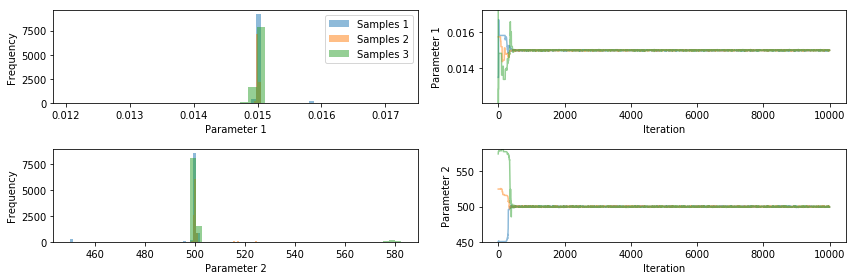

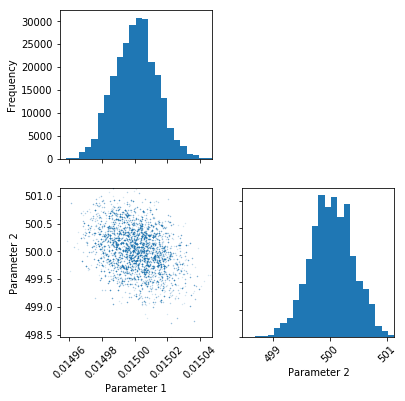

In [30]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

Running...
[-4.89294410e-04  4.52837567e+02]
-inf


[-7.29774791e-03  5.26154564e+02]
-inf


[3.72500253e-02 5.75595399e+02]
-inf


[3.41862040e-02 4.49482398e+02]
-inf


[2.04074746e-02 5.23078745e+02]
-inf


[2.84021537e-02 5.70811518e+02]
-inf


[7.21000669e-03 4.49348627e+02]
-inf


[1.10335318e-02 5.25552681e+02]
-68961.1171875


[9.40426951e-03 5.75301757e+02]
-inf


[8.40770557e-03 4.52524970e+02]
-inf


[6.19971595e-03 5.22205425e+02]
-inf


[2.11662928e-03 5.76265521e+02]
-inf


[4.63606271e-03 4.49248013e+02]
-inf


[2.77793899e-02 5.26399260e+02]
-inf


[2.35261758e-02 5.73276033e+02]
-inf


[1.44316602e-02 4.47258841e+02]
-15962.205078125
accepted


[2.24851010e-02 5.24999027e+02]
-inf


[1.69132638e-02 5.80086570e+02]
-52001.81640625
accepted


[1.80015191e-02 4.46002194e+02]
-21768.68359375


[2.95958958e-02 5.22861678e+02]
-inf


[2.50005816e-02 5.80484463e+02]
-inf


[1.67259981e-02 4.44278624e+02]
-14616.15625
accepted


[4.38016790e-03 5.27313028e+02]
-inf


[9.758667

[1.47419719e-02 4.46566945e+02]
-14162.5859375


[3.21801627e-02 5.17085123e+02]
-inf


[2.79164301e-02 5.75958316e+02]
-inf


[2.33142656e-02 4.42836830e+02]
-inf


[2.83693594e-02 5.20110646e+02]
-inf


[2.03543494e-02 5.73957598e+02]
-inf


[1.56628650e-02 4.45544348e+02]
-12020.53515625


[2.68003137e-02 5.23598394e+02]
-inf


[1.41837172e-02 5.77489411e+02]
-21322.955078125


[2.02725411e-02 4.43628869e+02]
-inf


[1.85075574e-03 5.17944400e+02]
-inf


[-1.21132374e-03  5.75863065e+02]
-inf


[1.72245463e-02 4.47812911e+02]
-15990.490234375


[1.64138859e-02 5.16796986e+02]
-10149.265625


[2.91567892e-02 5.74704068e+02]
-inf


[2.53786362e-02 4.47916123e+02]
-inf


[3.30251538e-02 5.18911713e+02]
-inf


[2.73986344e-02 5.71656449e+02]
-inf


[3.75346241e-02 4.50016818e+02]
-inf


[3.07531112e-02 5.20130509e+02]
-inf


[1.59592796e-04 5.74399078e+02]
-inf


[1.19981004e-02 4.48053630e+02]
-59828.15625


[8.45475856e-03 5.19954664e+02]
-inf


[4.86644177e-02 5.72377967e+02]
-inf




[1.53953850e-02 4.47541779e+02]
-11622.91796875


[1.46819851e-02 5.20661500e+02]
-2537.4140625
accepted


[1.40451165e-02 5.72079357e+02]
-18299.671875
accepted


[1.58402272e-02 4.47985462e+02]
-11050.033203125
accepted


[1.50007472e-02 5.20641084e+02]
-2884.32421875


[1.40614200e-02 5.72014396e+02]
-18291.8359375
accepted


[1.57699749e-02 4.47998491e+02]
-11032.986328125
accepted


[1.44016575e-02 5.20651041e+02]
-2998.9375


[1.41453496e-02 5.71997421e+02]
-18509.94140625


[1.56411961e-02 4.47551353e+02]
-11331.974609375


[1.45322870e-02 5.20626637e+02]
-2653.0546875


[1.41606884e-02 5.72079672e+02]
-18538.15625


[1.59347519e-02 4.48157338e+02]
-11136.486328125


[1.49252774e-02 5.20664875e+02]
-2752.2734375


[1.42781241e-02 5.72092074e+02]
-18647.935546875


[1.58102185e-02 4.48118632e+02]
-10990.7421875
accepted


[1.48317083e-02 5.20707687e+02]
-2673.04296875


[1.39202908e-02 5.72036203e+02]
-18423.001953125


[1.58156663e-02 4.48343036e+02]
-10907.326171875
accepted




[1.57464795e-02 4.73045051e+02]
-3881.8828125


[1.46226237e-02 5.19278973e+02]
-2357.2109375
accepted


[1.32934997e-02 5.33362685e+02]
-11555.533203125


[1.65330215e-02 4.80046501e+02]
-6488.6328125


[1.46254363e-02 5.19203262e+02]
-2348.98046875
accepted


[1.35788751e-02 5.51376656e+02]
-12343.578125


[1.46287117e-02 5.04569505e+02]
-1579.6405029296875


[1.46224684e-02 5.19217250e+02]
-2351.0859375


[1.33169641e-02 5.36231050e+02]
-11554.66015625


[1.40158753e-02 5.19245881e+02]
-4221.80859375


[1.46118598e-02 5.19173258e+02]
-2349.2578125
accepted


[1.30514808e-02 5.19711881e+02]
-14131.859375


[1.65468110e-02 4.73734756e+02]
-7431.97265625


[1.46169594e-02 5.19213793e+02]
-2352.0234375


[1.34621689e-02 5.41446930e+02]
-11086.89453125
accepted


[1.45622819e-02 4.96664655e+02]
-1909.6912841796875


[1.46425178e-02 5.19396018e+02]
-2363.328125


[1.34827106e-02 5.42568542e+02]
-11099.5546875


[1.72543804e-02 4.52847829e+02]
-14854.591796875


[1.45873749e-02 5.18943428e

[1.42980853e-02 5.21208804e+02]
-3580.921875


[1.45802474e-02 5.10099880e+02]
-1695.9061279296875


[1.48122466e-02 4.94484808e+02]
-1660.7303466796875


[1.46314877e-02 5.11675804e+02]
-1665.6951904296875


[1.47695257e-02 5.02253447e+02]
-1403.6873779296875
accepted


[1.59352812e-02 4.75381949e+02]
-4089.89453125


[1.49097143e-02 5.05615301e+02]
-1363.3944091796875


[1.47776835e-02 4.94196751e+02]
-1767.3553466796875


[1.48700710e-02 4.97041487e+02]
-1771.2381591796875


[1.47677692e-02 5.07982778e+02]
-1317.3045654296875


[1.46366185e-02 5.08605380e+02]
-1542.2108154296875


[1.48618494e-02 4.94479443e+02]
-1467.0311279296875


[1.48711070e-02 5.04663369e+02]
-1345.2420654296875


[1.48706557e-02 4.99099398e+02]
-1712.1131591796875


[1.44736266e-02 5.03530435e+02]
-2073.07421875


[1.47364244e-02 5.08727379e+02]
-1406.8709716796875


[1.47275737e-02 5.08545392e+02]
-1410.7811279296875


[1.42603457e-02 5.16166164e+02]
-2972.8828125


[1.47165204e-02 5.09671246e+02]
-1469.0467

[1.48534112e-02 5.05063130e+02]
-1333.1248779296875


[1.49697188e-02 4.96377498e+02]
-1328.1951904296875


[1.48238539e-02 5.06857274e+02]
-1283.9217529296875


[1.48499236e-02 5.04839500e+02]
-1331.8280029296875


[1.50719541e-02 4.87833340e+02]
-1657.2811279296875


[1.47521009e-02 5.09170498e+02]
-1405.6170654296875


[1.49088629e-02 5.02494729e+02]
-1446.1873779296875


[1.50444092e-02 4.90561509e+02]
-1569.9842529296875


[1.48595190e-02 5.06733018e+02]
-1298.9998779296875


[1.48393029e-02 5.06583019e+02]
-1290.5350341796875


[1.47975193e-02 5.00143791e+02]
-1546.6873779296875


[1.48422068e-02 5.07026450e+02]
-1282.7498779296875


[1.47186058e-02 5.07887405e+02]
-1396.5780029296875


[1.47905174e-02 4.99536243e+02]
-1611.3631591796875


[1.48405697e-02 5.07272610e+02]
-1279.8319091796875
accepted


[1.48008379e-02 5.07037710e+02]
-1285.3084716796875
accepted


[1.51496647e-02 4.87046777e+02]
-1703.2889404296875


[1.48409705e-02 5.06822908e+02]
-1284.5233154296875


[1.4809500

[1.48269929e-02 5.07080504e+02]
-1279.4569091796875
accepted


[1.48181847e-02 5.07182805e+02]
-1279.0428466796875


[1.49585786e-02 4.94389263e+02]
-1269.9998779296875


[1.48179364e-02 5.06706408e+02]
-1287.8905029296875


[1.48402349e-02 5.07292760e+02]
-1279.6209716796875


[1.49632057e-02 4.94208785e+02]
-1258.5311279296875


[1.48293881e-02 5.07137797e+02]
-1279.2342529296875
accepted


[1.48378192e-02 5.06773400e+02]
-1285.6287841796875


[1.49551612e-02 4.94162693e+02]
-1268.1717529296875


[1.48164093e-02 5.07533717e+02]
-1281.6600341796875


[1.48222574e-02 5.07323575e+02]
-1278.6678466796875
accepted


[1.5020685e-02 4.9113339e+02]
-1520.7850341796875


[1.48329327e-02 5.07110645e+02]
-1280.0115966796875


[1.48335062e-02 5.06943182e+02]
-1282.3123779296875


[1.49734746e-02 4.93624242e+02]
-1239.9334716796875
accepted


[1.48162953e-02 5.07216053e+02]
-1278.8748779296875
accepted


[1.48370048e-02 5.07716734e+02]
-1286.3514404296875


[1.49105901e-02 4.95737047e+02]
-1413.3

[1.48356536e-02 5.07283802e+02]
-1278.5155029296875
accepted


[1.48194784e-02 5.07502902e+02]
-1280.1990966796875
accepted


[1.49602734e-02 4.93651024e+02]
-1249.3631591796875


[1.48273650e-02 5.07436716e+02]
-1279.5233154296875
accepted


[1.48241159e-02 5.07490628e+02]
-1280.2537841796875
accepted


[1.49681500e-02 4.93633525e+02]
-1240.4217529296875
accepted


[1.48350118e-02 5.07541674e+02]
-1281.8787841796875


[1.48292990e-02 5.07266825e+02]
-1278.3123779296875
accepted


[1.49866014e-02 4.93075965e+02]
-1270.2225341796875


[1.48369940e-02 5.07385858e+02]
-1278.8670654296875
accepted


[1.48353769e-02 5.07123290e+02]
-1280.2108154296875


[1.49754450e-02 4.93686756e+02]
-1240.4530029296875
accepted


[1.48418551e-02 5.07560588e+02]
-1284.4178466796875


[1.48365819e-02 5.07310840e+02]
-1278.4100341796875
accepted


[1.49890299e-02 4.93408511e+02]
-1246.2420654296875


[1.48396848e-02 5.07403506e+02]
-1280.2420654296875


[1.48531809e-02 5.07166672e+02]
-1289.9725341796875


[

[1.48464924e-02 5.07408108e+02]
-1285.2225341796875


[1.48148712e-02 5.07148436e+02]
-1279.3280029296875


[1.49745585e-02 4.93668498e+02]
-1240.1483154296875
accepted


[1.4836843e-02 5.0749545e+02]
-1281.3201904296875


[1.47927604e-02 5.07410194e+02]
-1290.7694091796875


[1.49810000e-02 4.93671784e+02]
-1242.5506591796875


[1.48410376e-02 5.07071416e+02]
-1281.9256591796875


[1.48175072e-02 5.07202166e+02]
-1278.9686279296875
accepted


[1.49762339e-02 4.93698438e+02]
-1240.7498779296875
accepted


[1.48447234e-02 5.07347417e+02]
-1283.4100341796875


[1.48161863e-02 5.07049175e+02]
-1280.3865966796875


[1.49794392e-02 4.93621071e+02]
-1242.0311279296875


[1.48449592e-02 5.07240388e+02]
-1283.1248779296875


[1.4809306e-02 5.0722336e+02]
-1279.4100341796875


[1.49823645e-02 4.93653909e+02]
-1243.0975341796875


[1.48414321e-02 5.07344156e+02]
-1280.8084716796875


[1.48189173e-02 5.07315039e+02]
-1278.7655029296875
accepted


[1.49773322e-02 4.93666339e+02]
-1241.191284179687

[1.48201182e-02 5.06968029e+02]
-1281.2108154296875


[1.49673233e-02 4.93397485e+02]
-1243.5936279296875


[1.48323186e-02 5.07714545e+02]
-1285.1131591796875


[1.48147849e-02 5.06825930e+02]
-1284.5076904296875


[1.49730065e-02 4.93679333e+02]
-1239.9022216796875
accepted


[1.47886502e-02 5.06761252e+02]
-1300.9217529296875


[1.48232966e-02 5.07138042e+02]
-1279.0584716796875
accepted


[1.49762822e-02 4.93603314e+02]
-1240.8748779296875


[1.48395924e-02 5.07028831e+02]
-1281.8201904296875


[1.48199700e-02 5.07246488e+02]
-1278.6951904296875
accepted


[1.49685128e-02 4.93772965e+02]
-1241.9061279296875
accepted


[1.48303983e-02 5.06941401e+02]
-1282.2069091796875


[1.48202107e-02 5.07067721e+02]
-1279.5155029296875


[1.49726056e-02 4.93807608e+02]
-1241.3280029296875
accepted


[1.48471591e-02 5.07243577e+02]
-1284.8162841796875


[1.48203575e-02 5.07267432e+02]
-1278.6170654296875
accepted


[1.49715362e-02 4.93979366e+02]
-1243.4569091796875


[1.48584844e-02 5.07168958e+

[1.48230155e-02 5.06917669e+02]
-1282.3553466796875


[1.48259410e-02 5.07718002e+02]
-1283.3240966796875


[1.49751336e-02 4.93560637e+02]
-1240.4764404296875


[1.48319037e-02 5.07005301e+02]
-1280.9725341796875


[1.48282445e-02 5.07563370e+02]
-1281.1873779296875


[1.49773858e-02 4.93606017e+02]
-1241.3045654296875


[1.48251365e-02 5.07087160e+02]
-1279.2498779296875
accepted


[1.48369022e-02 5.07743924e+02]
-1286.9608154296875


[1.49704083e-02 4.93711958e+02]
-1240.8045654296875
accepted


[1.48104585e-02 5.06578336e+02]
-1291.6717529296875


[1.48474322e-02 5.07486534e+02]
-1287.1092529296875


[1.49687560e-02 4.93624601e+02]
-1240.1951904296875
accepted


[1.48059566e-02 5.06752427e+02]
-1287.4334716796875


[1.48298780e-02 5.07286128e+02]
-1278.2225341796875
accepted


[1.49755526e-02 4.93745231e+02]
-1240.7498779296875


[1.48243135e-02 5.06999573e+02]
-1280.3865966796875


[1.48235271e-02 5.07238844e+02]
-1278.6639404296875


[1.49703041e-02 4.93570679e+02]
-1239.99206542

[1.48432396e-02 5.07302826e+02]
-1281.9334716796875
accepted


[1.48650429e-02 5.07568710e+02]
-1305.8905029296875


[1.49668059e-02 4.93859518e+02]
-1245.4959716796875


[1.48657025e-02 5.07536009e+02]
-1306.3787841796875


[1.48253732e-02 5.07218218e+02]
-1278.6405029296875
accepted


[1.49702995e-02 4.93919266e+02]
-1243.0662841796875


[1.48553242e-02 5.07213784e+02]
-1292.5701904296875


[1.48112670e-02 5.07514749e+02]
-1283.4686279296875


[1.49636195e-02 4.93523812e+02]
-1241.8865966796875


[1.48242529e-02 5.07231157e+02]
-1278.6170654296875
accepted


[1.48352301e-02 5.07493187e+02]
-1280.8358154296875


[1.49627483e-02 4.93764840e+02]
-1248.7381591796875


[1.48324700e-02 5.07371056e+02]
-1278.2537841796875
accepted


[1.48476913e-02 5.07278827e+02]
-1285.2498779296875


[1.49666297e-02 4.93794259e+02]
-1244.1951904296875


[1.47980863e-02 5.07518666e+02]
-1289.1639404296875


[1.48312020e-02 5.07427824e+02]
-1279.1365966796875


[1.49619576e-02 4.93834282e+02]
-1251.42175292

[1.48149394e-02 5.07656853e+02]
-1284.9022216796875


[1.48137207e-02 5.07614664e+02]
-1284.5545654296875


[1.49699823e-02 4.93275282e+02]
-1250.6795654296875


[1.48200860e-02 5.07496565e+02]
-1280.1522216796875


[1.48004464e-02 5.07342863e+02]
-1285.2889404296875


[1.49805528e-02 4.93707797e+02]
-1242.3475341796875


[1.48317726e-02 5.07241826e+02]
-1278.4100341796875
accepted


[1.48240067e-02 5.07213064e+02]
-1278.6990966796875
accepted


[1.49649666e-02 4.93325198e+02]
-1248.2342529296875


[1.48146639e-02 5.07427528e+02]
-1280.1405029296875


[1.48150019e-02 5.07365958e+02]
-1278.9803466796875
accepted


[1.49658000e-02 4.93540644e+02]
-1240.0467529296875
accepted


[1.48517214e-02 5.07476215e+02]
-1290.1092529296875


[1.48085404e-02 5.07094809e+02]
-1280.3436279296875


[1.49690799e-02 4.93486640e+02]
-1240.1287841796875


[1.48393417e-02 5.07108872e+02]
-1280.9451904296875


[1.48123896e-02 5.07782227e+02]
-1288.6522216796875


[1.49675004e-02 4.93489247e+02]
-1240.12487792

[1.48240993e-02 5.07369787e+02]
-1278.8787841796875
accepted


[1.48424806e-02 5.07376321e+02]
-1281.8631591796875


[1.49720586e-02 4.93305483e+02]
-1248.6600341796875


[1.48391917e-02 5.07247878e+02]
-1279.4139404296875
accepted


[1.48289111e-02 5.07178700e+02]
-1278.7342529296875
accepted


[1.49845677e-02 4.93529283e+02]
-1244.0701904296875


[1.48253363e-02 5.07201441e+02]
-1278.6990966796875
accepted


[1.48346232e-02 5.06754713e+02]
-1286.2147216796875


[1.49830629e-02 4.93531996e+02]
-1243.5233154296875


[1.47894680e-02 5.06912995e+02]
-1296.2108154296875


[1.48040476e-02 5.07017160e+02]
-1283.6600341796875


[1.49616802e-02 4.93643924e+02]
-1247.3006591796875


[1.48125241e-02 5.07550798e+02]
-1283.6717529296875


[1.48028352e-02 5.07120911e+02]
-1283.3983154296875


[1.49708770e-02 4.93405193e+02]
-1242.7264404296875


[1.48481986e-02 5.07131622e+02]
-1285.1834716796875


[1.48318990e-02 5.07113933e+02]
-1279.8123779296875


[1.49763810e-02 4.93626811e+02]
-1240.87487792



[1.48004663e-02 5.07747172e+02]
-1293.0155029296875


[1.48450083e-02 5.07170757e+02]
-1282.9998779296875


[1.49786553e-02 4.93926434e+02]
-1243.3905029296875
accepted


[1.48146106e-02 5.07108913e+02]
-1279.6209716796875
accepted


[1.47954895e-02 5.06888440e+02]
-1289.7537841796875


[1.49724812e-02 4.93945243e+02]
-1242.8944091796875
accepted


[1.48069389e-02 5.06965530e+02]
-1283.0584716796875


[1.48421881e-02 5.06958913e+02]
-1283.0545654296875


[1.49614400e-02 4.93699615e+02]
-1248.9334716796875


[1.47900776e-02 5.07208112e+02]
-1291.3905029296875


[1.48093839e-02 5.07394267e+02]
-1281.9139404296875


[1.49822175e-02 4.94064503e+02]
-1245.6014404296875


[1.47902334e-02 5.06487114e+02]
-1307.0076904296875


[1.48349173e-02 5.07062293e+02]
-1280.8201904296875


[1.49737564e-02 4.93776148e+02]
-1240.8826904296875
accepted


[1.48356421e-02 5.06999898e+02]
-1281.5897216796875


[1.48146647e-02 5.07485254e+02]
-1281.3983154296875


[1.49791054e-02 4.93487975e+02]
-1242.089721

[1.49690868e-02 4.93033153e+02]
-1266.6014404296875


[1.48708751e-02 5.07945829e+02]
-1316.7694091796875


[1.48367224e-02 5.06925012e+02]
-1282.7733154296875


[1.49795415e-02 4.93613245e+02]
-1242.0740966796875


[1.48220560e-02 5.07442143e+02]
-1279.6834716796875
accepted


[1.47972754e-02 5.06901149e+02]
-1288.6092529296875


[1.49720796e-02 4.93597149e+02]
-1239.9920654296875
accepted


[1.48435606e-02 5.07104698e+02]
-1282.7147216796875


[1.47795458e-02 5.07040074e+02]
-1305.5428466796875


[1.49744471e-02 4.93761939e+02]
-1240.7889404296875
accepted


[1.48377979e-02 5.08076015e+02]
-1294.2576904296875


[1.48401270e-02 5.07165952e+02]
-1280.4686279296875


[1.49623382e-02 4.93560537e+02]
-1244.4959716796875


[1.48057699e-02 5.07290948e+02]
-1282.0467529296875
accepted


[1.48024923e-02 5.07159982e+02]
-1283.2615966796875


[1.49856933e-02 4.93592470e+02]
-1244.4139404296875


[1.47824104e-02 5.06823888e+02]
-1306.8201904296875


[1.48272484e-02 5.07271656e+02]
-1278.39050292

[1.48284291e-02 5.07179322e+02]
-1278.6990966796875
accepted


[1.48005237e-02 5.07641332e+02]
-1290.7147216796875


[1.49494810e-02 4.93424011e+02]
-1261.6131591796875


[1.48474988e-02 5.07357348e+02]
-1285.6405029296875


[1.48682409e-02 5.07447052e+02]
-1308.9764404296875


[1.49696702e-02 4.93353403e+02]
-1245.9842529296875


[1.48333213e-02 5.07699610e+02]
-1285.0858154296875


[1.48713150e-02 5.07614589e+02]
-1314.0936279296875


[1.49612277e-02 4.93460161e+02]
-1243.9959716796875


[1.48265220e-02 5.06916316e+02]
-1282.6053466796875


[1.48425281e-02 5.07330921e+02]
-1281.5740966796875


[1.49649408e-02 4.93692766e+02]
-1244.0975341796875


[1.48101589e-02 5.06957377e+02]
-1282.9686279296875


[1.48356508e-02 5.07936873e+02]
-1290.7264404296875


[1.49863676e-02 4.93671143e+02]
-1244.6053466796875


[1.48345861e-02 5.07091776e+02]
-1280.4334716796875


[1.48421691e-02 5.07342467e+02]
-1281.3865966796875
accepted


[1.49697934e-02 4.93467181e+02]
-1240.1287841796875
accepted


[

[1.48266701e-02 5.07632146e+02]
-1281.8162841796875


[1.48171170e-02 5.07840638e+02]
-1287.8592529296875


[1.49711262e-02 4.93750898e+02]
-1241.0819091796875
accepted


[1.48186301e-02 5.07411794e+02]
-1279.2615966796875
accepted


[1.48518074e-02 5.07553814e+02]
-1291.4373779296875


[1.49764286e-02 4.94081385e+02]
-1245.0115966796875


[1.47994593e-02 5.07226956e+02]
-1285.3319091796875


[1.48049239e-02 5.07614274e+02]
-1288.3006591796875


[1.49727021e-02 4.93920914e+02]
-1242.5545654296875


[1.48041464e-02 5.07651582e+02]
-1289.3748779296875


[1.48169959e-02 5.07158945e+02]
-1279.1678466796875


[1.49693554e-02 4.93716591e+02]
-1241.1092529296875
accepted


[1.47882199e-02 5.07102680e+02]
-1293.5584716796875


[1.47992632e-02 5.06995004e+02]
-1286.6092529296875


[1.49656572e-02 4.93456022e+02]
-1240.2303466796875
accepted


[1.48431076e-02 5.07255835e+02]
-1281.7303466796875


[1.48031885e-02 5.07721893e+02]
-1291.2928466796875


[1.49678595e-02 4.93041363e+02]
-1265.59753417

[1.48224699e-02 5.07061083e+02]
-1279.4373779296875


[1.48466711e-02 5.06996289e+02]
-1284.4569091796875


[1.49613443e-02 4.93857591e+02]
-1252.8045654296875


[1.48270802e-02 5.07509161e+02]
-1280.5350341796875


[1.48105996e-02 5.07476481e+02]
-1282.9100341796875


[1.49650020e-02 4.93880995e+02]
-1248.4022216796875


[1.48172273e-02 5.07632479e+02]
-1283.4217529296875


[1.48374412e-02 5.06837907e+02]
-1284.4100341796875


[1.49738324e-02 4.93778111e+02]
-1240.8905029296875
accepted


[1.48513356e-02 5.06980174e+02]
-1287.6795654296875


[1.48216391e-02 5.07383891e+02]
-1279.0780029296875
accepted


[1.49785521e-02 4.93882264e+02]
-1242.8240966796875
accepted


[1.48383533e-02 5.07141637e+02]
-1280.4373779296875


[1.47962573e-02 5.07111005e+02]
-1287.2733154296875


[1.49912475e-02 4.93733138e+02]
-1246.3319091796875


[1.48516410e-02 5.07451051e+02]
-1289.6522216796875


[1.48459633e-02 5.07382400e+02]
-1284.6131591796875


[1.49665361e-02 4.93697469e+02]
-1242.0662841796875
acc


[1.49725915e-02 4.93662436e+02]
-1239.9022216796875
accepted


[1.48279766e-02 5.07433261e+02]
-1279.4412841796875


[1.4861457e-02 5.0740351e+02]
-1300.6014404296875


[1.49656979e-02 4.94571472e+02]
-1264.8592529296875


[1.48230937e-02 5.07047299e+02]
-1279.4998779296875


[1.48047725e-02 5.07183444e+02]
-1281.7537841796875


[1.49601251e-02 4.93298745e+02]
-1251.9217529296875


[1.48252204e-02 5.07310103e+02]
-1278.3006591796875
accepted


[1.48162427e-02 5.07436815e+02]
-1279.7069091796875
accepted


[1.49316994e-02 4.92677314e+02]
-1313.5584716796875


[1.48422233e-02 5.06703251e+02]
-1287.2694091796875


[1.48433835e-02 5.07877845e+02]
-1292.3358154296875


[1.49746748e-02 4.93114747e+02]
-1261.1756591796875


[1.48263121e-02 5.07011306e+02]
-1280.1834716796875


[1.47808981e-02 5.07703349e+02]
-1301.2342529296875


[1.49691014e-02 4.93661072e+02]
-1240.5311279296875


[1.48423825e-02 5.07349057e+02]
-1281.5897216796875


[1.47861332e-02 5.07257798e+02]
-1295.1131591796875


[1

[1.49667380e-02 4.93867038e+02]
-1245.7694091796875


[1.48068448e-02 5.07300831e+02]
-1281.7108154296875


[1.48402127e-02 5.08019365e+02]
-1293.7850341796875


[1.49790696e-02 4.94031830e+02]
-1244.7381591796875


[1.48355829e-02 5.07366784e+02]
-1278.0428466796875
accepted


[1.48538829e-02 5.06821258e+02]
-1291.7147216796875


[1.49654411e-02 4.93558499e+02]
-1240.2537841796875
accepted


[1.48172848e-02 5.07064925e+02]
-1279.9803466796875
accepted


[1.47987492e-02 5.07228336e+02]
-1285.8006591796875


[1.49469039e-02 4.93989934e+02]
-1275.1326904296875


[1.48001615e-02 5.07000562e+02]
-1286.0506591796875


[1.48362028e-02 5.06626562e+02]
-1289.5350341796875


[1.49770085e-02 4.93452091e+02]
-1241.3358154296875


[1.47830258e-02 5.07170329e+02]
-1299.8475341796875


[1.47808574e-02 5.07196557e+02]
-1302.4451904296875


[1.49489486e-02 4.92994397e+02]
-1278.8006591796875


[1.47824018e-02 5.06514908e+02]
-1315.6248779296875


[1.48103966e-02 5.07439222e+02]
-1282.2264404296875


[

[1.48542513e-02 5.07251267e+02]
-1291.3045654296875


[1.48318168e-02 5.06941542e+02]
-1282.2498779296875


[1.49633877e-02 4.93993963e+02]
-1253.2615966796875


[1.48374150e-02 5.07041631e+02]
-1281.3905029296875


[1.48350550e-02 5.07222323e+02]
-1279.1014404296875
accepted


[1.49720505e-02 4.94327839e+02]
-1249.7733154296875


[1.48408234e-02 5.07615128e+02]
-1285.0350341796875


[1.48214522e-02 5.07351758e+02]
-1278.9490966796875
accepted


[1.49765117e-02 4.94798042e+02]
-1257.8826904296875


[1.48275541e-02 5.07241432e+02]
-1278.4647216796875
accepted


[1.48211837e-02 5.07649685e+02]
-1282.1014404296875


[1.49767705e-02 4.93839364e+02]
-1242.0584716796875
accepted


[1.48002800e-02 5.07240888e+02]
-1284.8709716796875


[1.48383038e-02 5.07669041e+02]
-1285.5545654296875


[1.49763788e-02 4.93676375e+02]
-1240.8045654296875
accepted


[1.48147285e-02 5.06725619e+02]
-1287.1248779296875


[1.48321965e-02 5.06927605e+02]
-1282.6444091796875


[1.49854000e-02 4.93970634e+02]
-1244

[1.48516443e-02 5.07223398e+02]
-1288.1951904296875


[1.48324740e-02 5.06892782e+02]
-1283.5233154296875


[1.49585143e-02 4.93470953e+02]
-1247.4803466796875


[1.48458398e-02 5.06933179e+02]
-1284.4686279296875


[1.47699292e-02 5.06893644e+02]
-1320.5272216796875


[1.49707316e-02 4.93663199e+02]
-1240.2108154296875
accepted


[1.48201736e-02 5.06989369e+02]
-1280.8592529296875


[1.48166755e-02 5.07686002e+02]
-1284.7498779296875


[1.49771998e-02 4.93863419e+02]
-1242.4334716796875


[1.48043639e-02 5.06767419e+02]
-1287.3123779296875


[1.47731521e-02 5.07219999e+02]
-1312.3553466796875


[1.49661918e-02 4.93517529e+02]
-1240.1092529296875
accepted


[1.48159830e-02 5.06932894e+02]
-1282.4295654296875


[1.48337665e-02 5.07288862e+02]
-1278.1834716796875
accepted


[1.49723672e-02 4.93424479e+02]
-1241.3865966796875
accepted


[1.48523658e-02 5.07212553e+02]
-1289.0428466796875


[1.48146930e-02 5.07210383e+02]
-1278.7733154296875


[1.49788603e-02 4.93710792e+02]
-1241.69909667

[1.48298223e-02 5.07129561e+02]
-1279.3358154296875
accepted


[1.48601548e-02 5.07241562e+02]
-1298.3944091796875


[1.49936658e-02 4.93466841e+02]
-1247.5819091796875


[1.48282371e-02 5.06725508e+02]
-1287.3905029296875


[1.48502750e-02 5.08008954e+02]
-1299.2264404296875


[1.49813763e-02 4.93541881e+02]
-1242.8436279296875


[1.47993392e-02 5.07106974e+02]
-1285.5389404296875


[1.47881188e-02 5.06842516e+02]
-1299.4530029296875


[1.49723270e-02 4.93598106e+02]
-1239.9608154296875
accepted


[1.48336387e-02 5.07333127e+02]
-1277.8709716796875
accepted


[1.48156250e-02 5.07308628e+02]
-1278.6756591796875
accepted


[1.49787637e-02 4.94011703e+02]
-1244.4530029296875


[1.48633842e-02 5.07057521e+02]
-1301.8709716796875


[1.48042747e-02 5.07038450e+02]
-1283.3358154296875


[1.49622890e-02 4.93257952e+02]
-1252.6326904296875


[1.48148086e-02 5.07063461e+02]
-1280.3631591796875


[1.48168448e-02 5.07786478e+02]
-1286.8319091796875


[1.49587349e-02 4.93696024e+02]
-1252.45300292

[1.48386895e-02 5.07174372e+02]
-1280.1639404296875


[1.48183785e-02 5.06947860e+02]
-1281.8162841796875


[1.49768530e-02 4.93408404e+02]
-1242.9608154296875


[1.48086591e-02 5.07024518e+02]
-1281.7459716796875


[1.48297610e-02 5.07343569e+02]
-1278.0897216796875
accepted


[1.49882922e-02 4.93533118e+02]
-1245.5037841796875


[1.48080730e-02 5.07196933e+02]
-1279.8123779296875


[1.48586149e-02 5.07719752e+02]
-1299.4373779296875


[1.49858296e-02 4.93322565e+02]
-1251.0584716796875


[1.48329898e-02 5.07145761e+02]
-1279.6639404296875
accepted


[1.48376693e-02 5.07330428e+02]
-1278.5662841796875


[1.49809991e-02 4.93397349e+02]
-1244.7264404296875


[1.47969613e-02 5.07080065e+02]
-1287.1561279296875


[1.47971115e-02 5.06882601e+02]
-1288.8983154296875


[1.49628414e-02 4.93186739e+02]
-1256.8514404296875


[1.48191560e-02 5.07407995e+02]
-1279.2069091796875
accepted


[1.48014207e-02 5.07168485e+02]
-1283.7733154296875


[1.49624256e-02 4.93615815e+02]
-1245.6600341796875


[

[1.48307788e-02 5.07241555e+02]
-1278.3787841796875
accepted


[1.48072303e-02 5.07053717e+02]
-1281.4842529296875


[1.49573717e-02 4.93211110e+02]
-1259.0858154296875


[1.47952614e-02 5.07044187e+02]
-1288.4803466796875


[1.47997859e-02 5.07324129e+02]
-1285.6444091796875


[1.49608536e-02 4.93168633e+02]
-1258.1834716796875


[1.48245633e-02 5.07074590e+02]
-1279.2850341796875


[1.48005151e-02 5.07055779e+02]
-1285.3397216796875


[1.49613808e-02 4.93630501e+02]
-1247.4217529296875


[1.48443475e-02 5.06925323e+02]
-1283.9178466796875


[1.48250135e-02 5.07268515e+02]
-1278.4608154296875
accepted


[1.49673391e-02 4.93319451e+02]
-1248.3201904296875


[1.48460446e-02 5.07218395e+02]
-1283.8983154296875


[1.48125871e-02 5.07291914e+02]
-1278.9803466796875
accepted


[1.49646570e-02 4.93397977e+02]
-1243.8553466796875


[1.48259357e-02 5.07596107e+02]
-1281.4061279296875


[1.48521674e-02 5.07480831e+02]
-1290.5545654296875


[1.49750083e-02 4.93593837e+02]
-1240.3983154296875
acc

[1.48449684e-02 5.07507863e+02]
-1285.6873779296875


[1.47993505e-02 5.06873076e+02]
-1287.6678466796875


[1.50031570e-02 4.94037007e+02]
-1250.4881591796875


[1.48141654e-02 5.07263446e+02]
-1278.4530029296875
accepted


[1.48021228e-02 5.07493356e+02]
-1286.9217529296875


[1.49984556e-02 4.94122593e+02]
-1248.5975341796875


[1.47950873e-02 5.07378388e+02]
-1289.0701904296875


[1.48136016e-02 5.07170406e+02]
-1279.0428466796875
accepted


[1.49703482e-02 4.93559905e+02]
-1240.0194091796875
accepted


[1.48204749e-02 5.07118915e+02]
-1279.2694091796875


[1.48207138e-02 5.07570042e+02]
-1280.9490966796875


[1.49681490e-02 4.93652803e+02]
-1240.6756591796875
accepted


[1.48116673e-02 5.07269315e+02]
-1279.0467529296875
accepted


[1.48489979e-02 5.07198133e+02]
-1286.0936279296875


[1.49458148e-02 4.93258992e+02]
-1272.1951904296875


[1.48051719e-02 5.07754037e+02]
-1291.1405029296875


[1.47731686e-02 5.06942780e+02]
-1315.4608154296875


[1.49596658e-02 4.93669361e+02]
-1250

[1.48350349e-02 5.07563080e+02]
-1282.3983154296875


[1.48415795e-02 5.07235917e+02]
-1280.5155029296875
accepted


[1.49736817e-02 4.93547155e+02]
-1239.9998779296875
accepted


[1.48178020e-02 5.07111522e+02]
-1279.3709716796875
accepted


[1.48479844e-02 5.07568427e+02]
-1288.9217529296875


[1.49751034e-02 4.93651004e+02]
-1240.3631591796875
accepted


[1.48396976e-02 5.07017025e+02]
-1281.9959716796875


[1.48897591e-02 5.07543430e+02]
-1335.3787841796875


[1.49723737e-02 4.93607264e+02]
-1239.9608154296875
accepted


[1.48326137e-02 5.07634016e+02]
-1283.4256591796875
accepted


[1.48569263e-02 5.07237003e+02]
-1294.4725341796875


[1.49697730e-02 4.93764293e+02]
-1241.5350341796875


[1.48184451e-02 5.07432161e+02]
-1279.4530029296875
accepted


[1.48218194e-02 5.07615504e+02]
-1281.4764404296875


[1.49756824e-02 4.93445564e+02]
-1240.8514404296875


[1.47998859e-02 5.07489405e+02]
-1287.7850341796875


[1.48278490e-02 5.07352014e+02]
-1278.3514404296875
accepted


[1.4979127

[1.48162820e-02 5.07436052e+02]
-1279.6522216796875
accepted


[1.47988807e-02 5.07225218e+02]
-1285.6834716796875


[1.49802218e-02 4.93049735e+02]
-1269.5584716796875


[1.48103441e-02 5.07176845e+02]
-1278.8905029296875
accepted


[1.47882744e-02 5.07175291e+02]
-1292.9373779296875


[1.49793394e-02 4.94023277e+02]
-1244.6795654296875


[1.47994942e-02 5.06815302e+02]
-1288.1131591796875


[1.48679926e-02 5.07766525e+02]
-1311.4725341796875


[1.49737607e-02 4.93627224e+02]
-1239.9490966796875
accepted


[1.48008410e-02 5.07484115e+02]
-1287.2576904296875


[1.48396003e-02 5.07410933e+02]
-1280.3436279296875


[1.49673550e-02 4.93215852e+02]
-1254.5545654296875


[1.48267276e-02 5.07700337e+02]
-1283.1678466796875


[1.47879668e-02 5.07564971e+02]
-1295.1092529296875


[1.49657851e-02 4.93503345e+02]
-1240.1170654296875
accepted


[1.48003821e-02 5.07354989e+02]
-1285.4334716796875


[1.48155647e-02 5.07294937e+02]
-1278.6326904296875
accepted


[1.49731299e-02 4.93646478e+02]
-1239

[1.47984971e-02 5.07612120e+02]
-1290.9764404296875


[1.48216065e-02 5.07514480e+02]
-1280.4451904296875


[1.49657086e-02 4.93838313e+02]
-1246.4530029296875


[1.47936258e-02 5.07596871e+02]
-1292.7303466796875


[1.48142442e-02 5.07060476e+02]
-1280.4920654296875
accepted


[1.49679867e-02 4.93752355e+02]
-1241.7615966796875


[1.48204173e-02 5.07319285e+02]
-1278.7928466796875
accepted


[1.48335061e-02 5.07119273e+02]
-1279.9725341796875
accepted


[1.49957992e-02 4.93403610e+02]
-1250.5350341796875


[1.48532783e-02 5.07765109e+02]
-1296.0076904296875


[1.48067046e-02 5.07334369e+02]
-1282.2498779296875


[1.49513659e-02 4.94057002e+02]
-1270.7459716796875


[1.48315663e-02 5.06825717e+02]
-1284.9686279296875


[1.48264624e-02 5.07138314e+02]
-1278.9569091796875
accepted


[1.49586803e-02 4.93585357e+02]
-1249.9530029296875


[1.48144035e-02 5.07072257e+02]
-1280.2381591796875


[1.48523382e-02 5.06842960e+02]
-1289.9530029296875


[1.49516061e-02 4.93560142e+02]
-1258.76159667

[1.48171080e-02 5.07393213e+02]
-1279.0272216796875


[1.48376187e-02 5.07213115e+02]
-1279.5740966796875
accepted


[1.49682698e-02 4.93568615e+02]
-1240.0233154296875
accepted


[1.48173299e-02 5.07308130e+02]
-1278.7108154296875
accepted


[1.48547982e-02 5.07647030e+02]
-1295.1600341796875


[1.49690884e-02 4.94127630e+02]
-1248.6912841796875


[1.48144985e-02 5.07228350e+02]
-1278.5780029296875
accepted


[1.48750604e-02 5.07015888e+02]
-1316.3358154296875


[1.49773079e-02 4.93359669e+02]
-1245.8905029296875


[1.48030391e-02 5.07315811e+02]
-1283.6170654296875
accepted


[1.48388582e-02 5.07367206e+02]
-1279.3905029296875
accepted


[1.49659873e-02 4.93263755e+02]
-1251.8319091796875


[1.47822858e-02 5.07200905e+02]
-1300.5701904296875


[1.48123946e-02 5.07638748e+02]
-1285.6365966796875


[1.49668823e-02 4.93309065e+02]
-1248.9998779296875


[1.48299287e-02 5.07107806e+02]
-1279.5780029296875
accepted


[1.48482528e-02 5.07022110e+02]
-1284.9373779296875


[1.49648736e-02 4.9

[1.48107771e-02 5.07101656e+02]
-1279.9998779296875


[1.48286600e-02 5.06943683e+02]
-1282.0155029296875


[1.49797279e-02 4.92878338e+02]
-1281.6561279296875


[1.47979268e-02 5.07576490e+02]
-1290.4881591796875


[1.48771403e-02 5.07572842e+02]
-1320.4217529296875


[1.49753564e-02 4.93322264e+02]
-1247.5936279296875


[1.47924674e-02 5.06915954e+02]
-1292.4959716796875


[1.47894032e-02 5.07341242e+02]
-1292.5819091796875


[1.49592124e-02 4.93398056e+02]
-1249.0819091796875


[1.48210327e-02 5.07247590e+02]
-1278.6678466796875
accepted


[1.48573126e-02 5.07605928e+02]
-1296.7420654296875


[1.49604374e-02 4.93289393e+02]
-1251.9139404296875


[1.48495293e-02 5.07467771e+02]
-1288.3865966796875


[1.48556110e-02 5.07463209e+02]
-1293.2459716796875


[1.49762982e-02 4.93740742e+02]
-1240.8123779296875
accepted


[1.48235598e-02 5.07061085e+02]
-1279.4530029296875
accepted


[1.48448290e-02 5.07054683e+02]
-1283.5506591796875


[1.49776731e-02 4.93839510e+02]
-1242.1639404296875


[

[1.48305218e-02 5.07110210e+02]
-1279.6912841796875
accepted


[1.48076101e-02 5.06991289e+02]
-1282.4842529296875
accepted


[1.49728406e-02 4.93355712e+02]
-1245.4881591796875


[1.48593823e-02 5.07052207e+02]
-1297.1639404296875


[1.47963607e-02 5.07229153e+02]
-1287.3748779296875


[1.49736067e-02 4.93483211e+02]
-1240.0780029296875
accepted


[1.48237736e-02 5.07214097e+02]
-1278.7264404296875
accepted


[1.48282675e-02 5.07202818e+02]
-1278.6170654296875
accepted


[1.49732093e-02 4.93382370e+02]
-1243.8592529296875


[1.48325661e-02 5.06855698e+02]
-1284.3436279296875


[1.47783659e-02 5.07110635e+02]
-1306.3670654296875


[1.49835724e-02 4.93767163e+02]
-1243.3905029296875


[1.48476086e-02 5.06926400e+02]
-1285.1053466796875


[1.48110455e-02 5.07239042e+02]
-1278.8787841796875
accepted


[1.49768374e-02 4.93926366e+02]
-1243.1639404296875


[1.48339622e-02 5.07148112e+02]
-1279.7264404296875
accepted


[1.48120486e-02 5.07192243e+02]
-1278.6951904296875
accepted


[1.4980250

[1.48124133e-02 5.07531723e+02]
-1283.3358154296875


[1.48305153e-02 5.07392473e+02]
-1278.7069091796875
accepted


[1.49734036e-02 4.94240333e+02]
-1246.5311279296875


[1.48505936e-02 5.06880807e+02]
-1287.9412841796875


[1.48405258e-02 5.07225793e+02]
-1280.0233154296875
accepted


[1.49549080e-02 4.93398676e+02]
-1254.8123779296875


[1.48132336e-02 5.06652568e+02]
-1289.3944091796875


[1.48400815e-02 5.07315453e+02]
-1279.5819091796875
accepted


[1.49591350e-02 4.93473784e+02]
-1246.7108154296875


[1.47744152e-02 5.07145605e+02]
-1311.2342529296875


[1.48628364e-02 5.07250464e+02]
-1301.6522216796875


[1.49825836e-02 4.93673759e+02]
-1243.1639404296875


[1.48212475e-02 5.07289072e+02]
-1278.4608154296875


[1.47984162e-02 5.07511206e+02]
-1288.8944091796875


[1.49680799e-02 4.93833762e+02]
-1243.1912841796875
accepted


[1.48168662e-02 5.07373135e+02]
-1278.9686279296875
accepted


[1.48528533e-02 5.07610733e+02]
-1293.1326904296875


[1.49645850e-02 4.93855245e+02]
-1248

[1.48058271e-02 5.06555243e+02]
-1292.3787841796875


[1.47999247e-02 5.06899516e+02]
-1287.0858154296875


[1.49649583e-02 4.93980379e+02]
-1250.8280029296875


[1.48682241e-02 5.07513334e+02]
-1309.2459716796875


[1.48191405e-02 5.07204451e+02]
-1278.9334716796875
accepted


[1.49755331e-02 4.94023130e+02]
-1244.1522216796875


[1.48454394e-02 5.06827511e+02]
-1285.4256591796875


[1.48239215e-02 5.06908111e+02]
-1282.6483154296875


[1.49703577e-02 4.94180435e+02]
-1248.2264404296875


[1.48243846e-02 5.06705753e+02]
-1288.1483154296875


[1.48178567e-02 5.07498657e+02]
-1280.2694091796875


[1.49872683e-02 4.93819045e+02]
-1244.7381591796875


[1.48624964e-02 5.07258312e+02]
-1301.2498779296875


[1.48470001e-02 5.07043617e+02]
-1284.3905029296875


[1.49796096e-02 4.93781218e+02]
-1241.8905029296875
accepted


[1.48091130e-02 5.07363497e+02]
-1281.5780029296875


[1.48106238e-02 5.06915055e+02]
-1283.5897216796875


[1.49651036e-02 4.93864005e+02]
-1247.8709716796875


[1.4830861

[1.47862903e-02 5.06941577e+02]
-1299.4920654296875


[1.48215699e-02 5.07279313e+02]
-1278.5194091796875
accepted


[1.49811320e-02 4.93855089e+02]
-1242.8397216796875


[1.47976697e-02 5.07679299e+02]
-1292.7694091796875


[1.48248287e-02 5.07159375e+02]
-1278.9490966796875


[1.50081980e-02 4.94262362e+02]
-1252.0780029296875


[1.47819796e-02 5.07186657e+02]
-1301.1170654296875


[1.48529870e-02 5.07517697e+02]
-1291.7264404296875


[1.49813121e-02 4.93417422e+02]
-1243.6170654296875


[1.48011142e-02 5.07386015e+02]
-1285.5272216796875


[1.48225838e-02 5.07066091e+02]
-1279.3983154296875
accepted


[1.49653203e-02 4.93550320e+02]
-1240.2108154296875
accepted


[1.47995206e-02 5.06634710e+02]
-1291.4217529296875


[1.48263870e-02 5.07186404e+02]
-1278.7576904296875
accepted


[1.49717228e-02 4.94117269e+02]
-1244.9022216796875


[1.47643563e-02 5.07408666e+02]
-1322.3826904296875


[1.48016768e-02 5.07431141e+02]
-1285.9451904296875


[1.49587498e-02 4.93113031e+02]
-1261.78503417

[1.47842599e-02 5.06681337e+02]
-1308.6326904296875


[1.48724482e-02 5.07950734e+02]
-1318.7615966796875


[1.49858598e-02 4.93456027e+02]
-1244.6522216796875
accepted


[1.48333701e-02 5.07620330e+02]
-1283.2889404296875


[1.48121890e-02 5.07555577e+02]
-1283.9295654296875


[1.49908266e-02 4.93548858e+02]
-1246.3983154296875


[1.48103797e-02 5.07282542e+02]
-1279.8358154296875
accepted


[1.47958256e-02 5.07226286e+02]
-1287.6912841796875


[1.50083903e-02 4.93618951e+02]
-1253.8436279296875


[1.47968325e-02 5.07087514e+02]
-1287.1873779296875


[1.48123214e-02 5.07173854e+02]
-1278.9022216796875
accepted


[1.49933311e-02 4.93068274e+02]
-1273.4490966796875


[1.47859224e-02 5.07228315e+02]
-1295.6405029296875


[1.48302472e-02 5.07290976e+02]
-1278.1756591796875
accepted


[1.49739386e-02 4.92876628e+02]
-1279.4959716796875


[1.47959478e-02 5.06963425e+02]
-1288.8397216796875


[1.48445893e-02 5.07501971e+02]
-1285.3084716796875


[1.49481171e-02 4.93385644e+02]
-1264.81237792

[1.48645185e-02 5.08040095e+02]
-1309.9022216796875


[1.49770186e-02 4.93648708e+02]
-1241.0623779296875
accepted


[1.48100257e-02 5.07362045e+02]
-1281.1717529296875
accepted


[1.48595207e-02 5.07707271e+02]
-1300.4451904296875


[1.49556893e-02 4.93679227e+02]
-1256.1170654296875


[1.48313726e-02 5.07441566e+02]
-1279.3006591796875
accepted


[1.48464103e-02 5.06932779e+02]
-1284.6522216796875


[1.49609827e-02 4.93094897e+02]
-1262.6092529296875


[1.48419192e-02 5.07719486e+02]
-1287.9842529296875


[1.48234286e-02 5.07492335e+02]
-1280.2381591796875


[1.49898285e-02 4.93768991e+02]
-1245.7694091796875


[1.49046800e-02 5.07724219e+02]
-1357.5897216796875


[1.48466802e-02 5.07888320e+02]
-1294.4764404296875


[1.49680168e-02 4.93977704e+02]
-1246.6600341796875


[1.48493631e-02 5.07622939e+02]
-1290.7850341796875


[1.48415872e-02 5.07003116e+02]
-1282.6092529296875


[1.49688746e-02 4.93609879e+02]
-1240.0701904296875
accepted


[1.48310921e-02 5.07209121e+02]
-1278.68347167

[1.49663185e-02 4.94014395e+02]
-1249.7889404296875


[1.48722129e-02 5.07299995e+02]
-1313.1795654296875


[1.48218318e-02 5.07131905e+02]
-1279.1561279296875
accepted


[1.49665574e-02 4.93654135e+02]
-1241.0272216796875
accepted


[1.48041550e-02 5.07173155e+02]
-1282.1756591796875


[1.48335014e-02 5.06595920e+02]
-1290.4803466796875


[1.49760932e-02 4.93361219e+02]
-1245.4998779296875


[1.48252195e-02 5.07214218e+02]
-1278.6405029296875


[1.48139079e-02 5.07223057e+02]
-1278.6287841796875
accepted


[1.49684314e-02 4.93639298e+02]
-1240.4725341796875
accepted


[1.48320398e-02 5.07421594e+02]
-1279.0037841796875


[1.47983807e-02 5.07205463e+02]
-1285.9100341796875


[1.49658593e-02 4.93689524e+02]
-1242.7850341796875


[1.48418121e-02 5.07404673e+02]
-1281.7069091796875


[1.48350127e-02 5.07526543e+02]
-1281.5623779296875


[1.49659139e-02 4.93716639e+02]
-1243.3123779296875


[1.48109752e-02 5.07451987e+02]
-1282.2420654296875


[1.48155502e-02 5.07138163e+02]
-1279.34362792

[1.48174828e-02 5.07631610e+02]
-1283.2615966796875


[1.47876915e-02 5.06744761e+02]
-1302.5506591796875


[1.49739093e-02 4.93985296e+02]
-1243.4334716796875
accepted


[1.48414920e-02 5.07385067e+02]
-1281.1209716796875


[1.47962526e-02 5.07040128e+02]
-1287.9490966796875


[1.49793813e-02 4.94262307e+02]
-1247.6092529296875


[1.48086817e-02 5.07585291e+02]
-1286.0350341796875


[1.48271484e-02 5.07460698e+02]
-1279.8787841796875
accepted


[1.49658300e-02 4.93787167e+02]
-1245.0584716796875


[1.48387917e-02 5.07375017e+02]
-1279.4412841796875
accepted


[1.48259410e-02 5.07656398e+02]
-1282.0389404296875


[1.49699520e-02 4.93854609e+02]
-1242.4569091796875
accepted


[1.48084168e-02 5.07288194e+02]
-1280.7850341796875


[1.48186796e-02 5.07052752e+02]
-1279.9803466796875
accepted


[1.49551340e-02 4.93484083e+02]
-1252.2694091796875


[1.48019328e-02 5.07325616e+02]
-1284.2811279296875


[1.48109090e-02 5.06805745e+02]
-1285.4686279296875


[1.49678456e-02 4.93867394e+02]
-1244

[1.48176870e-02 5.07037632e+02]
-1280.3553466796875
accepted


[1.47965053e-02 5.07565510e+02]
-1290.8006591796875


[1.49751425e-02 4.93586403e+02]
-1240.4608154296875
accepted


[1.48081610e-02 5.06870345e+02]
-1284.7537841796875


[1.48088133e-02 5.07102999e+02]
-1280.1092529296875
accepted


[1.49910210e-02 4.93977086e+02]
-1245.9803466796875


[1.48063928e-02 5.07470796e+02]
-1284.5975341796875


[1.48244303e-02 5.07036787e+02]
-1279.5545654296875
accepted


[1.49841041e-02 4.93881854e+02]
-1243.6287841796875


[1.48128215e-02 5.07342743e+02]
-1279.6248779296875
accepted


[1.48701475e-02 5.06853219e+02]
-1310.8670654296875


[1.49921032e-02 4.93811985e+02]
-1246.5975341796875


[1.48542778e-02 5.07444970e+02]
-1291.5233154296875


[1.47961016e-02 5.06673592e+02]
-1294.3319091796875


[1.49718413e-02 4.93781778e+02]
-1241.2655029296875


[1.48395482e-02 5.07694969e+02]
-1286.4490966796875


[1.48420876e-02 5.06536004e+02]
-1291.6092529296875


[1.49728642e-02 4.93753352e+02]
-1240

[1.48243314e-02 5.06651743e+02]
-1289.5623779296875


[1.48191716e-02 5.06901636e+02]
-1282.5545654296875


[1.49876907e-02 4.93629256e+02]
-1245.1326904296875


[1.48078878e-02 5.07201690e+02]
-1279.8787841796875


[1.48339105e-02 5.06698784e+02]
-1287.7537841796875


[1.49826349e-02 4.93629488e+02]
-1243.2225341796875


[1.48029580e-02 5.06921809e+02]
-1285.1483154296875


[1.48187881e-02 5.07269335e+02]
-1278.6365966796875
accepted


[1.49684594e-02 4.93573849e+02]
-1240.0311279296875
accepted


[1.48073665e-02 5.07088027e+02]
-1281.1092529296875


[1.48037245e-02 5.07560446e+02]
-1287.6483154296875


[1.49609552e-02 4.93743601e+02]
-1250.6405029296875


[1.47822327e-02 5.07134374e+02]
-1301.1248779296875


[1.48520468e-02 5.07756287e+02]
-1294.9334716796875


[1.49633116e-02 4.93429007e+02]
-1242.5545654296875


[1.48057039e-02 5.07251485e+02]
-1281.4803466796875


[1.48000661e-02 5.07411300e+02]
-1286.3826904296875


[1.49782109e-02 4.93540822e+02]
-1241.6483154296875


[1.4820438

[1.48364673e-02 5.07414453e+02]
-1279.3436279296875


[1.48472571e-02 5.06978184e+02]
-1284.7459716796875


[1.49509683e-02 4.93499320e+02]
-1258.1834716796875


[1.48278503e-02 5.07186508e+02]
-1278.7069091796875
accepted


[1.48576632e-02 5.07241503e+02]
-1295.3944091796875


[1.49611905e-02 4.93259172e+02]
-1252.6326904296875


[1.47936538e-02 5.06981048e+02]
-1289.9881591796875


[1.48248452e-02 5.07094273e+02]
-1279.2108154296875
accepted


[1.49705271e-02 4.93433924e+02]
-1241.0155029296875
accepted


[1.48371030e-02 5.07108984e+02]
-1280.6209716796875


[1.48285890e-02 5.06676657e+02]
-1288.6678466796875


[1.49736389e-02 4.93747524e+02]
-1240.5037841796875
accepted


[1.48508206e-02 5.07200393e+02]
-1287.4061279296875


[1.48538110e-02 5.06748454e+02]
-1293.4803466796875


[1.49702417e-02 4.93946586e+02]
-1243.3631591796875


[1.48510810e-02 5.07482613e+02]
-1289.7537841796875


[1.48317424e-02 5.07166059e+02]
-1279.2108154296875
accepted


[1.49666618e-02 4.93960817e+02]
-1248

[1.48496620e-02 5.07622232e+02]
-1290.9842529296875


[1.48293408e-02 5.06780193e+02]
-1285.9412841796875


[1.49679635e-02 4.93569898e+02]
-1240.0076904296875
accepted


[1.47985975e-02 5.07045564e+02]
-1286.5623779296875


[1.47920931e-02 5.07317824e+02]
-1290.6951904296875


[1.49669019e-02 4.93598397e+02]
-1240.3358154296875


[1.48292249e-02 5.07616574e+02]
-1282.1834716796875
accepted


[1.48547469e-02 5.07031622e+02]
-1291.7030029296875


[1.49642702e-02 4.93812236e+02]
-1247.8045654296875


[1.48252196e-02 5.07649199e+02]
-1281.9100341796875
accepted


[1.48413469e-02 5.07526695e+02]
-1283.3865966796875


[1.49569676e-02 4.93668253e+02]
-1254.1756591796875


[1.48433235e-02 5.07689048e+02]
-1288.1326904296875


[1.48167529e-02 5.07524035e+02]
-1281.2928466796875


[1.49808881e-02 4.93885922e+02]
-1243.2147216796875


[1.48427156e-02 5.08356112e+02]
-1306.8084716796875


[1.48375096e-02 5.06785310e+02]
-1285.4178466796875


[1.49663830e-02 4.93161637e+02]
-1257.9530029296875


[


[1.49633353e-02 4.93469534e+02]
-1241.3553466796875
accepted


[1.48199687e-02 5.07608383e+02]
-1281.7303466796875


[1.48323684e-02 5.07382541e+02]
-1278.4451904296875
accepted


[1.49786268e-02 4.93767278e+02]
-1241.5819091796875
accepted


[1.47992110e-02 5.06986702e+02]
-1286.7420654296875


[1.48414823e-02 5.07324413e+02]
-1280.7264404296875


[1.49925093e-02 4.94209111e+02]
-1248.7928466796875


[1.48379834e-02 5.07415840e+02]
-1279.8240966796875


[1.48229885e-02 5.07429093e+02]
-1279.5858154296875


[1.49773161e-02 4.93840465e+02]
-1242.1639404296875


[1.48204655e-02 5.07257586e+02]
-1278.6326904296875


[1.48247327e-02 5.07697348e+02]
-1282.5076904296875


[1.49594786e-02 4.93083596e+02]
-1263.4451904296875


[1.48408953e-02 5.07117605e+02]
-1281.3631591796875


[1.48246176e-02 5.07595068e+02]
-1281.3631591796875


[1.49783224e-02 4.93450272e+02]
-1241.8280029296875
accepted


[1.48123883e-02 5.07065097e+02]
-1280.7030029296875


[1.48332547e-02 5.08017827e+02]
-1291.6834716

[1.48532671e-02 5.07291868e+02]
-1290.1131591796875


[1.47882963e-02 5.07362562e+02]
-1293.4608154296875


[1.49935055e-02 4.93837530e+02]
-1247.0780029296875


[1.47988341e-02 5.07094492e+02]
-1285.9647216796875


[1.48357273e-02 5.07625372e+02]
-1283.9959716796875


[1.49830707e-02 4.93915970e+02]
-1243.9061279296875


[1.48538335e-02 5.07561909e+02]
-1293.0740966796875


[1.47775457e-02 5.07232592e+02]
-1306.5233154296875


[1.49884074e-02 4.94371997e+02]
-1250.2420654296875


[1.48102011e-02 5.06810731e+02]
-1285.4686279296875


[1.48117693e-02 5.07077258e+02]
-1280.5115966796875


[1.49674741e-02 4.93344629e+02]
-1246.7655029296875


[1.48565259e-02 5.07249914e+02]
-1294.0780029296875


[1.48102547e-02 5.06602033e+02]
-1290.9334716796875


[1.49700695e-02 4.93547895e+02]
-1240.0428466796875
accepted


[1.48250258e-02 5.07414881e+02]
-1279.3905029296875
accepted


[1.47657875e-02 5.07015986e+02]
-1323.5194091796875


[1.49771539e-02 4.93555569e+02]
-1241.2655029296875


[1.4840806

[1.47928571e-02 5.07044395e+02]
-1289.8592529296875


[1.48042755e-02 5.07553413e+02]
-1287.2733154296875


[1.49730653e-02 4.94030576e+02]
-1243.8983154296875


[1.47984689e-02 5.07304643e+02]
-1286.4178466796875


[1.48320531e-02 5.06846528e+02]
-1284.5311279296875


[1.49730605e-02 4.93553948e+02]
-1240.0115966796875
accepted


[1.48449635e-02 5.07301049e+02]
-1283.2733154296875


[1.48394459e-02 5.07221465e+02]
-1279.7381591796875


[1.49536943e-02 4.93117866e+02]
-1267.7186279296875


[1.48451387e-02 5.07435653e+02]
-1284.6405029296875


[1.48303935e-02 5.07036507e+02]
-1280.4608154296875


[1.49706823e-02 4.93504589e+02]
-1240.0975341796875
accepted


[1.48430959e-02 5.07530688e+02]
-1284.6873779296875


[1.48261162e-02 5.06873216e+02]
-1283.6287841796875


[1.49868238e-02 4.93720494e+02]
-1244.7030029296875


[1.48481004e-02 5.06994607e+02]
-1284.9490966796875


[1.48625683e-02 5.07184970e+02]
-1301.0584716796875


[1.49594672e-02 4.93553145e+02]
-1248.1444091796875


[1.4811152

[1.48120700e-02 5.07511383e+02]
-1283.0428466796875
accepted


[1.48090709e-02 5.07314981e+02]
-1280.9217529296875


[1.49646196e-02 4.93722734e+02]
-1245.2264404296875


[1.48374363e-02 5.08122519e+02]
-1295.1014404296875


[1.48061438e-02 5.07252730e+02]
-1281.3006591796875


[1.49583522e-02 4.93594445e+02]
-1250.5897216796875


[1.48034425e-02 5.07374489e+02]
-1284.3358154296875


[1.48210819e-02 5.07640972e+02]
-1281.9217529296875


[1.49621458e-02 4.93380779e+02]
-1245.9998779296875


[1.48458053e-02 5.08000393e+02]
-1296.4373779296875


[1.48175412e-02 5.07184441e+02]
-1279.0467529296875


[1.49754323e-02 4.93585153e+02]
-1240.5819091796875
accepted


[1.48235183e-02 5.07283993e+02]
-1278.4295654296875
accepted


[1.48577218e-02 5.07448256e+02]
-1295.8944091796875


[1.49662177e-02 4.93555145e+02]
-1240.0584716796875
accepted


[1.48145934e-02 5.07134947e+02]
-1279.3787841796875


[1.47977874e-02 5.07058287e+02]
-1286.8983154296875


[1.49647649e-02 4.93746768e+02]
-1245.60144042

[1.48100435e-02 5.07036388e+02]
-1281.4490966796875


[1.48580473e-02 5.07496729e+02]
-1296.5740966796875


[1.49833599e-02 4.93901440e+02]
-1243.7186279296875


[1.48250916e-02 5.06927360e+02]
-1282.2264404296875


[1.47832986e-02 5.06510071e+02]
-1314.7264404296875


[1.49788073e-02 4.93983427e+02]
-1244.1014404296875


[1.48392974e-02 5.07219346e+02]
-1279.7498779296875


[1.48193001e-02 5.06952045e+02]
-1281.6170654296875


[1.49659403e-02 4.93331238e+02]
-1247.7498779296875


[1.48436445e-02 5.07203287e+02]
-1282.0350341796875


[1.48474837e-02 5.07049079e+02]
-1284.5155029296875


[1.49611722e-02 4.93203451e+02]
-1256.0428466796875


[1.48558657e-02 5.07306562e+02]
-1293.4608154296875


[1.48326097e-02 5.06712369e+02]
-1287.4608154296875


[1.49774671e-02 4.93479772e+02]
-1241.4334716796875
accepted


[1.48188650e-02 5.07388802e+02]
-1279.0545654296875
accepted


[1.47781682e-02 5.06459246e+02]
-1321.8709716796875


[1.50015318e-02 4.93643161e+02]
-1250.3319091796875


[1.4785660

[1.48451777e-02 5.06786736e+02]
-1286.0623779296875


[1.48345476e-02 5.07631671e+02]
-1283.8006591796875


[1.49712011e-02 4.93454656e+02]
-1240.1678466796875
accepted


[1.48227432e-02 5.07150554e+02]
-1279.0350341796875
accepted


[1.48169652e-02 5.07432652e+02]
-1279.4061279296875


[1.49802377e-02 4.93447634e+02]
-1242.5780029296875


[1.47959435e-02 5.07075608e+02]
-1287.7850341796875


[1.48150568e-02 5.06766896e+02]
-1285.7967529296875


[1.49814930e-02 4.93356535e+02]
-1247.2264404296875


[1.47816583e-02 5.07164929e+02]
-1301.6756591796875


[1.48063717e-02 5.07617267e+02]
-1287.7225341796875


[1.49751659e-02 4.93825471e+02]
-1241.6873779296875


[1.48194515e-02 5.07250640e+02]
-1278.7030029296875
accepted


[1.48369724e-02 5.07348278e+02]
-1278.4100341796875
accepted


[1.49824150e-02 4.93144399e+02]
-1263.6326904296875


[1.48107042e-02 5.07555728e+02]
-1284.5740966796875


[1.48448834e-02 5.07002524e+02]
-1283.7967529296875


[1.49653786e-02 4.94067312e+02]
-1252.32019042

[1.48300172e-02 5.07327136e+02]
-1278.0311279296875
accepted


[1.48507011e-02 5.07440935e+02]
-1288.7967529296875


[1.4976201e-02 4.9316724e+02]
-1257.6561279296875


[1.48491949e-02 5.07449801e+02]
-1287.8280029296875


[1.48502747e-02 5.07497246e+02]
-1289.4178466796875


[1.49805555e-02 4.93539573e+02]
-1242.5545654296875


[1.48296221e-02 5.07739028e+02]
-1284.8123779296875


[1.48830031e-02 5.07293845e+02]
-1326.3944091796875


[1.49675152e-02 4.93556047e+02]
-1240.0780029296875
accepted


[1.48503934e-02 5.06644426e+02]
-1294.2147216796875


[1.48526741e-02 5.07626342e+02]
-1293.2615966796875


[1.49546838e-02 4.93491242e+02]
-1253.0584716796875


[1.48233853e-02 5.07106504e+02]
-1279.2576904296875
accepted


[1.48267866e-02 5.07034795e+02]
-1279.9139404296875


[1.49759072e-02 4.93464655e+02]
-1240.9139404296875
accepted


[1.48174278e-02 5.06477171e+02]
-1294.6678466796875


[1.48145722e-02 5.07458718e+02]
-1280.8631591796875


[1.49641033e-02 4.93132115e+02]
-1260.0115966796

[1.48559583e-02 5.07342713e+02]
-1293.5975341796875


[1.48161714e-02 5.07045259e+02]
-1280.4764404296875


[1.49621770e-02 4.93156786e+02]
-1258.7108154296875


[1.48271903e-02 5.07434450e+02]
-1279.5076904296875


[1.48195439e-02 5.07267854e+02]
-1278.5936279296875
accepted


[1.49618435e-02 4.93737468e+02]
-1249.3162841796875


[1.48408440e-02 5.06759936e+02]
-1285.7459716796875


[1.47745072e-02 5.07323903e+02]
-1309.7850341796875


[1.49741228e-02 4.93677021e+02]
-1239.9530029296875
accepted


[1.48402046e-02 5.07296569e+02]
-1279.6131591796875
accepted


[1.48611008e-02 5.07177075e+02]
-1299.2615966796875


[1.49665252e-02 4.93193989e+02]
-1255.9686279296875


[1.48267225e-02 5.07259796e+02]
-1278.4373779296875
accepted


[1.48316822e-02 5.07451695e+02]
-1279.4295654296875
accepted


[1.49758907e-02 4.93944173e+02]
-1243.2147216796875


[1.47948737e-02 5.06970314e+02]
-1289.3592529296875


[1.47927299e-02 5.07083920e+02]
-1289.5584716796875


[1.49734112e-02 4.93637853e+02]
-1239

[1.48504287e-02 5.06988657e+02]
-1286.7147216796875


[1.48373842e-02 5.07383797e+02]
-1279.0272216796875
accepted


[1.49571340e-02 4.93222993e+02]
-1258.9530029296875


[1.48098113e-02 5.07604079e+02]
-1285.9647216796875


[1.48539928e-02 5.07441883e+02]
-1291.3006591796875


[1.49459104e-02 4.92992676e+02]
-1282.7186279296875


[1.48297075e-02 5.07429421e+02]
-1279.2420654296875
accepted


[1.48220143e-02 5.07550351e+02]
-1280.7928466796875


[1.49623570e-02 4.93732202e+02]
-1248.4959716796875


[1.48153197e-02 5.07682859e+02]
-1285.2850341796875


[1.48466108e-02 5.07114712e+02]
-1283.9881591796875


[1.49663190e-02 4.93532041e+02]
-1240.0701904296875
accepted


[1.48388395e-02 5.07634366e+02]
-1284.9178466796875


[1.48215893e-02 5.07358858e+02]
-1279.0194091796875
accepted


[1.49634176e-02 4.93552845e+02]
-1242.8592529296875


[1.48183736e-02 5.07292324e+02]
-1278.6561279296875
accepted


[1.48125625e-02 5.07292198e+02]
-1278.9451904296875
accepted


[1.49635345e-02 4.93653942e+

[1.48122803e-02 5.07506315e+02]
-1282.8592529296875


[1.48450698e-02 5.07317474e+02]
-1283.4959716796875


[1.49885121e-02 4.93816084e+02]
-1245.1990966796875


[1.48106473e-02 5.07317406e+02]
-1280.1912841796875


[1.48706779e-02 5.07814303e+02]
-1315.2537841796875


[1.49693518e-02 4.93075201e+02]
-1263.1639404296875


[1.48181774e-02 5.07217377e+02]
-1278.8475341796875
accepted


[1.48548031e-02 5.07752042e+02]
-1296.9022216796875


[1.49575203e-02 4.93581244e+02]
-1251.3826904296875


[1.48403686e-02 5.07398312e+02]
-1280.5037841796875


[1.48112410e-02 5.07339237e+02]
-1280.2733154296875


[1.49718743e-02 4.93938434e+02]
-1242.9178466796875


[1.48107597e-02 5.07365043e+02]
-1280.8826904296875


[1.48362947e-02 5.07389669e+02]
-1278.7537841796875
accepted


[1.49681962e-02 4.93583353e+02]
-1240.0194091796875
accepted


[1.48030490e-02 5.07424873e+02]
-1285.2694091796875


[1.48108024e-02 5.07428894e+02]
-1281.8201904296875
accepted


[1.49630960e-02 4.93179525e+02]
-1257.23815917

[1.48041471e-02 5.07117016e+02]
-1282.6639404296875
accepted


[1.48397977e-02 5.07402549e+02]
-1280.3358154296875
accepted


[1.49705376e-02 4.93546577e+02]
-1240.0545654296875
accepted


[1.48152476e-02 5.07078852e+02]
-1280.0272216796875
accepted


[1.48528369e-02 5.07638998e+02]
-1293.6092529296875


[1.49764338e-02 4.93465387e+02]
-1241.1014404296875


[1.48229518e-02 5.07179834e+02]
-1278.9061279296875
accepted


[1.48171165e-02 5.07452458e+02]
-1279.6600341796875
accepted


[1.49692296e-02 4.93901962e+02]
-1243.1912841796875


[1.48098367e-02 5.07123239e+02]
-1279.5311279296875


[1.48654667e-02 5.07588831e+02]
-1306.6053466796875


[1.49721465e-02 4.93640722e+02]
-1239.9061279296875
accepted


[1.48895323e-02 5.07620054e+02]
-1335.5858154296875


[1.47771080e-02 5.07102783e+02]
-1308.0740966796875


[1.49740003e-02 4.93919166e+02]
-1242.6483154296875


[1.47926893e-02 5.06783077e+02]
-1295.3084716796875


[1.48020299e-02 5.07446211e+02]
-1286.0233154296875


[1.49863118e-02 4.9

[1.48561648e-02 5.07348467e+02]
-1293.8631591796875


[1.48276731e-02 5.07278787e+02]
-1278.3123779296875
accepted


[1.49653410e-02 4.93421909e+02]
-1242.3397216796875


[1.48235321e-02 5.07795909e+02]
-1284.9178466796875


[1.48586045e-02 5.06937338e+02]
-1296.1561279296875


[1.49568058e-02 4.93379709e+02]
-1252.8592529296875


[1.48392856e-02 5.07480546e+02]
-1281.5233154296875


[1.48290504e-02 5.07071483e+02]
-1279.8553466796875


[1.49721332e-02 4.93212794e+02]
-1254.2303466796875


[1.48410077e-02 5.07240738e+02]
-1280.1092529296875


[1.48401972e-02 5.07394849e+02]
-1280.3397216796875


[1.49726214e-02 4.93663747e+02]
-1239.9217529296875
accepted


[1.48265003e-02 5.07599983e+02]
-1281.4920654296875


[1.48472370e-02 5.07243661e+02]
-1284.8631591796875


[1.49693169e-02 4.93829855e+02]
-1242.3280029296875


[1.48427925e-02 5.07522190e+02]
-1284.2928466796875


[1.48599351e-02 5.06972875e+02]
-1297.7537841796875


[1.49608393e-02 4.93709852e+02]
-1250.0155029296875


[1.4852363

[1.48085940e-02 5.07098435e+02]
-1280.2967529296875


[1.48474546e-02 5.07307494e+02]
-1285.2576904296875


[1.49638666e-02 4.93261402e+02]
-1252.2264404296875


[1.48462897e-02 5.07366786e+02]
-1284.7811279296875


[1.48556943e-02 5.07257095e+02]
-1293.0272216796875


[1.49658870e-02 4.93479817e+02]
-1240.1483154296875
accepted


[1.48237835e-02 5.07183340e+02]
-1278.8397216796875
accepted


[1.48382923e-02 5.07478528e+02]
-1281.2225341796875


[1.49854949e-02 4.93735471e+02]
-1244.1834716796875


[1.48288311e-02 5.07275901e+02]
-1278.2967529296875
accepted


[1.48260796e-02 5.07327537e+02]
-1278.3436279296875


[1.49799678e-02 4.93784909e+02]
-1242.0623779296875


[1.48595081e-02 5.07407232e+02]
-1298.1678466796875


[1.48443585e-02 5.07299448e+02]
-1282.8006591796875


[1.49568663e-02 4.93483514e+02]
-1249.9334716796875


[1.48374793e-02 5.07468114e+02]
-1280.8162841796875


[1.48152636e-02 5.07474887e+02]
-1280.9178466796875


[1.4959592e-02 4.9335032e+02]
-1250.5858154296875


[1.

[1.49619866e-02 4.93411461e+02]
-1244.9647216796875


[1.47948279e-02 5.07797527e+02]
-1296.4608154296875


[1.48157580e-02 5.07181595e+02]
-1279.1053466796875
accepted


[1.49653188e-02 4.93202881e+02]
-1255.5662841796875


[1.48671592e-02 5.07331526e+02]
-1307.2069091796875


[1.48311025e-02 5.06555221e+02]
-1291.7576904296875


[1.49735346e-02 4.93863174e+02]
-1241.8865966796875


[1.48223041e-02 5.07724480e+02]
-1283.1795654296875


[1.4807997e-02 5.0754660e+02]
-1285.5115966796875


[1.49765684e-02 4.93423978e+02]
-1241.9608154296875


[1.48085335e-02 5.07504570e+02]
-1284.4178466796875


[1.48354565e-02 5.07624678e+02]
-1283.9022216796875


[1.49785807e-02 4.93709208e+02]
-1241.6053466796875


[1.48207771e-02 5.07139533e+02]
-1279.1756591796875
accepted


[1.47996030e-02 5.07285949e+02]
-1285.5701904296875


[1.49772877e-02 4.93708494e+02]
-1241.0975341796875


[1.48223919e-02 5.07526411e+02]
-1280.5819091796875


[1.48558616e-02 5.07102282e+02]
-1293.0662841796875


[1.49838159e


[1.49878879e-02 4.93515455e+02]
-1245.3201904296875


[1.48313449e-02 5.07659746e+02]
-1283.6717529296875


[1.48066501e-02 5.07047072e+02]
-1281.8826904296875


[1.49787588e-02 4.93649774e+02]
-1241.7772216796875
accepted


[1.48251771e-02 5.07178968e+02]
-1278.8514404296875
accepted


[1.47710464e-02 5.06712208e+02]
-1323.5623779296875


[1.49817743e-02 4.93737509e+02]
-1242.7264404296875
accepted


[1.48258584e-02 5.07350526e+02]
-1278.5233154296875
accepted


[1.47678857e-02 5.06871347e+02]
-1323.3983154296875


[1.49777647e-02 4.93281745e+02]
-1250.6248779296875


[1.48275522e-02 5.07244539e+02]
-1278.4725341796875
accepted


[1.47813015e-02 5.06961000e+02]
-1305.1326904296875


[1.49870574e-02 4.93963144e+02]
-1245.0115966796875


[1.48543789e-02 5.07367493e+02]
-1291.5584716796875


[1.48247027e-02 5.07019383e+02]
-1279.9139404296875
accepted


[1.49862022e-02 4.94070547e+02]
-1246.2303466796875


[1.48302444e-02 5.06953758e+02]
-1281.8592529296875


[1.48265811e-02 5.06765353e

[1.48231614e-02 5.07158937e+02]
-1278.9881591796875


[1.48372039e-02 5.07691477e+02]
-1285.8358154296875


[1.49847632e-02 4.93457449e+02]
-1244.2381591796875


[1.48409298e-02 5.08235496e+02]
-1299.3631591796875


[1.48213297e-02 5.07820565e+02]
-1285.9608154296875


[1.49877661e-02 4.93615242e+02]
-1245.2069091796875


[1.48243576e-02 5.07202187e+02]
-1278.7655029296875
accepted


[1.48485027e-02 5.07607291e+02]
-1289.8826904296875


[1.49821872e-02 4.94225332e+02]
-1247.5233154296875


[1.48247153e-02 5.07655926e+02]
-1281.9803466796875


[1.48507104e-02 5.07074446e+02]
-1286.9959716796875


[1.49727273e-02 4.93563452e+02]
-1239.9803466796875
accepted


[1.48475506e-02 5.07208508e+02]
-1285.0037841796875


[1.47898363e-02 5.07453534e+02]
-1292.9569091796875


[1.49904257e-02 4.93754202e+02]
-1246.0233154296875


[1.48343373e-02 5.07855281e+02]
-1288.6522216796875


[1.48303876e-02 5.07876252e+02]
-1287.9412841796875


[1.49627519e-02 4.93823627e+02]
-1250.0975341796875


[1.4816652

[1.48136060e-02 5.06885042e+02]
-1283.6522216796875


[1.48443452e-02 5.07833221e+02]
-1291.9100341796875


[1.49628422e-02 4.93697584e+02]
-1247.0467529296875


[1.48627102e-02 5.07424107e+02]
-1302.2225341796875


[1.48003925e-02 5.07181669e+02]
-1284.4295654296875


[1.49765586e-02 4.93678372e+02]
-1240.8865966796875


[1.48424986e-02 5.06869826e+02]
-1283.9959716796875


[1.48086253e-02 5.07175809e+02]
-1279.5545654296875


[1.49751166e-02 4.94065412e+02]
-1244.5662841796875


[1.48352709e-02 5.07363335e+02]
-1277.9842529296875
accepted


[1.48713523e-02 5.07485405e+02]
-1312.8670654296875


[1.49771411e-02 4.93724774e+02]
-1241.0350341796875


[1.48400316e-02 5.07450716e+02]
-1281.1795654296875


[1.48078529e-02 5.07348431e+02]
-1281.9217529296875


[1.49762075e-02 4.93224576e+02]
-1253.5115966796875


[1.48531311e-02 5.07370018e+02]
-1290.1014404296875


[1.48083205e-02 5.07020658e+02]
-1281.8475341796875


[1.49726202e-02 4.93673122e+02]
-1239.9256591796875
accepted


[1.4821395

[1.48131650e-02 5.07087424e+02]
-1280.1834716796875


[1.4828859e-02 5.0691780e+02]
-1282.6795654296875


[1.49618324e-02 4.93418239e+02]
-1244.8787841796875


[1.48978405e-02 5.07436090e+02]
-1348.8358154296875


[1.48250659e-02 5.07258969e+02]
-1278.4881591796875
accepted


[1.49784820e-02 4.94133333e+02]
-1245.9100341796875


[1.48321924e-02 5.06586101e+02]
-1290.8358154296875


[1.48311496e-02 5.07750671e+02]
-1285.5115966796875


[1.49627690e-02 4.92922785e+02]
-1274.2733154296875


[1.48214029e-02 5.07607195e+02]
-1281.3826904296875


[1.47968104e-02 5.07166194e+02]
-1286.7147216796875


[1.49615457e-02 4.93322774e+02]
-1249.1053466796875


[1.48372930e-02 5.07177773e+02]
-1279.8944091796875


[1.48329958e-02 5.07427822e+02]
-1279.0194091796875
accepted


[1.49733123e-02 4.93486106e+02]
-1240.0936279296875
accepted


[1.48296156e-02 5.07127604e+02]
-1279.3319091796875
accepted


[1.48549255e-02 5.07407536e+02]
-1292.2537841796875


[1.49733269e-02 4.93540114e+02]
-1240.0272216796

[1.48633260e-02 5.07513793e+02]
-1303.2108154296875


[1.49853391e-02 4.93528921e+02]
-1244.3826904296875
accepted


[1.48343998e-02 5.07759928e+02]
-1286.6678466796875


[1.48282918e-02 5.07571340e+02]
-1281.2498779296875


[1.49831834e-02 4.93486573e+02]
-1243.5936279296875
accepted


[1.48136557e-02 5.06988523e+02]
-1281.8553466796875
accepted


[1.48066150e-02 5.07343339e+02]
-1282.4139404296875


[1.49640889e-02 4.93180416e+02]
-1257.0819091796875


[1.48211966e-02 5.06997613e+02]
-1280.5272216796875
accepted


[1.48404063e-02 5.07252369e+02]
-1279.6522216796875
accepted


[1.49884885e-02 4.93446418e+02]
-1245.6365966796875


[1.48260336e-02 5.06865959e+02]
-1283.8553466796875


[1.48446698e-02 5.07102813e+02]
-1283.2811279296875


[1.49822762e-02 4.93908063e+02]
-1243.6717529296875
accepted


[1.48587011e-02 5.06967874e+02]
-1296.3123779296875


[1.48295375e-02 5.07246316e+02]
-1278.3944091796875
accepted


[1.49746791e-02 4.93808817e+02]
-1241.3905029296875
accepted


[1.4855434

[1.48346908e-02 5.07642587e+02]
-1284.1405029296875


[1.48627937e-02 5.07725207e+02]
-1304.6639404296875


[1.49731135e-02 4.94069468e+02]
-1244.3709716796875


[1.48039086e-02 5.07012060e+02]
-1283.7811279296875


[1.48576539e-02 5.06994592e+02]
-1295.1092529296875


[1.49976907e-02 4.94090963e+02]
-1248.3280029296875


[1.48355857e-02 5.07063653e+02]
-1280.8553466796875


[1.48310533e-02 5.07564722e+02]
-1281.4842529296875


[1.49850903e-02 4.93912204e+02]
-1244.1092529296875


[1.47927984e-02 5.06984160e+02]
-1290.5584716796875


[1.48271117e-02 5.07490177e+02]
-1280.2576904296875


[1.49702525e-02 4.93510015e+02]
-1240.0858154296875
accepted


[1.48102293e-02 5.07340580e+02]
-1280.7811279296875


[1.48826446e-02 5.07773304e+02]
-1329.4725341796875


[1.49719562e-02 4.93614778e+02]
-1239.9490966796875
accepted


[1.48116012e-02 5.07815293e+02]
-1289.7147216796875


[1.48162933e-02 5.07118075e+02]
-1279.3865966796875
accepted


[1.49536814e-02 4.93654583e+02]
-1258.2342529296875


[

[1.48025281e-02 5.06733206e+02]
-1288.4608154296875


[1.48778085e-02 5.07359749e+02]
-1320.1678466796875


[1.49701813e-02 4.93056973e+02]
-1264.8436279296875


[1.48090674e-02 5.06572632e+02]
-1291.8006591796875


[1.48095876e-02 5.07099751e+02]
-1280.0467529296875


[1.49798474e-02 4.93263356e+02]
-1252.2459716796875


[1.48493773e-02 5.07475939e+02]
-1288.3905029296875


[1.48573759e-02 5.07117097e+02]
-1294.8709716796875


[1.49559175e-02 4.92983020e+02]
-1270.1287841796875


[1.48102372e-02 5.06738362e+02]
-1287.1092529296875


[1.48252912e-02 5.07178847e+02]
-1278.8280029296875
accepted


[1.49712778e-02 4.93721723e+02]
-1240.7147216796875
accepted


[1.48324177e-02 5.07179644e+02]
-1279.1834716796875
accepted


[1.48106325e-02 5.06921469e+02]
-1283.5037841796875


[1.49732696e-02 4.93874887e+02]
-1242.0037841796875


[1.48289656e-02 5.07215232e+02]
-1278.5584716796875
accepted


[1.48353641e-02 5.07585958e+02]
-1282.9998779296875


[1.49779883e-02 4.93457940e+02]
-1241.68347167

[1.48065711e-02 5.06988845e+02]
-1282.5467529296875


[1.47871065e-02 5.06680937e+02]
-1305.1639404296875


[1.49542578e-02 4.93545983e+02]
-1254.9139404296875


[1.48084492e-02 5.06816362e+02]
-1285.6365966796875


[1.47802925e-02 5.07177234e+02]
-1303.3553466796875


[1.49632058e-02 4.93200319e+02]
-1255.9764404296875


[1.48389843e-02 5.07309973e+02]
-1279.0662841796875
accepted


[1.48465263e-02 5.07704339e+02]
-1290.3084716796875


[1.49629398e-02 4.93559224e+02]
-1243.6639404296875


[1.48329093e-02 5.06776155e+02]
-1285.8358154296875


[1.48586529e-02 5.06953581e+02]
-1296.2459716796875


[1.49831851e-02 4.93620460e+02]
-1243.4412841796875


[1.48325859e-02 5.06961065e+02]
-1281.8240966796875


[1.48367850e-02 5.07296981e+02]
-1278.5428466796875
accepted


[1.49751159e-02 4.93565193e+02]
-1240.4725341796875
accepted


[1.48425170e-02 5.07720164e+02]
-1288.3201904296875


[1.48235523e-02 5.07356860e+02]
-1278.8162841796875


[1.49883633e-02 4.93771850e+02]
-1245.2108154296875


[

[1.48335653e-02 5.07748457e+02]
-1286.2147216796875


[1.49711599e-02 4.93393502e+02]
-1243.4061279296875


[1.48550581e-02 5.07141324e+02]
-1292.1678466796875


[1.48709878e-02 5.07400713e+02]
-1312.1170654296875


[1.49662902e-02 4.93294259e+02]
-1249.9373779296875


[1.48270870e-02 5.06862061e+02]
-1283.9412841796875


[1.48343557e-02 5.07705767e+02]
-1285.4764404296875


[1.49606091e-02 4.93295215e+02]
-1251.4373779296875


[1.48430227e-02 5.06895251e+02]
-1283.6639404296875


[1.48360872e-02 5.07612267e+02]
-1283.7615966796875


[1.49882832e-02 4.93821319e+02]
-1245.1170654296875


[1.48215672e-02 5.06910237e+02]
-1282.4647216796875


[1.47996054e-02 5.07466165e+02]
-1287.3865966796875


[1.49637724e-02 4.93024394e+02]
-1266.5350341796875


[1.48310293e-02 5.07239928e+02]
-1278.3944091796875
accepted


[1.48657464e-02 5.07469902e+02]
-1306.0780029296875


[1.49613632e-02 4.93182987e+02]
-1257.2537841796875


[1.48438473e-02 5.07244527e+02]
-1282.2811279296875


[1.48442857e-02 5.0

[1.48461720e-02 5.07438684e+02]
-1285.4139404296875


[1.48300938e-02 5.07681565e+02]
-1283.7811279296875


[1.49840252e-02 4.93514735e+02]
-1243.8983154296875


[1.48252231e-02 5.07585851e+02]
-1281.3006591796875


[1.48030750e-02 5.07996916e+02]
-1297.2030029296875


[1.49728305e-02 4.93532933e+02]
-1240.0584716796875
accepted


[1.48347735e-02 5.07388520e+02]
-1278.3436279296875
accepted


[1.48171279e-02 5.07151028e+02]
-1279.2108154296875
accepted


[1.49699990e-02 4.93327352e+02]
-1247.5350341796875


[1.48156757e-02 5.07600253e+02]
-1283.3983154296875


[1.48337033e-02 5.07369887e+02]
-1278.1600341796875
accepted


[1.49884083e-02 4.93752543e+02]
-1245.2811279296875


[1.48393512e-02 5.07423291e+02]
-1280.4451904296875


[1.48274364e-02 5.07032150e+02]
-1280.0897216796875


[1.49613519e-02 4.93147381e+02]
-1259.3905029296875


[1.48518922e-02 5.07218119e+02]
-1288.5272216796875


[1.48560281e-02 5.07262379e+02]
-1293.4686279296875


[1.49858561e-02 4.93957950e+02]
-1244.78503417

[1.48564874e-02 5.07229105e+02]
-1293.9139404296875


[1.48339265e-02 5.07159721e+02]
-1279.6131591796875


[1.49644693e-02 4.93751595e+02]
-1246.0897216796875


[1.48517579e-02 5.07412365e+02]
-1289.3514404296875


[1.48440510e-02 5.07218027e+02]
-1282.3709716796875


[1.49507776e-02 4.93436517e+02]
-1259.3475341796875


[1.48361605e-02 5.07409438e+02]
-1279.1287841796875
accepted


[1.48306547e-02 5.07383682e+02]
-1278.5975341796875
accepted


[1.49793773e-02 4.93605010e+02]
-1242.0272216796875


[1.48494674e-02 5.07482168e+02]
-1288.5389404296875


[1.48270005e-02 5.07644429e+02]
-1282.1053466796875


[1.49682704e-02 4.93457523e+02]
-1240.1795654296875
accepted


[1.48336710e-02 5.07583295e+02]
-1282.5311279296875


[1.48278205e-02 5.07018712e+02]
-1280.2615966796875


[1.49714704e-02 4.93557097e+02]
-1240.0076904296875
accepted


[1.48415769e-02 5.07258196e+02]
-1280.5584716796875


[1.48424175e-02 5.07831235e+02]
-1290.7147216796875


[1.49707858e-02 4.93703764e+02]
-1240.62097167

[1.47915016e-02 5.07117397e+02]
-1290.0037841796875


[1.48003083e-02 5.07384176e+02]
-1285.8631591796875


[1.49670464e-02 4.94081589e+02]
-1250.3709716796875


[1.48123883e-02 5.07365810e+02]
-1280.1170654296875


[1.48207929e-02 5.07860330e+02]
-1287.2420654296875


[1.49866649e-02 4.93952125e+02]
-1244.8475341796875
accepted


[1.48096718e-02 5.06988085e+02]
-1282.4881591796875


[1.48319816e-02 5.07374791e+02]
-1278.3709716796875
accepted


[1.49629063e-02 4.94073723e+02]
-1255.7967529296875


[1.48491718e-02 5.07444622e+02]
-1287.7303466796875


[1.48505943e-02 5.07564796e+02]
-1290.7537841796875


[1.50005142e-02 4.94014480e+02]
-1249.4998779296875


[1.48134439e-02 5.07557880e+02]
-1283.4451904296875


[1.48378394e-02 5.07070921e+02]
-1281.1209716796875


[1.49938565e-02 4.94300330e+02]
-1250.1092529296875


[1.47886831e-02 5.07193547e+02]
-1292.2694091796875


[1.48233064e-02 5.07465818e+02]
-1279.9803466796875
accepted


[1.49808885e-02 4.93930088e+02]
-1243.7694091796875
acc

[1.48351808e-02 5.06904502e+02]
-1283.2811279296875


[1.48287247e-02 5.06816990e+02]
-1285.1990966796875


[1.49642864e-02 4.93141431e+02]
-1259.4061279296875


[1.48276557e-02 5.07474541e+02]
-1279.9998779296875
accepted


[1.48349391e-02 5.07020453e+02]
-1281.2694091796875


[1.49852641e-02 4.93474199e+02]
-1244.4256591796875


[1.48230398e-02 5.07646401e+02]
-1281.8397216796875


[1.48272791e-02 5.08189786e+02]
-1297.4686279296875


[1.49764288e-02 4.93603214e+02]
-1240.9334716796875


[1.48415231e-02 5.07449468e+02]
-1282.2069091796875


[1.48275007e-02 5.07866425e+02]
-1286.8319091796875


[1.49670826e-02 4.93754566e+02]
-1242.6483154296875


[1.48213671e-02 5.07662539e+02]
-1282.2733154296875


[1.48014929e-02 5.07467964e+02]
-1286.6561279296875


[1.49778239e-02 4.93641012e+02]
-1241.4061279296875
accepted


[1.48318154e-02 5.07482583e+02]
-1279.8709716796875
accepted


[1.48490490e-02 5.07211739e+02]
-1286.1795654296875


[1.49997732e-02 4.93903198e+02]
-1249.3787841796875


[

[1.48500664e-02 5.07324405e+02]
-1287.4139404296875


[1.48364607e-02 5.07421120e+02]
-1279.4998779296875


[1.49825020e-02 4.94130132e+02]
-1246.4139404296875


[1.48319581e-02 5.07320998e+02]
-1277.9490966796875
accepted


[1.48114482e-02 5.07371417e+02]
-1280.6795654296875
accepted


[1.49751221e-02 4.93733471e+02]
-1240.5194091796875
accepted


[1.48113855e-02 5.06818845e+02]
-1285.1405029296875


[1.47867549e-02 5.07526360e+02]
-1295.4139404296875


[1.49793691e-02 4.94103086e+02]
-1245.6326904296875


[1.47937031e-02 5.06810230e+02]
-1293.3319091796875


[1.48223735e-02 5.07718471e+02]
-1283.0584716796875


[1.49943823e-02 4.94107829e+02]
-1247.8280029296875


[1.48247442e-02 5.07271108e+02]
-1278.4373779296875
accepted


[1.47854939e-02 5.07026179e+02]
-1298.5428466796875


[1.49504474e-02 4.93323945e+02]
-1263.5467529296875


[1.48173443e-02 5.07394159e+02]
-1279.0662841796875
accepted


[1.4791178e-02 5.0699281e+02]
-1292.3592529296875


[1.49711201e-02 4.93576993e+02]
-1239.9

[1.48639129e-02 5.07366783e+02]
-1303.4139404296875


[1.48147443e-02 5.07813560e+02]
-1288.3045654296875


[1.4977589e-02 4.9352552e+02]
-1241.4686279296875
accepted


[1.48353676e-02 5.07570283e+02]
-1282.6287841796875


[1.48314989e-02 5.08377129e+02]
-1308.2264404296875


[1.49846348e-02 4.93808703e+02]
-1243.7772216796875
accepted


[1.48703092e-02 5.07410548e+02]
-1311.3358154296875


[1.48407099e-02 5.07403647e+02]
-1280.8592529296875
accepted


[1.49739939e-02 4.93725380e+02]
-1240.3240966796875
accepted


[1.48183487e-02 5.06932159e+02]
-1282.1092529296875


[1.48286866e-02 5.07650977e+02]
-1282.7186279296875


[1.49906926e-02 4.93933387e+02]
-1245.9139404296875


[1.48168553e-02 5.07471685e+02]
-1280.1756591796875


[1.48238549e-02 5.07115969e+02]
-1279.1522216796875
accepted


[1.49768304e-02 4.93341325e+02]
-1246.8865966796875


[1.48191676e-02 5.07582348e+02]
-1281.5076904296875


[1.48271350e-02 5.06631525e+02]
-1289.9764404296875


[1.49697885e-02 4.93853756e+02]
-1242.4

[1.49798593e-02 4.93762720e+02]
-1242.0194091796875


[1.48261806e-02 5.06693169e+02]
-1288.3787841796875


[1.48278163e-02 5.07361550e+02]
-1278.4530029296875
accepted


[1.49518238e-02 4.93753863e+02]
-1263.0194091796875


[1.48152772e-02 5.06639458e+02]
-1289.9256591796875


[1.48274408e-02 5.07027060e+02]
-1280.1561279296875


[1.49718945e-02 4.93942327e+02]
-1242.9686279296875
accepted


[1.48153052e-02 5.06866073e+02]
-1283.7420654296875


[1.47994747e-02 5.07325995e+02]
-1285.8748779296875


[1.49611553e-02 4.94089748e+02]
-1258.4608154296875


[1.48324733e-02 5.07223197e+02]
-1278.7342529296875
accepted


[1.48442593e-02 5.07666739e+02]
-1288.1561279296875


[1.49681208e-02 4.93836251e+02]
-1243.1522216796875
accepted


[1.48285465e-02 5.07306483e+02]
-1278.1561279296875
accepted


[1.48618095e-02 5.07447400e+02]
-1301.1326904296875


[1.49580282e-02 4.93809452e+02]
-1256.0428466796875


[1.48370506e-02 5.07209605e+02]
-1279.5311279296875


[1.48511119e-02 5.07873180e+02]
-1296



[1.48530249e-02 5.06370732e+02]
-1306.3748779296875


[1.49880898e-02 4.93918515e+02]
-1244.9686279296875


[1.48312187e-02 5.08054012e+02]
-1291.8748779296875


[1.48177214e-02 5.07505266e+02]
-1280.4959716796875


[1.49851407e-02 4.94392216e+02]
-1250.0037841796875


[1.48247286e-02 5.07969961e+02]
-1290.1209716796875


[1.48156244e-02 5.07279093e+02]
-1278.5740966796875
accepted


[1.49665574e-02 4.93920391e+02]
-1247.2733154296875


[1.48233207e-02 5.07435068e+02]
-1279.6951904296875


[1.47985599e-02 5.07115950e+02]
-1285.9334716796875


[1.49884433e-02 4.93655661e+02]
-1245.3748779296875


[1.47900206e-02 5.07074250e+02]
-1291.9842529296875


[1.48306681e-02 5.07493779e+02]
-1280.0701904296875


[1.49891058e-02 4.93668487e+02]
-1245.6209716796875


[1.48250343e-02 5.07473790e+02]
-1280.1365966796875


[1.48360484e-02 5.07195619e+02]
-1279.5272216796875


[1.49811915e-02 4.93754295e+02]
-1242.5428466796875


[1.48252088e-02 5.07215579e+02]
-1278.6717529296875
accepted


[1.47813

[1.48268801e-02 5.07830675e+02]
-1285.9100341796875


[1.47771103e-02 5.07484328e+02]
-1305.1873779296875


[1.49688802e-02 4.93312956e+02]
-1248.5115966796875


[1.48263963e-02 5.06963324e+02]
-1281.4256591796875


[1.48394395e-02 5.07083053e+02]
-1281.2303466796875
accepted


[1.49547903e-02 4.92828696e+02]
-1280.2030029296875


[1.48233681e-02 5.07463812e+02]
-1279.9608154296875


[1.4899348e-02 5.0719583e+02]
-1353.5819091796875


[1.49852631e-02 4.93601546e+02]
-1244.2811279296875


[1.48228468e-02 5.07210788e+02]
-1278.7811279296875
accepted


[1.48610290e-02 5.06697965e+02]
-1301.5467529296875


[1.49761058e-02 4.93957899e+02]
-1243.4178466796875
accepted


[1.47754880e-02 5.07120521e+02]
-1310.0194091796875


[1.48306693e-02 5.06803316e+02]
-1285.4334716796875


[1.49804309e-02 4.93694460e+02]
-1242.3006591796875
accepted


[1.48210036e-02 5.07107489e+02]
-1279.2928466796875
accepted


[1.48410532e-02 5.07632440e+02]
-1285.5194091796875


[1.49892384e-02 4.93885954e+02]
-1245.4

[1.47830759e-02 5.06827220e+02]
-1305.9530029296875


[1.48107032e-02 5.07145281e+02]
-1279.0467529296875
accepted


[1.49704436e-02 4.93447725e+02]
-1240.1990966796875


[1.48426244e-02 5.07417257e+02]
-1282.4764404296875


[1.48057411e-02 5.07186240e+02]
-1281.1639404296875


[1.49772226e-02 4.93517905e+02]
-1241.3436279296875
accepted


[1.47725571e-02 5.06807484e+02]
-1319.3358154296875


[1.48171302e-02 5.07179475e+02]
-1279.0662841796875
accepted


[1.49787673e-02 4.93404997e+02]
-1243.6678466796875


[1.48280324e-02 5.06906919e+02]
-1282.9256591796875


[1.48415368e-02 5.07540569e+02]
-1283.8084716796875


[1.49845273e-02 4.93498245e+02]
-1244.0975341796875


[1.48145138e-02 5.07406916e+02]
-1279.8436279296875


[1.48603971e-02 5.07253724e+02]
-1298.7225341796875


[1.49827753e-02 4.93678626e+02]
-1243.2420654296875


[1.48534891e-02 5.07445163e+02]
-1290.9373779296875


[1.48027782e-02 5.07172267e+02]
-1282.9686279296875


[1.49783871e-02 4.93591252e+02]
-1241.6951904296875


[

[1.48250602e-02 5.07253127e+02]
-1278.5272216796875
accepted


[1.48041188e-02 5.07125044e+02]
-1282.6092529296875


[1.49664856e-02 4.93455673e+02]
-1240.1483154296875
accepted


[1.48510156e-02 5.07085857e+02]
-1287.3709716796875


[1.48238725e-02 5.07330552e+02]
-1278.5662841796875
accepted


[1.49595979e-02 4.93338239e+02]
-1251.0428466796875


[1.47926898e-02 5.06864209e+02]
-1293.3983154296875


[1.48010349e-02 5.07717839e+02]
-1292.1287841796875


[1.49606132e-02 4.93733459e+02]
-1250.8475341796875


[1.48450610e-02 5.07547634e+02]
-1286.3944091796875


[1.48492135e-02 5.07443053e+02]
-1287.7303466796875


[1.49670926e-02 4.93965020e+02]
-1247.5740966796875


[1.47889977e-02 5.07016192e+02]
-1294.4998779296875


[1.48255291e-02 5.07165081e+02]
-1278.8944091796875
accepted


[1.49627773e-02 4.93502154e+02]
-1242.5350341796875


[1.48121327e-02 5.07218464e+02]
-1278.4842529296875
accepted


[1.48532396e-02 5.07180760e+02]
-1290.0545654296875


[1.49819099e-02 4.93861137e+02]
-1243

[1.48328362e-02 5.07104895e+02]
-1280.0506591796875


[1.47855553e-02 5.07346358e+02]
-1295.2420654296875


[1.49543198e-02 4.93245837e+02]
-1261.5623779296875


[1.48429070e-02 5.07494107e+02]
-1283.9490966796875


[1.48517388e-02 5.07262569e+02]
-1288.3358154296875


[1.49550379e-02 4.92957799e+02]
-1272.2772216796875


[1.48413807e-02 5.07526130e+02]
-1283.3787841796875


[1.48388965e-02 5.07355291e+02]
-1279.3006591796875


[1.49774544e-02 4.93121981e+02]
-1262.4686279296875


[1.47642371e-02 5.06509443e+02]
-1336.4334716796875


[1.47915599e-02 5.07019112e+02]
-1291.3280029296875


[1.49754838e-02 4.93239115e+02]
-1252.4569091796875


[1.47901623e-02 5.06789387e+02]
-1298.2694091796875


[1.48212873e-02 5.07023782e+02]
-1280.0506591796875


[1.49655944e-02 4.93195738e+02]
-1255.9998779296875


[1.48127703e-02 5.07087643e+02]
-1280.2576904296875


[1.48533631e-02 5.07130313e+02]
-1290.1756591796875


[1.49844103e-02 4.93758971e+02]
-1243.7264404296875


[1.48089835e-02 5.07028479e+

[1.48275269e-02 5.07137169e+02]
-1278.9490966796875
accepted


[1.48334041e-02 5.07840865e+02]
-1288.0662841796875


[1.49727001e-02 4.93623045e+02]
-1239.9451904296875
accepted


[1.48319670e-02 5.07445856e+02]
-1279.3280029296875
accepted


[1.48197237e-02 5.07599665e+02]
-1281.6561279296875


[1.49747327e-02 4.93176292e+02]
-1256.1287841796875


[1.48449039e-02 5.07504688e+02]
-1285.5819091796875


[1.48138513e-02 5.07486925e+02]
-1281.7420654296875


[1.49714235e-02 4.93842242e+02]
-1241.9803466796875


[1.48427409e-02 5.07638092e+02]
-1286.6405029296875


[1.47891018e-02 5.07236443e+02]
-1292.2303466796875


[1.49654037e-02 4.93029179e+02]
-1266.0819091796875


[1.48088608e-02 5.07015465e+02]
-1281.9490966796875


[1.47803947e-02 5.07370071e+02]
-1301.7694091796875


[1.49887952e-02 4.93877694e+02]
-1245.2655029296875


[1.48319835e-02 5.07803522e+02]
-1286.8631591796875


[1.48235735e-02 5.06995172e+02]
-1280.4490966796875
accepted


[1.49772485e-02 4.93481411e+02]
-1241.37878417

[1.48001208e-02 5.07224150e+02]
-1284.8319091796875


[1.48456579e-02 5.07217527e+02]
-1283.6014404296875


[1.49666140e-02 4.93470652e+02]
-1240.1444091796875
accepted


[1.48208480e-02 5.07280379e+02]
-1278.5076904296875
accepted


[1.47876847e-02 5.07444307e+02]
-1294.3123779296875


[1.49434673e-02 4.93395525e+02]
-1271.0115966796875


[1.47899444e-02 5.06913825e+02]
-1295.6405029296875


[1.48244051e-02 5.07410531e+02]
-1279.3670654296875


[1.49891344e-02 4.93444996e+02]
-1245.9295654296875


[1.48259004e-02 5.07407957e+02]
-1279.2420654296875


[1.48503778e-02 5.07025636e+02]
-1286.6170654296875


[1.49724861e-02 4.93672665e+02]
-1239.9295654296875
accepted


[1.48282462e-02 5.07396267e+02]
-1278.9295654296875
accepted


[1.48158617e-02 5.07160911e+02]
-1279.1873779296875
accepted


[1.49893244e-02 4.94078409e+02]
-1246.7498779296875


[1.48224564e-02 5.07894682e+02]
-1288.1053466796875


[1.48073657e-02 5.07001735e+02]
-1282.2498779296875


[1.49762491e-02 4.93552494e+02]
-1240

[1.48325714e-02 5.07146570e+02]
-1279.5467529296875
accepted


[1.48404372e-02 5.07526581e+02]
-1282.8280029296875


[1.49628330e-02 4.94142553e+02]
-1257.5311279296875


[1.48230273e-02 5.07394497e+02]
-1279.2342529296875
accepted


[1.47914733e-02 5.06852403e+02]
-1295.1209716796875


[1.49726175e-02 4.93733404e+02]
-1240.5545654296875
accepted


[1.48062307e-02 5.06846555e+02]
-1285.4647216796875


[1.48367921e-02 5.07556141e+02]
-1282.6444091796875


[1.49704117e-02 4.93764890e+02]
-1241.3865966796875
accepted


[1.48150117e-02 5.07893812e+02]
-1289.9178466796875


[1.48555266e-02 5.07228647e+02]
-1292.7303466796875


[1.49636962e-02 4.93502148e+02]
-1241.3944091796875
accepted


[1.48161057e-02 5.07096528e+02]
-1279.5897216796875
accepted


[1.48390223e-02 5.07591959e+02]
-1283.9881591796875


[1.49650334e-02 4.93779115e+02]
-1246.0115966796875


[1.48019902e-02 5.07266821e+02]
-1283.8436279296875


[1.48094097e-02 5.07240010e+02]
-1279.6053466796875


[1.49768768e-02 4.93902122e+

[1.48509902e-02 5.07075826e+02]
-1287.3514404296875


[1.48450824e-02 5.07665640e+02]
-1288.5819091796875


[1.49697690e-02 4.93233314e+02]
-1253.2342529296875


[1.48355545e-02 5.07381941e+02]
-1278.3826904296875
accepted


[1.48080247e-02 5.06925047e+02]
-1283.8397216796875


[1.49701595e-02 4.93487044e+02]
-1240.1053466796875
accepted


[1.48601948e-02 5.07270159e+02]
-1298.5311279296875


[1.48554105e-02 5.07195152e+02]
-1292.5975341796875


[1.49755094e-02 4.93622639e+02]
-1240.5662841796875
accepted


[1.48392105e-02 5.07378735e+02]
-1279.6912841796875


[1.48345963e-02 5.06756384e+02]
-1286.1717529296875


[1.49704554e-02 4.93741772e+02]
-1241.1170654296875
accepted


[1.48048184e-02 5.07658699e+02]
-1289.2694091796875


[1.48017203e-02 5.06785363e+02]
-1287.2264404296875


[1.49494585e-02 4.93345377e+02]
-1264.2225341796875


[1.4816693e-02 5.0712783e+02]
-1279.3319091796875


[1.47993901e-02 5.07024290e+02]
-1286.2889404296875


[1.49781589e-02 4.93707676e+02]
-1241.4334716796

[1.48412950e-02 5.07902136e+02]
-1291.7108154296875


[1.48098438e-02 5.07174710e+02]
-1279.0467529296875


[1.49732780e-02 4.93890316e+02]
-1242.1990966796875
accepted


[1.47994125e-02 5.07772958e+02]
-1294.0155029296875


[1.48154316e-02 5.06874846e+02]
-1283.5780029296875


[1.49713171e-02 4.93875793e+02]
-1242.3748779296875


[1.47970610e-02 5.07304589e+02]
-1287.3553466796875


[1.48478893e-02 5.07205347e+02]
-1285.2615966796875


[1.49699042e-02 4.93800223e+02]
-1241.8436279296875
accepted


[1.48288349e-02 5.07295539e+02]
-1278.2225341796875
accepted


[1.48146550e-02 5.07483975e+02]
-1281.3592529296875


[1.49603543e-02 4.93804085e+02]
-1252.8631591796875


[1.48643959e-02 5.07240626e+02]
-1303.4920654296875


[1.48149755e-02 5.07398545e+02]
-1279.4569091796875


[1.49744251e-02 4.94212469e+02]
-1246.3006591796875


[1.48404659e-02 5.07627427e+02]
-1285.1405029296875


[1.48379694e-02 5.06979021e+02]
-1282.1483154296875


[1.49648642e-02 4.93870015e+02]
-1248.3475341796875


[

[1.48365489e-02 5.07197526e+02]
-1279.6053466796875


[1.48359520e-02 5.07493925e+02]
-1281.0623779296875


[1.50004065e-02 4.93614610e+02]
-1249.9569091796875


[1.48186642e-02 5.07300729e+02]
-1278.6990966796875


[1.48118104e-02 5.07427634e+02]
-1281.3514404296875


[1.49764420e-02 4.93695384e+02]
-1240.8162841796875


[1.48320163e-02 5.07468053e+02]
-1279.6717529296875


[1.48281529e-02 5.07020551e+02]
-1280.2615966796875


[1.49786862e-02 4.93989779e+02]
-1244.1756591796875


[1.4829687e-02 5.0794620e+02]
-1289.1287841796875


[1.48196402e-02 5.07181563e+02]
-1278.9998779296875


[1.49634865e-02 4.93039042e+02]
-1265.7030029296875


[1.47900778e-02 5.07068611e+02]
-1292.0545654296875


[1.48215747e-02 5.07104517e+02]
-1279.3045654296875
accepted


[1.49804272e-02 4.93467463e+02]
-1242.6248779296875


[1.48079411e-02 5.07141330e+02]
-1280.2850341796875


[1.48509812e-02 5.07158989e+02]
-1287.3592529296875


[1.49725660e-02 4.93175071e+02]
-1256.4725341796875


[1.48434949e-02 5.078

[1.48394375e-02 5.07191368e+02]
-1280.0780029296875


[1.47928048e-02 5.07134341e+02]
-1289.1990966796875


[1.49794592e-02 4.93756834e+02]
-1241.8865966796875


[1.48216997e-02 5.07204445e+02]
-1278.8631591796875
accepted


[1.47931095e-02 5.07004554e+02]
-1290.0897216796875


[1.49707647e-02 4.93742160e+02]
-1241.0623779296875


[1.48336341e-02 5.07165318e+02]
-1279.5467529296875
accepted


[1.48159743e-02 5.07016785e+02]
-1281.0076904296875
accepted


[1.49973128e-02 4.94596884e+02]
-1254.2069091796875


[1.48251380e-02 5.07295009e+02]
-1278.3709716796875
accepted


[1.48037359e-02 5.06852034e+02]
-1285.6522216796875


[1.49718635e-02 4.93904408e+02]
-1242.5506591796875


[1.47994215e-02 5.07270650e+02]
-1285.6092529296875


[1.48132790e-02 5.06997737e+02]
-1281.7420654296875


[1.49682819e-02 4.93611847e+02]
-1240.2264404296875
accepted


[1.48335023e-02 5.07173561e+02]
-1279.3983154296875


[1.48309278e-02 5.07004819e+02]
-1280.8592529296875
accepted


[1.49625548e-02 4.93542467e+

[1.48512136e-02 5.07306765e+02]
-1288.2225341796875


[1.48288742e-02 5.07488478e+02]
-1280.1405029296875


[1.49863904e-02 4.94241244e+02]
-1248.3123779296875


[1.48125643e-02 5.06982616e+02]
-1282.1170654296875


[1.48192947e-02 5.07188026e+02]
-1278.9686279296875
accepted


[1.49700588e-02 4.93831677e+02]
-1242.1834716796875


[1.48059254e-02 5.07966673e+02]
-1295.3201904296875


[1.47813849e-02 5.06846905e+02]
-1307.5623779296875


[1.49726022e-02 4.93690205e+02]
-1240.1326904296875
accepted


[1.48154865e-02 5.06856923e+02]
-1283.8475341796875


[1.48283296e-02 5.07159626e+02]
-1278.8319091796875
accepted


[1.49748104e-02 4.93777875e+02]
-1241.0115966796875
accepted


[1.47911566e-02 5.07524262e+02]
-1292.5780029296875


[1.48262656e-02 5.06973151e+02]
-1281.1639404296875


[1.49629168e-02 4.93613319e+02]
-1244.9764404296875


[1.48122235e-02 5.07244839e+02]
-1278.4217529296875
accepted


[1.48219269e-02 5.07504249e+02]
-1280.3280029296875


[1.49639189e-02 4.93467110e+02]
-1240

[1.48169099e-02 5.07573356e+02]
-1282.3240966796875


[1.48464766e-02 5.07155922e+02]
-1284.0897216796875


[1.49732937e-02 4.93424898e+02]
-1241.2655029296875
accepted


[1.48052152e-02 5.07444869e+02]
-1284.6014404296875


[1.48320879e-02 5.07564958e+02]
-1281.7811279296875


[1.49682584e-02 4.93299895e+02]
-1249.3709716796875


[1.48241821e-02 5.07357971e+02]
-1278.7225341796875
accepted


[1.48269109e-02 5.06968679e+02]
-1281.3006591796875


[1.49559023e-02 4.93657998e+02]
-1255.3514404296875


[1.48539096e-02 5.06853321e+02]
-1290.9569091796875


[1.48428361e-02 5.06911557e+02]
-1283.4881591796875


[1.49795916e-02 4.92623650e+02]
-1299.8670654296875


[1.48365987e-02 5.07046121e+02]
-1281.2030029296875


[1.48332803e-02 5.07618652e+02]
-1283.2889404296875


[1.49698696e-02 4.92812762e+02]
-1283.8631591796875


[1.47946895e-02 5.07558293e+02]
-1291.4647216796875


[1.48401125e-02 5.07316306e+02]
-1279.5936279296875


[1.49840842e-02 4.93264661e+02]
-1254.8553466796875


[1.4798445

[1.48026106e-02 5.07312863e+02]
-1283.7615966796875


[1.48219114e-02 5.07300834e+02]
-1278.5076904296875
accepted


[1.49677995e-02 4.93584084e+02]
-1240.0350341796875
accepted


[1.47915316e-02 5.06990019e+02]
-1291.9803466796875


[1.48257844e-02 5.07568050e+02]
-1281.1287841796875
accepted


[1.49978838e-02 4.93030250e+02]
-1277.9998779296875


[1.48109883e-02 5.07147535e+02]
-1278.9725341796875
accepted


[1.48140198e-02 5.07489742e+02]
-1281.7225341796875
accepted


[1.49605355e-02 4.94006722e+02]
-1257.3670654296875


[1.48118254e-02 5.07008760e+02]
-1281.7889404296875


[1.47953683e-02 5.07245340e+02]
-1288.1248779296875


[1.49639011e-02 4.93582269e+02]
-1242.8748779296875


[1.47922811e-02 5.07176413e+02]
-1289.7342529296875


[1.48301633e-02 5.07455146e+02]
-1279.5819091796875
accepted


[1.49691797e-02 4.93616554e+02]
-1240.0584716796875
accepted


[1.48011305e-02 5.07013835e+02]
-1285.3865966796875


[1.48372348e-02 5.07570790e+02]
-1283.0780029296875


[1.49603724e-02 4.9

[1.48334760e-02 5.07087634e+02]
-1280.3319091796875


[1.48203525e-02 5.07329019e+02]
-1278.8397216796875


[1.49720971e-02 4.93308996e+02]
-1248.4022216796875


[1.4856664e-02 5.0725933e+02]
-1294.2342529296875


[1.48302736e-02 5.06606931e+02]
-1290.4178466796875


[1.49884795e-02 4.93438489e+02]
-1245.6522216796875


[1.48729779e-02 5.07577376e+02]
-1315.5897216796875


[1.48445818e-02 5.06724570e+02]
-1287.2850341796875


[1.49716646e-02 4.93554071e+02]
-1240.0233154296875
accepted


[1.48361553e-02 5.07578334e+02]
-1282.9998779296875


[1.48329486e-02 5.07573210e+02]
-1282.1170654296875


[1.49886209e-02 4.94085877e+02]
-1246.7147216796875


[1.48915470e-02 5.07598343e+02]
-1337.7850341796875


[1.48223047e-02 5.07160554e+02]
-1279.0194091796875


[1.49794225e-02 4.93736839e+02]
-1241.8826904296875
accepted


[1.48227572e-02 5.07304985e+02]
-1278.4647216796875
accepted


[1.48346928e-02 5.07209928e+02]
-1279.1951904296875
accepted


[1.49964073e-02 4.93628513e+02]
-1248.4451904296

[1.47878276e-02 5.07234409e+02]
-1293.0858154296875


[1.48313940e-02 5.07278306e+02]
-1278.1873779296875
accepted


[1.49682230e-02 4.93551988e+02]
-1240.0467529296875
accepted


[1.48148609e-02 5.07150957e+02]
-1279.2967529296875
accepted


[1.48401512e-02 5.07476380e+02]
-1281.6834716796875


[1.49565819e-02 4.93564090e+02]
-1252.2537841796875


[1.47865538e-02 5.06803129e+02]
-1302.2576904296875


[1.48195709e-02 5.07024929e+02]
-1280.2811279296875


[1.49829289e-02 4.93653190e+02]
-1243.3006591796875


[1.48112206e-02 5.07244114e+02]
-1278.8553466796875
accepted


[1.48173925e-02 5.07405583e+02]
-1279.1561279296875


[1.49687200e-02 4.93997713e+02]
-1246.1639404296875


[1.48438559e-02 5.07466892e+02]
-1284.1795654296875


[1.48216350e-02 5.07249896e+02]
-1278.6092529296875
accepted


[1.49698978e-02 4.93384125e+02]
-1244.0975341796875


[1.47807391e-02 5.07074079e+02]
-1303.5740966796875


[1.47994875e-02 5.07409308e+02]
-1286.6483154296875


[1.49569679e-02 4.93552608e+02]
-1251

[1.47871933e-02 5.07629294e+02]
-1296.3670654296875


[1.48325984e-02 5.07149728e+02]
-1279.5428466796875
accepted


[1.49724150e-02 4.93485588e+02]
-1240.1092529296875
accepted


[1.48167505e-02 5.07401238e+02]
-1279.0936279296875


[1.48349702e-02 5.07157353e+02]
-1279.7967529296875
accepted


[1.49811101e-02 4.93395307e+02]
-1244.8553466796875


[1.48158202e-02 5.07751734e+02]
-1286.5467529296875


[1.48234545e-02 5.06795837e+02]
-1285.4100341796875


[1.49667864e-02 4.93645531e+02]
-1240.8631591796875
accepted


[1.48265978e-02 5.07063383e+02]
-1279.6053466796875


[1.48525961e-02 5.07385369e+02]
-1289.8162841796875


[1.49542232e-02 4.93384661e+02]
-1256.2186279296875


[1.47662693e-02 5.07005086e+02]
-1322.9647216796875


[1.48202928e-02 5.07162599e+02]
-1279.0936279296875
accepted


[1.49622455e-02 4.93480412e+02]
-1242.8006591796875


[1.48055631e-02 5.07451444e+02]
-1284.5545654296875


[1.48222405e-02 5.06943705e+02]
-1281.6990966796875


[1.49666490e-02 4.93465696e+02]
-1240

[1.48510688e-02 5.07356782e+02]
-1288.4412841796875


[1.48250787e-02 5.07373371e+02]
-1278.8084716796875


[1.49766580e-02 4.93591299e+02]
-1241.0311279296875
accepted


[1.48511618e-02 5.07372265e+02]
-1288.5897216796875


[1.48483870e-02 5.07134077e+02]
-1285.3240966796875


[1.49774212e-02 4.93469542e+02]
-1241.4569091796875
accepted


[1.48159319e-02 5.07080440e+02]
-1279.9061279296875


[1.48229315e-02 5.07473811e+02]
-1280.0701904296875


[1.49741975e-02 4.93594872e+02]
-1240.0701904296875
accepted


[1.48232119e-02 5.07509289e+02]
-1280.4530029296875


[1.48623327e-02 5.06854482e+02]
-1300.4842529296875


[1.49590074e-02 4.93387198e+02]
-1249.8045654296875


[1.48395195e-02 5.07266276e+02]
-1279.2772216796875


[1.48179084e-02 5.07139773e+02]
-1279.2381591796875
accepted


[1.49931914e-02 4.94106629e+02]
-1247.6639404296875


[1.48230173e-02 5.07169505e+02]
-1278.9569091796875
accepted


[1.48284061e-02 5.07205857e+02]
-1278.5897216796875
accepted


[1.49715466e-02 4.93301205e+

[1.48247318e-02 5.07406650e+02]
-1279.2850341796875


[1.48069422e-02 5.07113072e+02]
-1281.1092529296875
accepted


[1.49683274e-02 4.93463721e+02]
-1240.1131591796875
accepted


[1.48039065e-02 5.07400928e+02]
-1284.5233154296875


[1.48166388e-02 5.07048738e+02]
-1280.3514404296875
accepted


[1.49893793e-02 4.93266493e+02]
-1257.6717529296875


[1.48227260e-02 5.06893234e+02]
-1282.9490966796875


[1.48282176e-02 5.07118025e+02]
-1279.2576904296875
accepted


[1.49456669e-02 4.93156232e+02]
-1276.1444091796875


[1.48076883e-02 5.07203471e+02]
-1279.9256591796875


[1.48417344e-02 5.07312665e+02]
-1280.8787841796875


[1.49713222e-02 4.93533630e+02]
-1240.0350341796875
accepted


[1.48643048e-02 5.07510657e+02]
-1304.4061279296875


[1.47942624e-02 5.06974125e+02]
-1289.6951904296875


[1.49689937e-02 4.93382417e+02]
-1244.3397216796875


[1.48052382e-02 5.06715249e+02]
-1288.4569091796875


[1.48462179e-02 5.06954884e+02]
-1284.4998779296875


[1.49725292e-02 4.93440469e+02]
-1240

[1.47962899e-02 5.07549899e+02]
-1290.5897216796875


[1.4816134e-02 5.0708629e+02]
-1279.7459716796875


[1.49707138e-02 4.93213230e+02]
-1254.3162841796875


[1.48254514e-02 5.07088424e+02]
-1279.2342529296875
accepted


[1.47932837e-02 5.07080205e+02]
-1289.2811279296875


[1.49834330e-02 4.93503343e+02]
-1243.6678466796875


[1.47935494e-02 5.07355576e+02]
-1289.9295654296875


[1.48261562e-02 5.07435535e+02]
-1279.5780029296875
accepted


[1.49742734e-02 4.94171148e+02]
-1245.7615966796875


[1.48012252e-02 5.06731173e+02]
-1288.7303466796875


[1.48311526e-02 5.07518651e+02]
-1280.4490966796875
accepted


[1.49574808e-02 4.93366162e+02]
-1252.6053466796875


[1.48361576e-02 5.07378113e+02]
-1278.4725341796875
accepted


[1.47923397e-02 5.07158890e+02]
-1289.6326904296875


[1.49701594e-02 4.93494306e+02]
-1240.0662841796875
accepted


[1.48406427e-02 5.07625456e+02]
-1285.1678466796875


[1.48360392e-02 5.07519930e+02]
-1281.6444091796875


[1.49601937e-02 4.92869871e+02]
-1278.0

accepted


[1.48258792e-02 5.07405263e+02]
-1279.1990966796875
accepted


[1.49996234e-02 4.93635827e+02]
-1249.6365966796875


[1.48476845e-02 5.07314983e+02]
-1285.4920654296875


[1.48069093e-02 5.07369702e+02]
-1282.6717529296875


[1.49835792e-02 4.93579805e+02]
-1243.6326904296875


[1.48185843e-02 5.07424529e+02]
-1279.3709716796875


[1.48251229e-02 5.07138405e+02]
-1279.0155029296875
accepted


[1.49960966e-02 4.93869769e+02]
-1248.0115966796875


[1.48224432e-02 5.07173685e+02]
-1278.9139404296875


[1.48187215e-02 5.07128135e+02]
-1279.2850341796875


[1.49809580e-02 4.93734781e+02]
-1242.4490966796875
accepted


[1.48355545e-02 5.07248443e+02]
-1278.8670654296875


[1.48457708e-02 5.07750445e+02]
-1290.8631591796875


[1.49744885e-02 4.93702958e+02]
-1240.0780029296875
accepted


[1.48602027e-02 5.06958138e+02]
-1298.0272216796875


[1.47839103e-02 5.06672369e+02]
-1309.3319091796875


[1.49689571e-02 4.93296399e+02]
-1249.4998779296875


[1.48041539e-02 5.07381651e+02]
-12

[1.48292527e-02 5.07575737e+02]
-1281.3358154296875


[1.47851946e-02 5.06863432e+02]
-1302.5428466796875


[1.49688308e-02 4.93466801e+02]
-1240.1326904296875
accepted


[1.48435809e-02 5.07742759e+02]
-1289.4725341796875


[1.48286352e-02 5.07174741e+02]
-1278.7186279296875
accepted


[1.49593073e-02 4.93388363e+02]
-1249.3905029296875


[1.48269389e-02 5.07116769e+02]
-1279.0545654296875
accepted


[1.48575777e-02 5.07581283e+02]
-1296.8084716796875


[1.49673682e-02 4.93862528e+02]
-1244.8123779296875


[1.48070532e-02 5.06950177e+02]
-1283.4256591796875


[1.48289947e-02 5.07251499e+02]
-1278.3631591796875
accepted


[1.49720517e-02 4.93454219e+02]
-1240.1170654296875
accepted


[1.4813378e-02 5.0681418e+02]
-1284.9373779296875


[1.48477250e-02 5.07494405e+02]
-1287.4490966796875


[1.49698797e-02 4.92808565e+02]
-1284.1639404296875


[1.48069348e-02 5.06994218e+02]
-1282.4490966796875


[1.48510181e-02 5.07683423e+02]
-1292.9842529296875


[1.49620230e-02 4.93169742e+02]
-1257.9

[1.47900643e-02 5.07027528e+02]
-1292.9295654296875


[1.47871751e-02 5.07055229e+02]
-1295.8670654296875


[1.49828261e-02 4.93643931e+02]
-1243.2655029296875


[1.47889442e-02 5.07468792e+02]
-1293.6170654296875


[1.48516255e-02 5.07361068e+02]
-1288.8905029296875


[1.49475635e-02 4.92825148e+02]
-1287.5115966796875


[1.48634240e-02 5.07677823e+02]
-1304.9686279296875


[1.48083193e-02 5.07283646e+02]
-1280.7967529296875


[1.49642756e-02 4.93341364e+02]
-1247.3397216796875


[1.48405585e-02 5.07056445e+02]
-1281.7967529296875


[1.48445946e-02 5.07687541e+02]
-1288.8436279296875


[1.49642671e-02 4.93098934e+02]
-1261.9842529296875


[1.48600543e-02 5.07269783e+02]
-1298.3826904296875


[1.47542552e-02 5.06822561e+02]
-1339.8709716796875


[1.49569904e-02 4.93476598e+02]
-1249.6639404296875


[1.48301819e-02 5.06995744e+02]
-1280.8709716796875


[1.48398940e-02 5.07382797e+02]
-1279.9842529296875


[1.49634071e-02 4.93695592e+02]
-1246.2459716796875


[1.48190468e-02 5.07208734e+

[1.48004933e-02 5.07294126e+02]
-1284.9842529296875


[1.48632772e-02 5.07114603e+02]
-1301.7459716796875


[1.49670898e-02 4.93251443e+02]
-1252.4490966796875


[1.48022416e-02 5.06733086e+02]
-1288.5350341796875


[1.48288638e-02 5.07694614e+02]
-1283.6717529296875


[1.49768168e-02 4.93989860e+02]
-1243.9061279296875


[1.48195673e-02 5.07607116e+02]
-1281.8748779296875


[1.48367050e-02 5.07322617e+02]
-1278.2615966796875
accepted


[1.49755945e-02 4.93483381e+02]
-1240.7615966796875
accepted


[1.48239652e-02 5.07373693e+02]
-1278.8826904296875


[1.47875336e-02 5.07238550e+02]
-1293.4256591796875


[1.49751328e-02 4.94087846e+02]
-1244.8709716796875


[1.48029943e-02 5.07060295e+02]
-1283.8944091796875


[1.48339134e-02 5.07010917e+02]
-1281.2030029296875
accepted


[1.49750494e-02 4.93727078e+02]
-1240.4490966796875
accepted


[1.47938553e-02 5.07121799e+02]
-1288.5975341796875


[1.48284683e-02 5.07071237e+02]
-1279.7850341796875
accepted


[1.49761372e-02 4.94004759e+02]
-1243



[1.48351690e-02 5.06954919e+02]
-1282.1600341796875


[1.48189334e-02 5.06938686e+02]
-1281.9139404296875


[1.49691238e-02 4.93566214e+02]
-1240.0076904296875
accepted


[1.48585352e-02 5.07275608e+02]
-1296.5701904296875


[1.48045876e-02 5.06972280e+02]
-1283.7733154296875


[1.49679263e-02 4.93423829e+02]
-1241.9530029296875


[1.48172380e-02 5.07025784e+02]
-1280.6600341796875


[1.48351986e-02 5.06766865e+02]
-1285.9373779296875


[1.49684013e-02 4.93315976e+02]
-1248.4061279296875


[1.48090356e-02 5.07324161e+02]
-1281.0701904296875


[1.48409231e-02 5.07393974e+02]
-1280.8475341796875


[1.49635600e-02 4.93874769e+02]
-1250.2537841796875


[1.47841721e-02 5.07181445e+02]
-1298.2420654296875


[1.48564763e-02 5.07504755e+02]
-1294.7108154296875


[1.49628503e-02 4.93621735e+02]
-1245.2537841796875


[1.48206568e-02 5.06920797e+02]
-1282.1600341796875


[1.48106873e-02 5.07023800e+02]
-1281.7069091796875


[1.49562190e-02 4.93550357e+02]
-1252.3905029296875


[1.48368499e-02 5

[1.48316289e-02 5.07151057e+02]
-1279.3748779296875


[1.48507218e-02 5.07571606e+02]
-1290.9334716796875


[1.49674746e-02 4.93194514e+02]
-1255.8592529296875


[1.48266909e-02 5.06997713e+02]
-1280.5311279296875


[1.47764234e-02 5.07044346e+02]
-1309.4139404296875


[1.49669335e-02 4.93155628e+02]
-1258.2264404296875


[1.48169082e-02 5.07712520e+02]
-1285.2537841796875


[1.48603703e-02 5.07528796e+02]
-1299.7342529296875


[1.49675153e-02 4.93784675e+02]
-1242.7655029296875


[1.48271205e-02 5.07450790e+02]
-1279.7420654296875
accepted


[1.48204888e-02 5.07102461e+02]
-1279.3319091796875
accepted


[1.49550230e-02 4.93292872e+02]
-1258.7537841796875


[1.47869322e-02 5.07427110e+02]
-1294.6990966796875


[1.48204871e-02 5.06681080e+02]
-1288.8280029296875


[1.49612065e-02 4.93619390e+02]
-1247.3748779296875


[1.48000240e-02 5.07233872e+02]
-1284.9569091796875


[1.48362866e-02 5.06959974e+02]
-1282.1209716796875


[1.49731857e-02 4.93229395e+02]
-1253.1053466796875


[1.4832914

[1.48006677e-02 5.06881844e+02]
-1286.8319091796875


[1.48453254e-02 5.07615747e+02]
-1287.7030029296875


[1.49698981e-02 4.93626265e+02]
-1239.9998779296875
accepted


[1.48137888e-02 5.07219935e+02]
-1278.6092529296875
accepted


[1.48355432e-02 5.07414017e+02]
-1279.1483154296875
accepted


[1.49600324e-02 4.93235635e+02]
-1254.5623779296875


[1.48268726e-02 5.07085461e+02]
-1279.3944091796875
accepted


[1.48376732e-02 5.07561865e+02]
-1282.9490966796875


[1.49601912e-02 4.92851613e+02]
-1279.5780029296875


[1.48292899e-02 5.06992764e+02]
-1280.8240966796875
accepted


[1.48315719e-02 5.07377159e+02]
-1278.4100341796875
accepted


[1.49639422e-02 4.93673207e+02]
-1244.9725341796875


[1.48111034e-02 5.06730305e+02]
-1287.1522216796875


[1.48362208e-02 5.07069062e+02]
-1280.8983154296875


[1.49698876e-02 4.93855678e+02]
-1242.4608154296875


[1.48703400e-02 5.06997258e+02]
-1309.9490966796875


[1.48558268e-02 5.07342390e+02]
-1293.4334716796875


[1.49782796e-02 4.93243175e+

[1.48188948e-02 5.07257846e+02]
-1278.6717529296875
accepted


[1.48763407e-02 5.07475106e+02]
-1318.8787841796875


[1.49648386e-02 4.93504682e+02]
-1240.1170654296875
accepted


[1.48449972e-02 5.07621820e+02]
-1287.5936279296875


[1.48257460e-02 5.07137563e+02]
-1279.0428466796875
accepted


[1.49640769e-02 4.93593772e+02]
-1242.9412841796875


[1.48233783e-02 5.06814871e+02]
-1284.9647216796875


[1.48019597e-02 5.06723976e+02]
-1288.7850341796875


[1.49739833e-02 4.93794084e+02]
-1241.1131591796875


[1.47889242e-02 5.06554819e+02]
-1306.6092529296875


[1.48227635e-02 5.07039906e+02]
-1279.5389404296875
accepted


[1.49630605e-02 4.93534816e+02]
-1242.9022216796875


[1.48295446e-02 5.07277723e+02]
-1278.2537841796875
accepted


[1.48364553e-02 5.06871321e+02]
-1283.8123779296875


[1.49643587e-02 4.93571340e+02]
-1242.0076904296875


[1.48228377e-02 5.07240369e+02]
-1278.6170654296875


[1.47957629e-02 5.07467398e+02]
-1289.1951904296875


[1.49710987e-02 4.93531567e+02]
-1240

[1.48035902e-02 5.07080712e+02]
-1283.3240966796875


[1.48626212e-02 5.07096770e+02]
-1300.9451904296875


[1.49807596e-02 4.93560434e+02]
-1242.5975341796875
accepted


[1.48519835e-02 5.07345573e+02]
-1289.0662841796875


[1.48247409e-02 5.07188987e+02]
-1278.8162841796875
accepted


[1.49785566e-02 4.93355866e+02]
-1246.4725341796875


[1.48454947e-02 5.07264466e+02]
-1283.5506591796875


[1.47982567e-02 5.06831732e+02]
-1288.6795654296875


[1.49714459e-02 4.93660101e+02]
-1240.0584716796875
accepted


[1.47957545e-02 5.07176501e+02]
-1287.4647216796875


[1.48376011e-02 5.07399845e+02]
-1279.3709716796875
accepted


[1.49626758e-02 4.93426643e+02]
-1243.4608154296875


[1.48076503e-02 5.07177311e+02]
-1280.1053466796875


[1.48261532e-02 5.07495461e+02]
-1280.4178466796875
accepted


[1.4966816e-02 4.9355134e+02]
-1240.0662841796875
accepted


[1.48218331e-02 5.07085842e+02]
-1279.3319091796875


[1.48207895e-02 5.07441177e+02]
-1279.6287841796875
accepted


[1.49786188e-02 4.937

[1.48030750e-02 5.07289156e+02]
-1283.2811279296875


[1.48267721e-02 5.07370379e+02]
-1278.6365966796875
accepted


[1.49661950e-02 4.93768976e+02]
-1244.1834716796875


[1.48536718e-02 5.07351129e+02]
-1290.6600341796875


[1.47980454e-02 5.07087946e+02]
-1286.4920654296875


[1.49586934e-02 4.93062251e+02]
-1264.8319091796875


[1.48322435e-02 5.07652889e+02]
-1283.8006591796875


[1.48610191e-02 5.07878109e+02]
-1303.9608154296875


[1.49896137e-02 4.93540425e+02]
-1245.9725341796875


[1.48591340e-02 5.07072674e+02]
-1296.8670654296875


[1.47690742e-02 5.07530998e+02]
-1315.3514404296875


[1.49879982e-02 4.94106072e+02]
-1246.9295654296875


[1.48259804e-02 5.07037589e+02]
-1279.8084716796875
accepted


[1.48086707e-02 5.07323940e+02]
-1281.2147216796875


[1.49698204e-02 4.93516436e+02]
-1240.0936279296875
accepted


[1.48132087e-02 5.07140268e+02]
-1279.2381591796875
accepted


[1.48270466e-02 5.07194142e+02]
-1278.7030029296875
accepted


[1.49756125e-02 4.93680781e+02]
-1240

[1.47795187e-02 5.06986420e+02]
-1306.7342529296875


[1.48262856e-02 5.06999340e+02]
-1280.5115966796875
accepted


[1.49607609e-02 4.93184492e+02]
-1257.1990966796875


[1.48195566e-02 5.07040802e+02]
-1280.0272216796875


[1.48205013e-02 5.06993614e+02]
-1280.7186279296875
accepted


[1.49525137e-02 4.93254934e+02]
-1263.4842529296875


[1.48192943e-02 5.07213123e+02]
-1278.8748779296875
accepted


[1.48175332e-02 5.06824566e+02]
-1284.3670654296875


[1.49545569e-02 4.93155786e+02]
-1265.0233154296875


[1.48181016e-02 5.07262183e+02]
-1278.6444091796875
accepted


[1.48310113e-02 5.07129378e+02]
-1279.5233154296875
accepted


[1.49643324e-02 4.93221125e+02]
-1254.6092529296875


[1.47971893e-02 5.06968500e+02]
-1288.0662841796875


[1.48267917e-02 5.07343308e+02]
-1278.4100341796875
accepted


[1.49653590e-02 4.93656076e+02]
-1242.6639404296875


[1.48063939e-02 5.06831026e+02]
-1285.7108154296875


[1.48329370e-02 5.07356711e+02]
-1278.0272216796875
accepted


[1.49654963e-02 4.9

[1.47778985e-02 5.07298396e+02]
-1305.5428466796875


[1.48416704e-02 5.07429590e+02]
-1282.0155029296875


[1.49695147e-02 4.93333064e+02]
-1247.2186279296875


[1.48055311e-02 5.07009294e+02]
-1282.8670654296875


[1.48029092e-02 5.06935444e+02]
-1285.0428466796875


[1.49503973e-02 4.93234167e+02]
-1266.9920654296875


[1.48316040e-02 5.07500198e+02]
-1280.1483154296875


[1.48620287e-02 5.07116084e+02]
-1300.3045654296875


[1.49811862e-02 4.94106568e+02]
-1245.9334716796875


[1.4803696e-02 5.0771829e+02]
-1291.0233154296875


[1.47996510e-02 5.07130541e+02]
-1285.1678466796875


[1.49695899e-02 4.93714692e+02]
-1241.0155029296875
accepted


[1.47921183e-02 5.06982157e+02]
-1291.4764404296875


[1.48309235e-02 5.07170178e+02]
-1279.1209716796875
accepted


[1.49791803e-02 4.93850496e+02]
-1242.5311279296875


[1.47737590e-02 5.06881225e+02]
-1316.1131591796875


[1.48279538e-02 5.07221019e+02]
-1278.5819091796875
accepted


[1.49781313e-02 4.94393926e+02]
-1249.0389404296875


[1.

[1.49777967e-02 4.93694577e+02]
-1241.3123779296875


[1.48098962e-02 5.07401623e+02]
-1281.7928466796875


[1.48337045e-02 5.07542950e+02]
-1281.5975341796875


[1.49738188e-02 4.93792377e+02]
-1241.0740966796875
accepted


[1.48660046e-02 5.07544401e+02]
-1306.8084716796875


[1.48126487e-02 5.07339358e+02]
-1279.6365966796875
accepted


[1.49865021e-02 4.93854027e+02]
-1244.4334716796875


[1.48696968e-02 5.07416539e+02]
-1310.6365966796875


[1.48258029e-02 5.07463069e+02]
-1280.0076904296875


[1.49744157e-02 4.93623083e+02]
-1240.1365966796875
accepted


[1.47990439e-02 5.07280283e+02]
-1285.9022216796875


[1.48330758e-02 5.07038004e+02]
-1280.7928466796875
accepted


[1.49720345e-02 4.93920114e+02]
-1242.7030029296875


[1.48354543e-02 5.07710242e+02]
-1285.8162841796875


[1.48161206e-02 5.06943996e+02]
-1282.2420654296875
accepted


[1.49604844e-02 4.94006650e+02]
-1257.4412841796875


[1.48255559e-02 5.07200450e+02]
-1278.6912841796875
accepted


[1.47992894e-02 5.07093627e+

[1.48532807e-02 5.07364645e+02]
-1290.2342529296875


[1.48399900e-02 5.06717011e+02]
-1286.9217529296875


[1.49829296e-02 4.93717799e+02]
-1243.2342529296875


[1.48612836e-02 5.07268534e+02]
-1299.8553466796875


[1.48165347e-02 5.08067951e+02]
-1294.1053466796875


[1.49774894e-02 4.93754271e+02]
-1241.1365966796875
accepted


[1.48414250e-02 5.07294485e+02]
-1280.5233154296875


[1.48631829e-02 5.07051226e+02]
-1301.5936279296875


[1.49771682e-02 4.93799524e+02]
-1241.6326904296875


[1.48114299e-02 5.06961027e+02]
-1282.6834716796875


[1.48418507e-02 5.07104906e+02]
-1281.9373779296875


[1.49734722e-02 4.94342088e+02]
-1248.6444091796875


[1.48322543e-02 5.07630001e+02]
-1283.2537841796875


[1.48051478e-02 5.07540687e+02]
-1286.6287841796875


[1.50003749e-02 4.94029447e+02]
-1249.4451904296875


[1.48303067e-02 5.07251129e+02]
-1278.3514404296875
accepted


[1.48402700e-02 5.07476063e+02]
-1281.7108154296875


[1.49818978e-02 4.93962711e+02]
-1244.2928466796875
accepted


[

[1.48259158e-02 5.07120237e+02]
-1279.0858154296875


[1.48461301e-02 5.07157586e+02]
-1283.8240966796875


[1.49746321e-02 4.93526497e+02]
-1240.3631591796875
accepted


[1.48169236e-02 5.07349242e+02]
-1278.8709716796875
accepted


[1.48420107e-02 5.06971522e+02]
-1282.9022216796875


[1.49794770e-02 4.93662155e+02]
-1242.0076904296875


[1.48161207e-02 5.07187805e+02]
-1279.0780029296875
accepted


[1.48351354e-02 5.07266198e+02]
-1278.6834716796875
accepted


[1.49639462e-02 4.93282603e+02]
-1250.9217529296875


[1.48015423e-02 5.07247216e+02]
-1284.0819091796875


[1.48219985e-02 5.07396887e+02]
-1279.2264404296875
accepted


[1.49680289e-02 4.93708095e+02]
-1241.2889404296875


[1.47893021e-02 5.07422418e+02]
-1293.1170654296875


[1.48402517e-02 5.07416727e+02]
-1280.7342529296875
accepted


[1.49802756e-02 4.93551144e+02]
-1242.4373779296875


[1.47944143e-02 5.07003824e+02]
-1289.3280029296875


[1.48529265e-02 5.07528260e+02]
-1291.8592529296875


[1.49934731e-02 4.93767161e+

[1.48338699e-02 5.07910628e+02]
-1289.6600341796875


[1.48366578e-02 5.07617354e+02]
-1283.9803466796875


[1.49691476e-02 4.93374930e+02]
-1244.7381591796875


[1.48292304e-02 5.06684351e+02]
-1288.4373779296875


[1.48112668e-02 5.07722892e+02]
-1287.8631591796875


[1.49772637e-02 4.93645747e+02]
-1241.1795654296875
accepted


[1.48310286e-02 5.07013333e+02]
-1280.7850341796875


[1.48220546e-02 5.06966565e+02]
-1281.0897216796875


[1.49789680e-02 4.93692103e+02]
-1241.7655029296875


[1.48051909e-02 5.07117662e+02]
-1282.0780029296875


[1.48045510e-02 5.07462151e+02]
-1285.2147216796875


[1.49855115e-02 4.93641164e+02]
-1244.3475341796875


[1.48051608e-02 5.07411018e+02]
-1284.1131591796875


[1.48018493e-02 5.07064969e+02]
-1284.4959716796875
accepted


[1.49860588e-02 4.93834312e+02]
-1244.2772216796875


[1.48407731e-02 5.06993327e+02]
-1282.3553466796875


[1.48162207e-02 5.07182557e+02]
-1279.0936279296875
accepted


[1.49739241e-02 4.93932106e+02]
-1242.7889404296875


[

[1.48428253e-02 5.07137346e+02]
-1282.0428466796875


[1.48287663e-02 5.07205368e+02]
-1278.5740966796875
accepted


[1.49688613e-02 4.93854779e+02]
-1242.6639404296875


[1.48040499e-02 5.06962274e+02]
-1284.1522216796875


[1.48446295e-02 5.07556991e+02]
-1286.2459716796875


[1.49700138e-02 4.93771824e+02]
-1241.5350341796875


[1.48074708e-02 5.06591262e+02]
-1291.2108154296875


[1.48025217e-02 5.07343833e+02]
-1284.2811279296875


[1.49438689e-02 4.93203753e+02]
-1276.7811279296875


[1.48134883e-02 5.07010907e+02]
-1281.4920654296875


[1.48089498e-02 5.06854895e+02]
-1284.9061279296875


[1.49681464e-02 4.93292561e+02]
-1249.8514404296875


[1.48396684e-02 5.07260901e+02]
-1279.3670654296875


[1.47932830e-02 5.07275564e+02]
-1289.6326904296875


[1.49770948e-02 4.93815854e+02]
-1241.8162841796875
accepted


[1.48244072e-02 5.07423555e+02]
-1279.5272216796875


[1.48208355e-02 5.06913309e+02]
-1282.3319091796875


[1.49844173e-02 4.93243350e+02]
-1256.8905029296875


[1.4826466

[1.47879317e-02 5.07071178e+02]
-1294.5740966796875


[1.47701045e-02 5.07618525e+02]
-1313.5584716796875


[1.49657560e-02 4.93531387e+02]
-1240.0819091796875
accepted


[1.48284097e-02 5.07482659e+02]
-1280.1053466796875


[1.48343899e-02 5.07547075e+02]
-1281.8631591796875


[1.49709699e-02 4.93051603e+02]
-1265.5506591796875


[1.48483414e-02 5.07296590e+02]
-1285.8826904296875


[1.48130066e-02 5.06963522e+02]
-1282.4178466796875


[1.49798135e-02 4.93812043e+02]
-1242.1795654296875


[1.48245976e-02 5.07427951e+02]
-1279.5819091796875


[1.48056225e-02 5.07318216e+02]
-1282.5037841796875


[1.49737779e-02 4.93678773e+02]
-1239.8865966796875
accepted


[1.48470523e-02 5.07359750e+02]
-1285.3201904296875


[1.48377240e-02 5.07126959e+02]
-1280.5155029296875


[1.49366456e-02 4.92973867e+02]
-1295.0584716796875


[1.4812602e-02 5.0708891e+02]
-1280.2537841796875


[1.48162600e-02 5.07289724e+02]
-1278.6326904296875
accepted


[1.49667876e-02 4.93016236e+02]
-1267.4764404296875


[1.

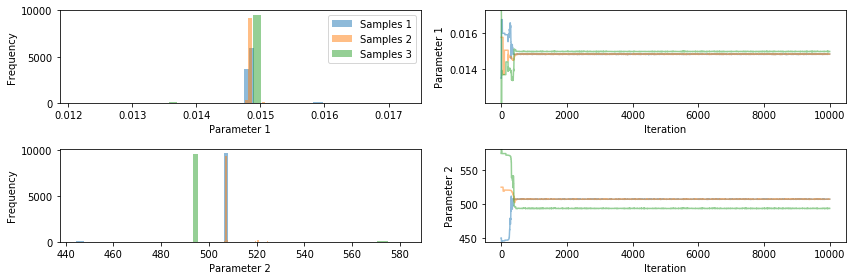

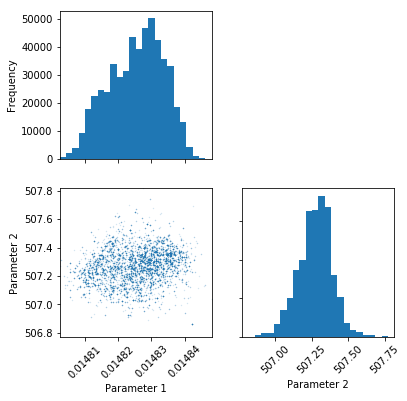

In [31]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

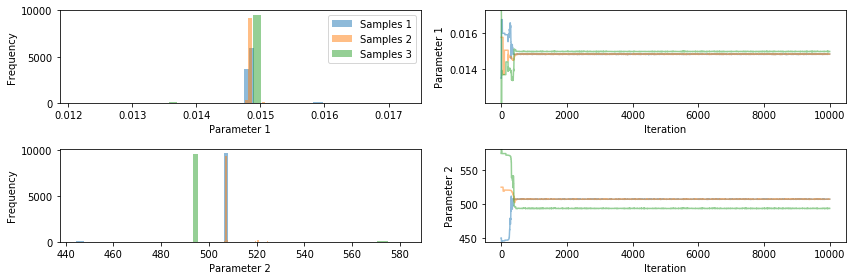

In [32]:
pints.plot.trace(chains_emu)
plt.show()

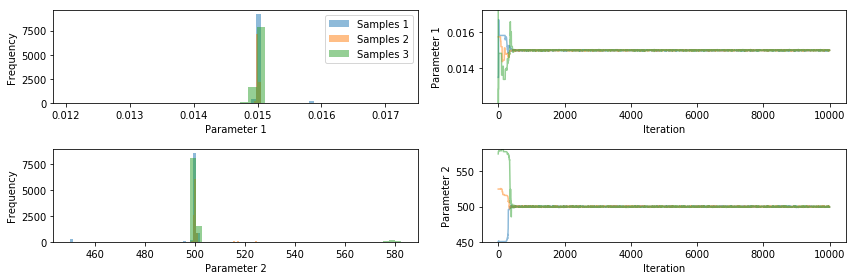

In [33]:
pints.plot.trace(chains)
plt.show()

In [34]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

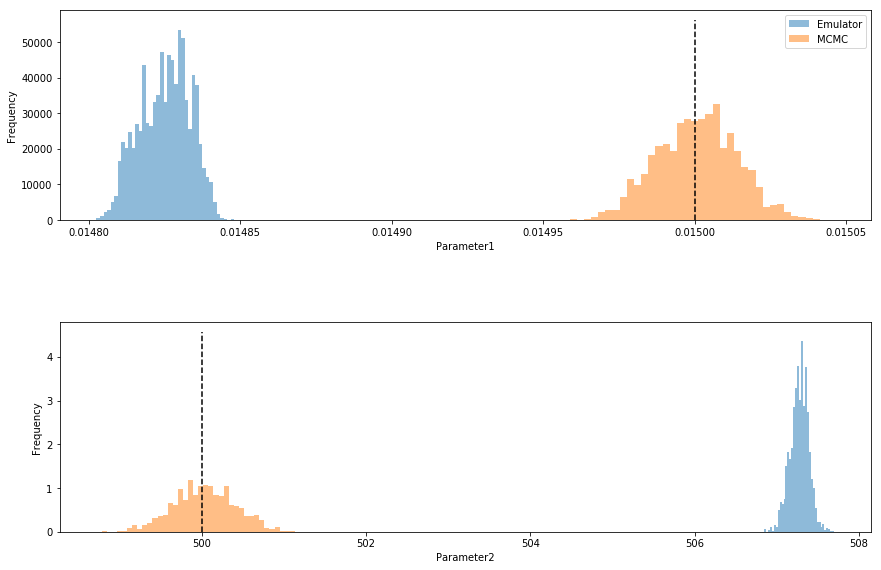

In [35]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

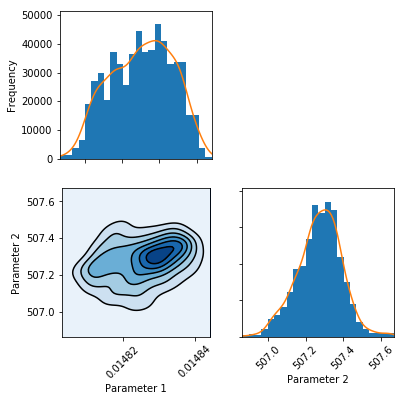

In [36]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

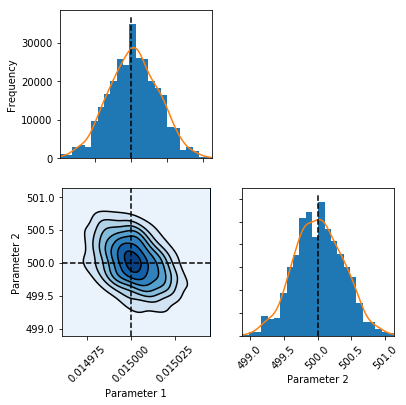

In [37]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

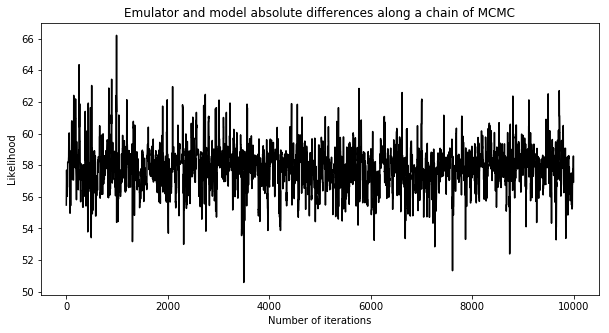

56.94303352472116

In [38]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

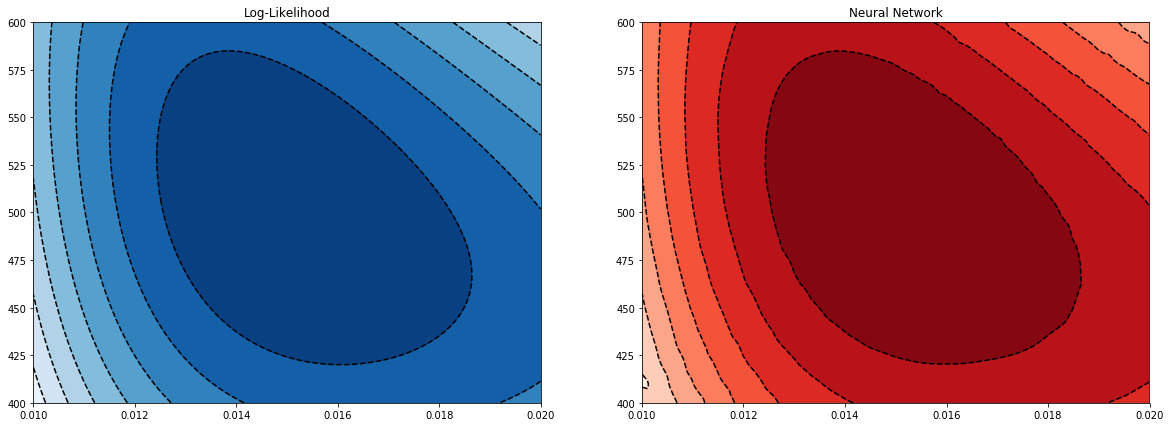

In [40]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

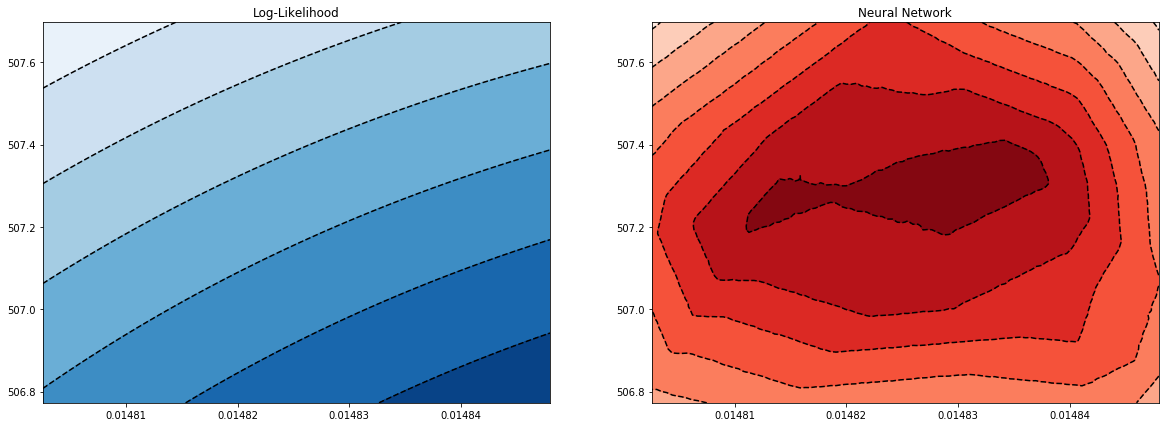

In [41]:
# Create grid
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

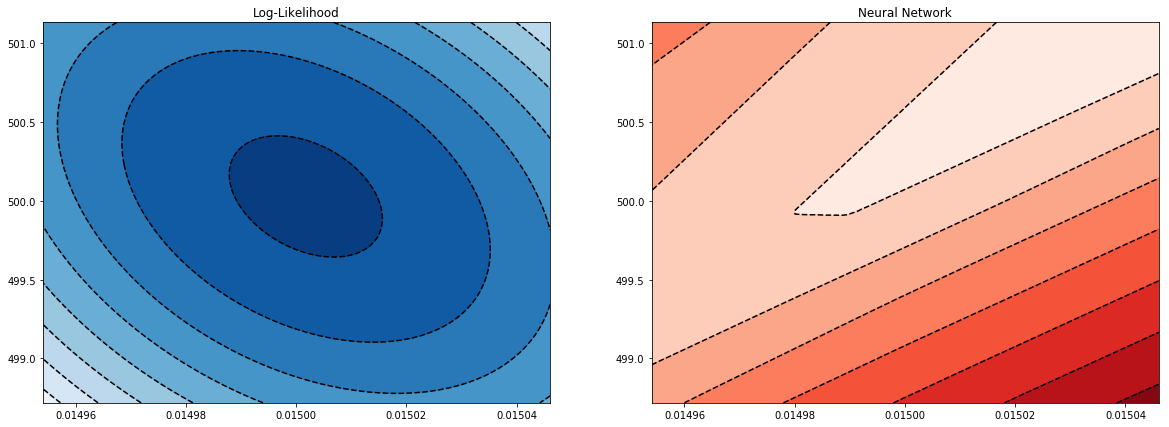

In [42]:
# Create grid
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

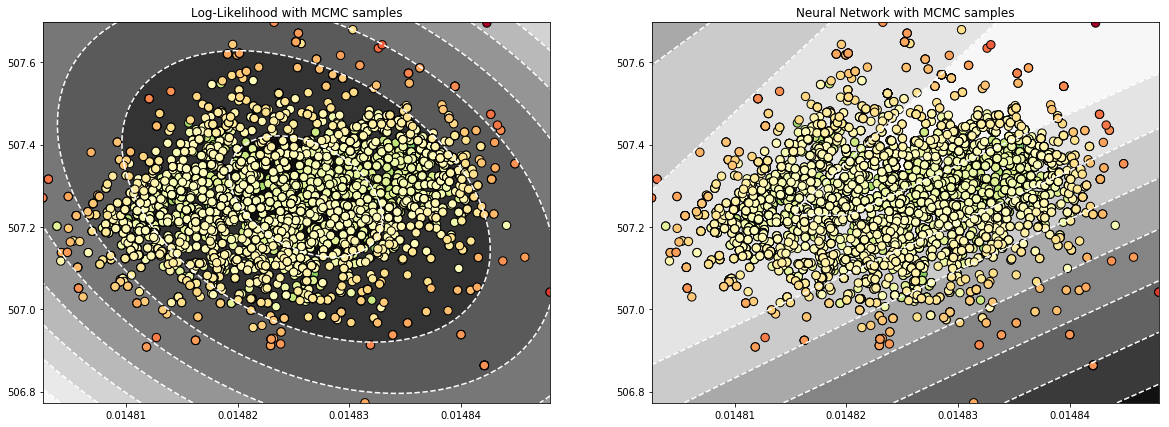

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

# Sort according to likelihood error
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

plt.show()

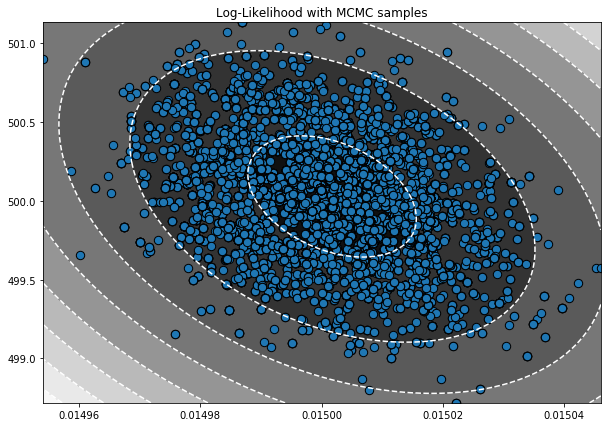

In [44]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()